# State2Drug（ERAP2）：从结构集合构建 pocket-state ensemble，并用于 HTVS / 生成 / QSAR / 亲和力评估

本笔记本实现端到端工作流，默认使用当前工作目录中的数据文件：

- 结构输入：`Structure/`（递归读取全部 `.pdb`）
- 训练标签（默认）：`ERAP2_BindingDB.tsv`（BindingDB 子集；`Activity (nM)` → `pActivity`；并按 `<= 10000 nM` 标注 active/inactive）
- 训练用阴性对照（默认开启）：从 `BindingDB_All.tsv` 生成与活性样本 **等量**、低相似度 decoy（会扫描大文件；结果缓存到 `data/labels/<target_id>/`）

关键产物与图表写入：`runs/<RUN_ID>/`，其中：

- `runs/<RUN_ID>/figures/*.png`：关键图表（可在 VS Code/Jupyter 或离线查看）
- `runs/<RUN_ID>/htvs/`：筛选结果与证据链（`evidence/*.json`，日志 `htvs.log`）
- `runs/<RUN_ID>/gen_nontargeted/`、`runs/<RUN_ID>/gen_targeted/`：生成分子与轨迹（`trajectories/*.sdf`）

实现说明（主模型与亲和力评估）：

- 主打分模型：Torch + SE(3)-equivariant EGNN，对 pocket-state 条件下的 protein–ligand 复合物进行编码，并在多个 state/pose 上做 MIL 聚合，输出 `main_score` + `state_profile`。
- Pose 生成：仅使用几何后端（RDKit ETKDG + 随机放置 + 局部 refine），不依赖外部 docking 工具。
- 亲和力评估：使用 `AffinityCharCNNPredictor`（蛋白序列 + SMILES）对候选/生成分子做快速打分（见第 15 节）。


## 0. 环境与快速开始

### 1) 环境（conda / pip 均可）

项目自带 `environment.yml`，包含 RDKit / Matplotlib / ipywidgets / PyTorch 等（`pyarrow` 用于 parquet；缺失时会自动回退写 CSV）。

```bash
conda env create -f environment.yml
conda activate State2Drug
jupyter lab   # 或 jupyter notebook
```

若未使用 conda，可使用系统 Python 安装依赖。若缺少 `torch`，可安装 CPU 版本：

```bash
python3 -m pip install --user --upgrade torch --index-url https://download.pytorch.org/whl/cpu --extra-index-url https://pypi.org/simple
```

安装后需**重启笔记本 kernel**。

运行时需确保 kernel 对应已安装依赖的 Python 环境（conda 时为 `State2Drug`），否则可能出现导入失败或可视化异常。

### 2) 数据准备（本目录默认路径）

- `ERAP2_BindingDB.tsv`：训练默认标签（BindingDB 子集）
- `Structure/`：复合物结构（递归读取所有 `.pdb`）
- （可选）`BindingDB_All.tsv`：用于从大库生成低相似度 decoy（训练默认会用到）


### 3) 可视化依赖与故障排查

若出现空白输出或控件缺失，可按下列步骤排查：

- **确认内核**：Kernel 应为已安装依赖的环境（conda 时为 `State2Drug`）
- **Matplotlib 不显示**：先运行前面的“环境与配置”代码单元；必要时在笔记本中执行 `%matplotlib inline`
- **ipywidgets 不显示**：
  - Classic Notebook：`jupyter nbextension enable --py widgetsnbextension --sys-prefix`
  - JupyterLab < 3：需要 `@jupyter-widgets/jupyterlab-manager`
  - VS Code：需要安装 `Jupyter` 扩展，并确保启用 ipywidgets 支持

若不依赖笔记本内嵌交互展示，所有关键图仍会写入 `runs/<RUN_ID>/figures/*.png`，可直接在文件系统中查看。

---


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import state2drug as s2d

BASE = Path.cwd()
DATA = BASE / "data"
RUNS = BASE / "runs"

s2d.disable_rdkit_logs()
s2d.set_seed(0)
RUN_ID = f"ERAP2_{s2d.now_ts()}"
RUN_DIR = RUNS / RUN_ID
RUN_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = RUN_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ===== Matplotlib 配置（兼容 VS Code/Jupyter） =====
S2D_COLORWAY = [
    "#1f77b4",  # 现代蓝色
    "#ff7f0e",  # 活力橙色
    "#2ca02c",  # 自然绿色
    "#d62728",  # 优雅红色
    "#9467bd",  # 紫色
    "#8c564b",  # 棕色
    "#e377c2",  # 粉色
    "#7f7f7f",  # 灰色
    "#bcbd22",  # 橄榄色
    "#17becf",  # 青色
]

S2D_CMAP = mpl.colors.LinearSegmentedColormap.from_list("s2d", S2D_COLORWAY)

mpl.rcParams.update(
    {
        "figure.dpi": 120,
        "savefig.dpi": 200,
        "font.size": 12,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "legend.fontsize": 10,
    }
)


def savefig(fig, path: Path, dpi: int = 200):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    try:
        fig.tight_layout()
    except Exception:
        pass
    fig.savefig(path, dpi=dpi, bbox_inches="tight")

# ===== 配置（可选：按需修改） =====
# 本地数据（默认路径）
STRUCTURE_DIR = Path("Structure")
ERAP2_FASTA = Path("ERAP2_HUMAN.fasta")
BINDINGDB_TSV = Path("BindingDB_All.tsv")
# ERAP2 专用 BindingDB 子集（已预处理）
ERAP2_BINDINGDB_TSV = Path("ERAP2_BindingDB.tsv")
N_POCKET_ATOMS = 64

# DrugGEN 推理输出（CSV，默认列名 SMILES）
DRUGGEN_CSV = Path("data/druggen/inference_drugs.csv")


# RDKit 标准化：尽量把 SMILES 还原为非质子化/非盐形式（neutral parent）
# 说明：对一些“共振电荷形式”（例如 nitro / N-oxide）不一定会消除电荷，这是化学表示问题而非质子化。
def _neutralize_smiles(s: str) -> str | None:
    try:
        from rdkit import Chem
        from rdkit.Chem.MolStandardize import rdMolStandardize

        m = Chem.MolFromSmiles(str(s))
        if m is None:
            return None
        # 先 uncharge（去除可逆电荷/质子化）
        try:
            m = rdMolStandardize.Uncharger().uncharge(m)
        except Exception:
            pass
        # 再取 charge parent（去盐/中和常见形式）
        try:
            m = rdMolStandardize.ChargeParent(m)
        except Exception:
            pass
        return Chem.MolToSmiles(m)
    except Exception:
        try:
            from rdkit import Chem

            m = Chem.MolFromSmiles(str(s))
            return Chem.MolToSmiles(m) if m is not None else None
        except Exception:
            return None


# 强制输出的参考/基准化合物（会强制加入库与候选表，确保最终表格一定包含它们）
FORCE_INCLUDE_SMILES = [
    "O=C(NC[C@@H]1Cc2cccc(-c3cccnc3)c2O1)c1ccc2c(c1)no[n+]2[O-]",
    "N[C@H](C(=O)Nc1ccc2oc(=O)n(CC(=O)N3CCCCC3)c2c1)c1ccc(-c2ccccc2)cc1",
]
REFERENCE_LIGAND_FALLBACK_SMILES = "N[C@H](C(=O)Nc1ccc2oc(=O)n(CC(=O)N3CCCCC3)c2c1)c1ccc(-c2ccccc2)cc1"


# 强制化合物的“还原后（尽量非质子化）”版本：后续流程优先使用它
FORCE_INCLUDE_SMILES_NEUTRAL = [s for s in (_neutralize_smiles(x) for x in FORCE_INCLUDE_SMILES) if s]
REFERENCE_LIGAND_FALLBACK_SMILES_NEUTRAL = _neutralize_smiles(REFERENCE_LIGAND_FALLBACK_SMILES) or REFERENCE_LIGAND_FALLBACK_SMILES
print({
    "FORCE_INCLUDE_SMILES_NEUTRAL": FORCE_INCLUDE_SMILES_NEUTRAL,
    "REFERENCE_LIGAND_FALLBACK_SMILES_NEUTRAL": REFERENCE_LIGAND_FALLBACK_SMILES_NEUTRAL,
})

# 数据源：训练与评估统一使用 ERAP2_BindingDB.tsv
RUN_BINDINGDB_EXTRACT = False

# DECOY 生成：启用后将分块扫描 BindingDB_All.tsv（大文件；计算与 I/O 开销较高，结果将缓存）
RUN_BINDINGDB_DECOY_GEN = True  # 训练用：基于 ERAP2_BindingDB 活性样本生成等量低相似度 decoy
# BindingDB 活性阈值（nM）：active 定义为 activity_nM ≤ 10000 nM
BINDINGDB_ACTIVE_THRESHOLD_NM = 10000.0
BINDINGDB_ACTIVE_THRESHOLD_PACT = 9.0 - np.log10(BINDINGDB_ACTIVE_THRESHOLD_NM)
N_DECOYS = None  # None/<=0：与活性样本数量一致
DECOY_SIMILARITY_MAX = 0.30
DECOY_INACTIVE_VALUE_NM = 1e6  # 1 mM -> pActivity=3

# BindingDB 抽取条件（仅当 RUN_BINDINGDB_EXTRACT=True 时生效）
BINDINGDB_LIMIT = 5000
BINDINGDB_TARGET_NAME = "Endoplasmic reticulum aminopeptidase 2"
BINDINGDB_ORGANISM_CONTAINS = "Homo sapiens"  # Human

# 高开销步骤开关：用于显式控制长耗时任务
RUN_DRUGGEN_SCREEN = False

# 可视化规模控制（限制绘图点数）
PLOT_MAX_POINTS = 5000

# 训练规模控制：每条标签需要生成 pose；通过限制训练样本数控制计算开销
MAX_TRAIN = 2000

# 生成控制：避免生成过小/过于简单的分子
# 生成数量：Non-targeted 总数 & Targeted 每个 pocket(state) 数量
GEN_N_MOLECULES = 20
GEN_N_MOLECULES_PER_POCKET = 10
GEN_TARGETED_PER_POCKET = True
GEN_TARGETED_MAX_STATES = None  # 可选：限制参与生成的 state 数量（例如 4）；None 表示全部
GEN_STEPS = 8
GEN_BEAM_WIDTH = 8
GEN_MIN_HEAVY_ATOMS = 22
GEN_MAX_HEAVY_ATOMS = 60
GEN_MIN_RINGS = 2
GEN_QED_MIN = 0.35
GEN_SCORE_EVALS_PER_STEP = 4

# 类药规则：有效生成必须满足（Rule-of-5 + Veber）
DRUGLIKE_ENABLE = True
DRUGLIKE_MAX_RO5_VIOLATIONS = 1
DRUGLIKE_RO5_MAX_MW = 500.0
DRUGLIKE_RO5_MAX_LOGP = 5.0
DRUGLIKE_RO5_MAX_HBD = 5
DRUGLIKE_RO5_MAX_HBA = 10
DRUGLIKE_VEBER_MAX_ROTB = 10
DRUGLIKE_VEBER_MAX_TPSA = 140.0

# HTVS 并行设置（多核）
HTVS_N_JOBS = 1  # 可根据可用 CPU 线程数调整

# 亲和力评估（SMILES + 蛋白序列；可用 GPU 批量推理）
RUN_AFFINITY_TRAIN = True
RUN_AFFINITY_PRED = True
AFFINITY_EPOCHS = 60
AFFINITY_BATCH_SIZE = 512
AFFINITY_LR = 1e-3
AFFINITY_MAX_SMILES_LEN = 140
AFFINITY_MAX_PROTEIN_LEN = 1024
AFFINITY_MODEL_PATH = RUN_DIR / "affinity_charcnn.pt"

# QSAR（SMILES -> pActivity）设置：展示训练效果（回归 + 可解释性）
QSAR_FP_BITS = 2048
QSAR_RADIUS = 2
QSAR_TEST_SIZE = 0.20
QSAR_CV_FOLDS = 5
QSAR_N_ESTIMATORS = 1200
QSAR_RANDOM_STATE = 0

# 严格过滤（用于 HTVS/生成/评估）：PAINS/反应性/SA 等
APPLY_STRICT_FILTERS = True
FILTER_CONFIG = (
    s2d.FilterConfig(
        use_pains=True,
        use_brenk=False,
        use_nih=False,
        use_zinc=False,
        use_reactive=True,
        max_pains_hits=0,
        max_reactive_hits=0,
        sa_max=7.0,
        qed_min=0.20,
    )
    if APPLY_STRICT_FILTERS
    else None
)

# Pose 生成：本版本仅使用几何后端（RDKit ETKDG + 随机放置 + 局部优化）
# 不依赖外部 docking 工具（不再依赖外部对接可执行文件）
POSE_CONFIG_TRAIN = s2d.PoseGenConfig(
    backend="geometry",
    coarse_multiplier=12,
    refine_iters=40,
    refine_translation=0.35,
    refine_angle_deg=10.0,
    min_contact_count=4,
    max_clash_count=2,
)
POSE_CONFIG_COARSE = s2d.PoseGenConfig(
    backend="geometry",
    coarse_multiplier=12,
    refine_iters=40,
    refine_translation=0.35,
    refine_angle_deg=10.0,
    min_contact_count=4,
    max_clash_count=2,
    max_anchors=10,
    anchor_distance=2.2,
    min_anchor_matches=0,
)
POSE_CONFIG_FINE = s2d.PoseGenConfig(
    backend="geometry",
    coarse_multiplier=16,
    refine_iters=60,
    refine_translation=0.30,
    refine_angle_deg=10.0,
    min_contact_count=6,
    max_clash_count=0,
    stability_samples=16,
    stability_translation=0.20,
    stability_angle_deg=6.0,
    stability_ok_frac_min=0.5,
    max_anchors=10,
    anchor_distance=2.2,
    min_anchor_matches=0,
)

config = {
    "RUN_DIR": str(RUN_DIR),
    "FIG_DIR": str(FIG_DIR),
    "STRUCTURE_DIR": str(STRUCTURE_DIR),
    "ERAP2_FASTA": str(ERAP2_FASTA),
    "BINDINGDB_TSV": str(BINDINGDB_TSV),
    "ERAP2_BINDINGDB_TSV": str(ERAP2_BINDINGDB_TSV),
    "N_POCKET_ATOMS": N_POCKET_ATOMS,
    "DRUGGEN_CSV": str(DRUGGEN_CSV),
    "RUN_BINDINGDB_EXTRACT": RUN_BINDINGDB_EXTRACT,
    "RUN_BINDINGDB_DECOY_GEN": RUN_BINDINGDB_DECOY_GEN,
    "BINDINGDB_ACTIVE_THRESHOLD_NM": BINDINGDB_ACTIVE_THRESHOLD_NM,
    "N_DECOYS": N_DECOYS,
    "DECOY_SIMILARITY_MAX": DECOY_SIMILARITY_MAX,
    "DECOY_INACTIVE_VALUE_NM": DECOY_INACTIVE_VALUE_NM,
    "BINDINGDB_LIMIT": BINDINGDB_LIMIT,
    "BINDINGDB_TARGET_NAME": BINDINGDB_TARGET_NAME,
    "BINDINGDB_ORGANISM_CONTAINS": BINDINGDB_ORGANISM_CONTAINS,
    "RUN_DRUGGEN_SCREEN": RUN_DRUGGEN_SCREEN,
    "PLOT_MAX_POINTS": PLOT_MAX_POINTS,
    "MAX_TRAIN": MAX_TRAIN,
    "GEN_N_MOLECULES": GEN_N_MOLECULES,
    "GEN_STEPS": GEN_STEPS,
    "GEN_BEAM_WIDTH": GEN_BEAM_WIDTH,
    "GEN_MIN_HEAVY_ATOMS": GEN_MIN_HEAVY_ATOMS,
    "GEN_MAX_HEAVY_ATOMS": GEN_MAX_HEAVY_ATOMS,
    "GEN_MIN_RINGS": GEN_MIN_RINGS,
    "GEN_QED_MIN": GEN_QED_MIN,
    "GEN_SCORE_EVALS_PER_STEP": GEN_SCORE_EVALS_PER_STEP,
    "HTVS_N_JOBS": HTVS_N_JOBS,
    "RUN_AFFINITY_TRAIN": RUN_AFFINITY_TRAIN,
    "RUN_AFFINITY_PRED": RUN_AFFINITY_PRED,
    "AFFINITY_EPOCHS": AFFINITY_EPOCHS,
    "AFFINITY_BATCH_SIZE": AFFINITY_BATCH_SIZE,
    "AFFINITY_LR": AFFINITY_LR,
    "AFFINITY_MAX_SMILES_LEN": AFFINITY_MAX_SMILES_LEN,
    "AFFINITY_MAX_PROTEIN_LEN": AFFINITY_MAX_PROTEIN_LEN,
    "AFFINITY_MODEL_PATH": str(AFFINITY_MODEL_PATH),
    "QSAR_FP_BITS": QSAR_FP_BITS,
    "QSAR_RADIUS": QSAR_RADIUS,
    "QSAR_TEST_SIZE": QSAR_TEST_SIZE,
    "QSAR_CV_FOLDS": QSAR_CV_FOLDS,
    "QSAR_N_ESTIMATORS": QSAR_N_ESTIMATORS,
    "QSAR_RANDOM_STATE": QSAR_RANDOM_STATE,
    "APPLY_STRICT_FILTERS": APPLY_STRICT_FILTERS,
    "FILTER_CONFIG": str(FILTER_CONFIG),
    "POSE_CONFIG_TRAIN": str(POSE_CONFIG_TRAIN),
    "POSE_CONFIG_COARSE": str(POSE_CONFIG_COARSE),
    "POSE_CONFIG_FINE": str(POSE_CONFIG_FINE),
}
config

RUN_DIR


{'FORCE_INCLUDE_SMILES_NEUTRAL': ['O=C(NC[C@@H]1Cc2cccc(-c3cccnc3)c2O1)c1ccc2c(c1)no[n+]2[O-]', 'N[C@H](C(=O)Nc1ccc2oc(=O)n(CC(=O)N3CCCCC3)c2c1)c1ccc(-c2ccccc2)cc1'], 'REFERENCE_LIGAND_FALLBACK_SMILES_NEUTRAL': 'N[C@H](C(=O)Nc1ccc2oc(=O)n(CC(=O)N3CCCCC3)c2c1)c1ccc(-c2ccccc2)cc1'}


PosixPath('/media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/runs/ERAP2_20260129_110535')

## 1. 目标与范围（本笔记本实现的工作）

以 ERAP2 为例，本笔记本完成以下端到端流程：

1. **结构 → pocket frames**：从 `Structure/` 递归读取共晶结构（`.pdb`），为每个结构构建一帧 pocket 局部坐标
2. **frames → state ensemble**：用几何不变描述符（pairwise distance）做 PCA + KMeans 得到 pocket states，并输出代表结构/转移统计
3. **标签 → pActivity**：使用 `ERAP2_BindingDB.tsv` 构建训练标签，并自动生成与活性样本等量、低相似度 decoy
4. **训练与评估（主模型）**：Torch + SE(3)-equivariant EGNN 对 protein–ligand 复合物进行 state-conditioned 打分，并输出 state 偏好谱
5. **下游任务**：HTVS（流式筛选）与 片段重组式生成（输出轨迹）

所有结果（表格/证据链/图表/轨迹）均写入 `runs/<RUN_ID>/`，用于可复现性与结果报告。


## 2. 核心概念与统一数据对象（与代码实现保持一致）

下面这些对象在 `state2drug.py` 中已实现，并贯穿各模块：

- `Target`：靶点元信息（用于组织产物目录；也可扩展 pocket 定义/网格等）
- `FrameDataset`：口袋局部坐标帧集合（来自 `Structure/` 或合成示例）
- `PocketStructure` / `PocketState`：state 表征与代表结构
- `Ligand` / `Pose`：分子与 pose（RDKit 构象 + 口袋内粗→精两阶段几何 pose；可替换为其它 pose 生成策略）
- `EvidenceRecord` / `Candidate`：证据链与候选对象

活性标签在本笔记本中以 pandas DataFrame 形式管理（`labels_norm/labels_agg/labels_bindingdb`），并通过 `target_id/source` 保持可追溯。


In [2]:
target = s2d.Target(
    target_id="ERAP2",
    pocket_definition={
        "type": "structure_dir",
        "source": "Structure/",
        "pocket_proxy": "nearest protein atoms to largest non-water/ion HETATM ligand",
    },
)
target


Target(target_id='ERAP2', pocket_definition={'type': 'structure_dir', 'source': 'Structure/', 'pocket_proxy': 'nearest protein atoms to largest non-water/ion HETATM ligand'})

## 3. 系统级执行原则（本笔记本的执行策略）

- **大文件（BindingDB）**：按 chunk 读取 + 本地缓存（`data/labels/<target_id>/` 下会写 parquet/csv，避免每次重复扫描）
- **计算分级**：粗筛用少量 state/pose，精筛再增加 state/pose（支持两阶段 HTVS）
- **产物可追溯**：训练曲线、命中证据链、生成轨迹与图表均写入 `runs/<RUN_ID>/`，用于可复现性、对比分析与结果报告


## 4. 模块A：结构/轨迹解析与口袋局部样本构建

本笔记本默认从 `Structure/` 递归读取 `.pdb`，并为每个结构构建一帧 pocket 坐标（`FrameDataset`）：

- 解析蛋白 `ATOM` 坐标
- 识别最大的非水/非离子 `HETATM` 组作为共晶配体（若存在）
- 选取距离该配体最近的 `N_POCKET_ATOMS` 个蛋白原子作为 pocket 定义
- 对每帧做中心化（去平移），得到 `frames.npz` + `frame_index.json`

若输入为分子动力学（MD）轨迹，可使用 MDAnalysis/mdtraj 读取拓扑与轨迹，并基于明确的 pocket 定义（残基集合/空间盒/配体邻域）构建物理一致的 frames。


In [3]:
# 从 Structure/ 结构集合构建 frames；在结构缺失时使用合成数据以保证流程可运行
if STRUCTURE_DIR.exists():
    frames = s2d.FrameDataset.from_structure_dir(
        STRUCTURE_DIR,
        target_id=target.target_id,
        traj_id="structures",
        n_pocket_atoms=N_POCKET_ATOMS,
        seed=0,
    )
else:
    frames = s2d.FrameDataset.from_synthetic_demo(
        target_id=target.target_id,
        traj_id="traj_synthetic",
        n_frames=240,
        n_atoms=36,
        n_states=6,
        seed=0,
    )

md_dir = DATA / "md" / target.target_id / frames.traj_id
frames_path = md_dir / "frames.npz"
frames.save_npz(frames_path)
frame_index_path = md_dir / "frame_index.json"
frames.save_frame_index_json(frame_index_path)

frames.n_frames, frames.n_atoms, frames_path, frame_index_path

(60,
 64,
 PosixPath('/media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/data/md/ERAP2/structures/frames.npz'),
 PosixPath('/media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/data/md/ERAP2/structures/frame_index.json'))

## 5. 模块B：口袋表征与 state ensemble 构建（当前实现）

- descriptor：对每帧 pocket 计算 pairwise distance（旋转/平移不变）
- embedding：PCA
- clustering：KMeans（大规模可替换为 MiniBatchKMeans）
- 输出：`states.json`、`rep_structures/state_*.pdb`、以及 state 转移统计（用于诊断 pocket 动力学覆盖）

这些 states 作为后续打分模型的条件变量（state-conditioned）。


In [4]:
state_out = s2d.embed_and_cluster_states(frames, n_states=8, embedding_dim=12, seed=0)
states = state_out["states"]
transition = state_out["transition_counts"]

states_dir = DATA / "states" / target.target_id
states_json = s2d.save_state_ensemble(states, states_dir)

len(states), states_json

(8,
 PosixPath('/media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/data/states/ERAP2/states.json'))

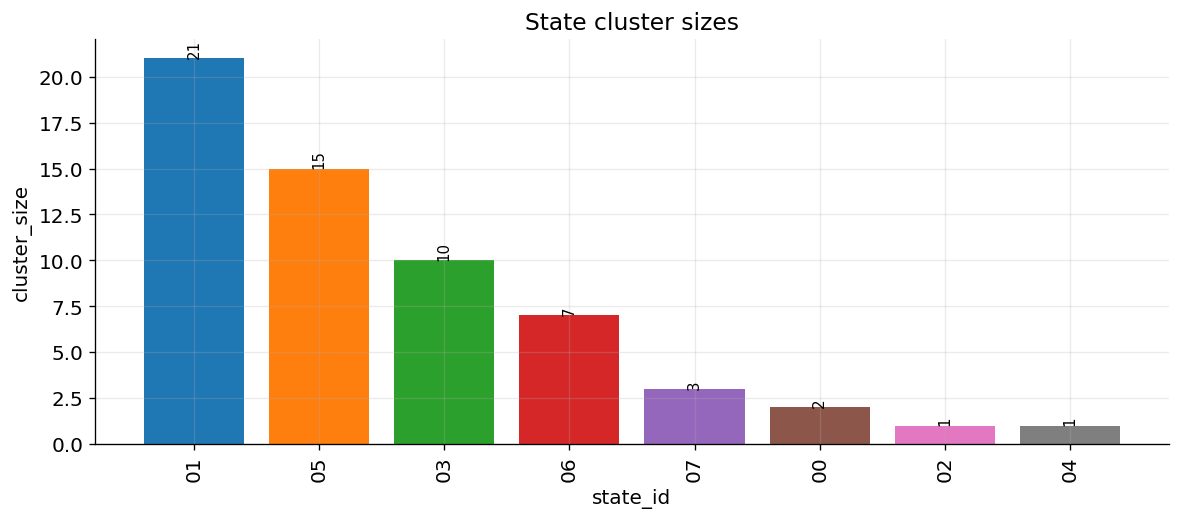

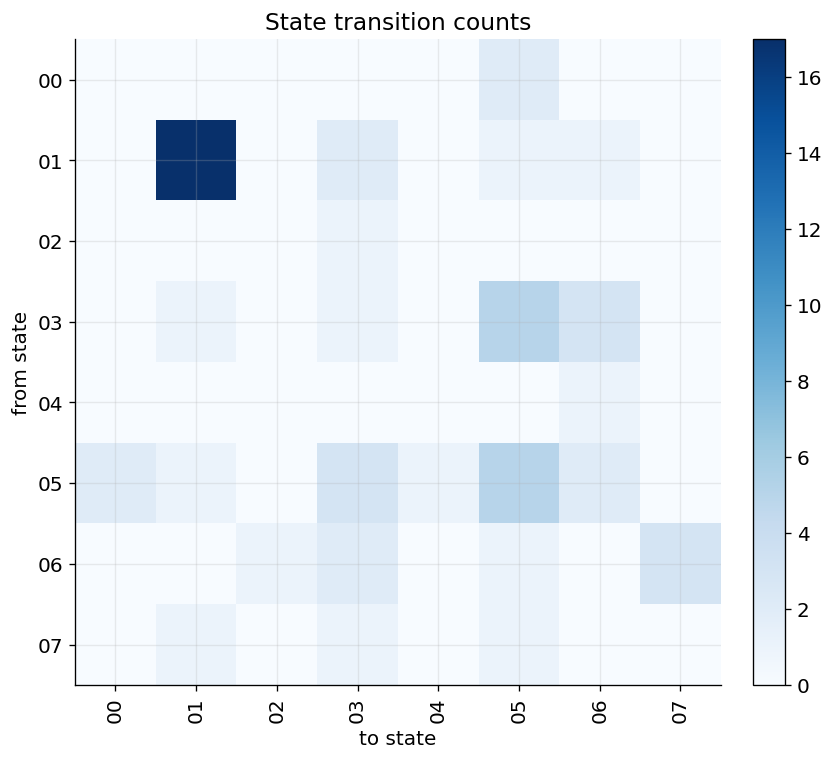

In [5]:
state_summary = pd.DataFrame(
    [
        {
            "state_id": s.state_id,
            "cluster_size": int(s.features.get("cluster_size") or 0),
            "rep_frame": s.provenance.get("rep_frame_index"),
            "rep_source": s.provenance.get("rep_source"),
        }
        for s in states
    ]
).sort_values("cluster_size", ascending=False)

state_summary

try:
    x_labels = state_summary["state_id"].astype(str).tolist()
    y_vals = state_summary["cluster_size"].astype(int).tolist()

    fig_w = max(10, 0.35 * len(x_labels))
    fig, ax = plt.subplots(figsize=(fig_w, 4.5))
    colors = [S2D_COLORWAY[i % len(S2D_COLORWAY)] for i in range(len(x_labels))]
    bars = ax.bar(x_labels, y_vals, color=colors)
    ax.set_title("State cluster sizes")
    ax.set_xlabel("state_id")
    ax.set_ylabel("cluster_size")
    ax.tick_params(axis="x", rotation=90)
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width() / 2.0, h, f"{int(h)}", ha="center", va="bottom", fontsize=9, rotation=90)

    savefig(fig, FIG_DIR / "state_cluster_sizes.png")
    plt.show()
except Exception as e:
    print("Skip state cluster size plot:", repr(e))

state_ids = [s.state_id for s in states]
try:
    fig, ax = plt.subplots(figsize=(7.5, 6.5))
    im = ax.imshow(np.asarray(transition), cmap="Blues")
    ax.set_title("State transition counts")
    ax.set_xlabel("to state")
    ax.set_ylabel("from state")

    ax.set_xticks(list(range(len(state_ids))))
    ax.set_xticklabels([str(s) for s in state_ids], rotation=90)
    ax.set_yticks(list(range(len(state_ids))))
    ax.set_yticklabels([str(s) for s in state_ids])

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    savefig(fig, FIG_DIR / "state_transition_counts.png")
    plt.show()
except Exception as e:
    print("Skip transition heatmap:", repr(e))


## 6. 模块C：实验数据整合（ERAP2_BindingDB + 等量 decoy）

本节将 `ERAP2_BindingDB.tsv` 规范化为统一的标签表（`pActivity`），并在训练阶段引入阴性对照：

- 训练标签：`ERAP2_BindingDB.tsv`（`Activity (nM)` → `pActivity`），并按 `BINDINGDB_ACTIVE_THRESHOLD_NM` 标注 `is_active`
- 阴性对照：从 `BindingDB_All.tsv` 生成与活性样本 **等量**、低相似度（Tanimoto <= `DECOY_SIMILARITY_MAX`）的 decoy，并合并进训练标签

为避免每次重复扫描大文件，decoy 与中间结果会缓存到 `data/labels/<target_id>/`。


{'labels_source': 'ERAP2_BindingDB', 'labels_norm': (294, 11), 'labels_agg': (294, 7), 'unique_smiles': 294, 'sources': {'ERAP2_BindingDB': 176, 'DECOY': 118}}


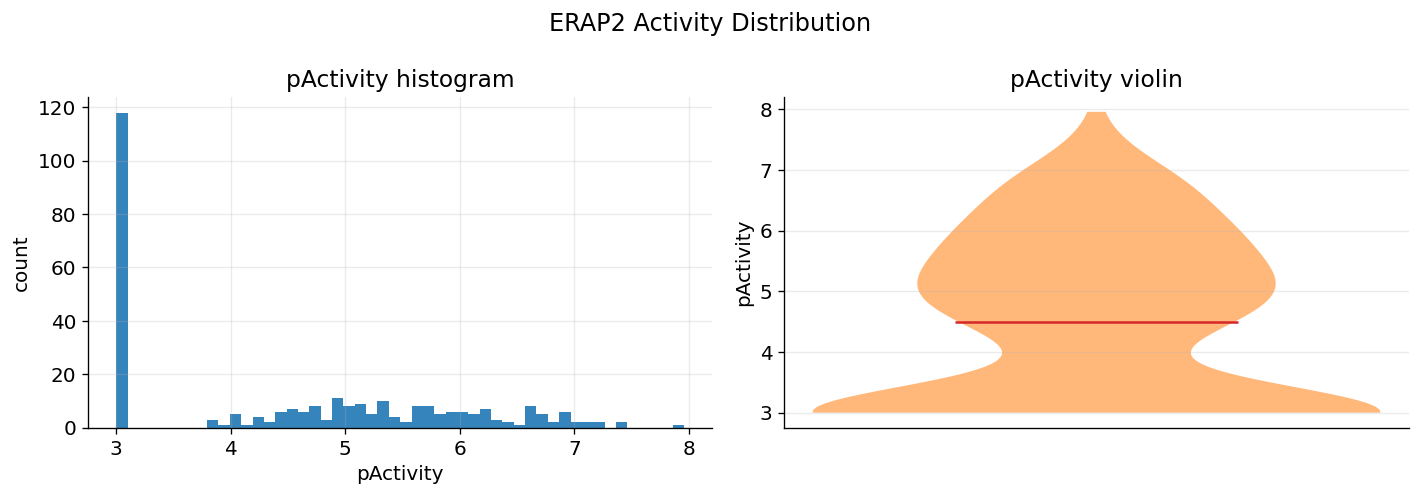

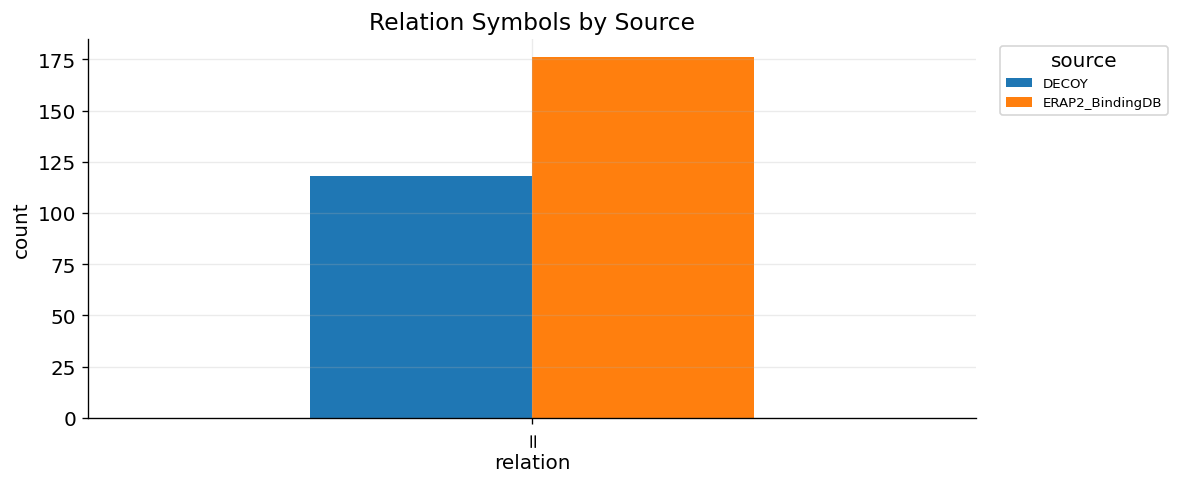

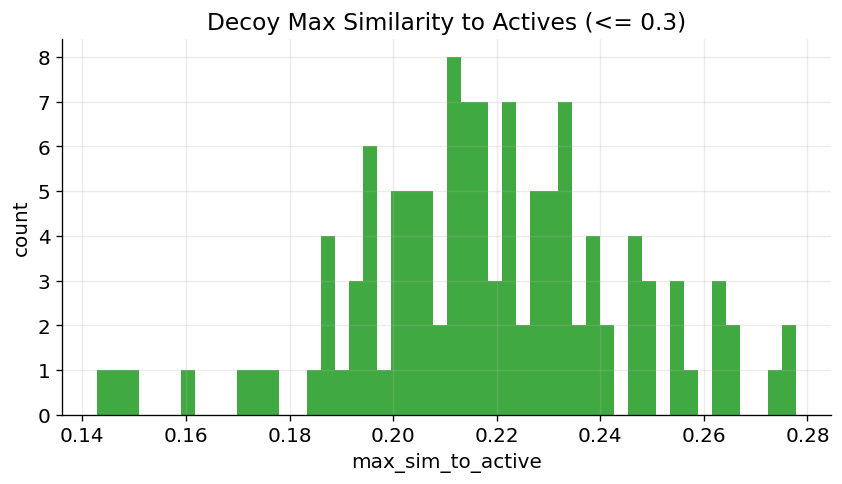

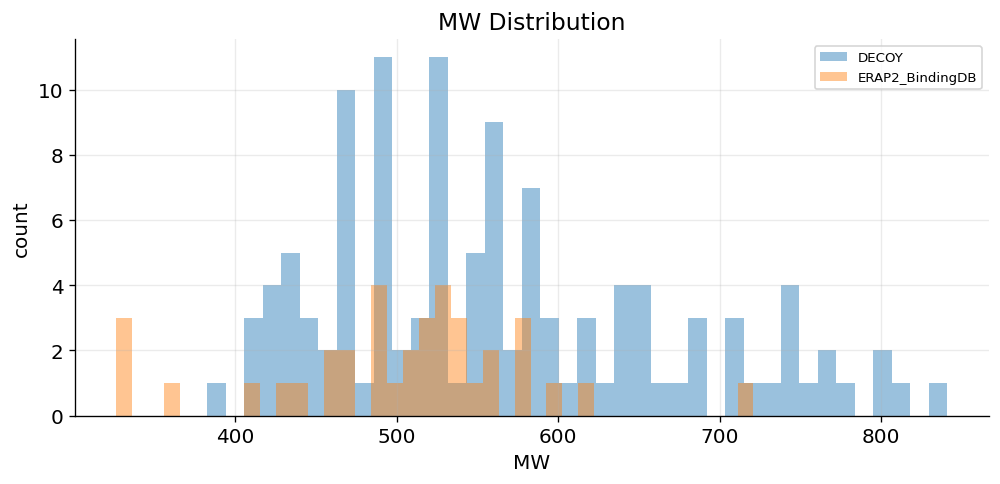

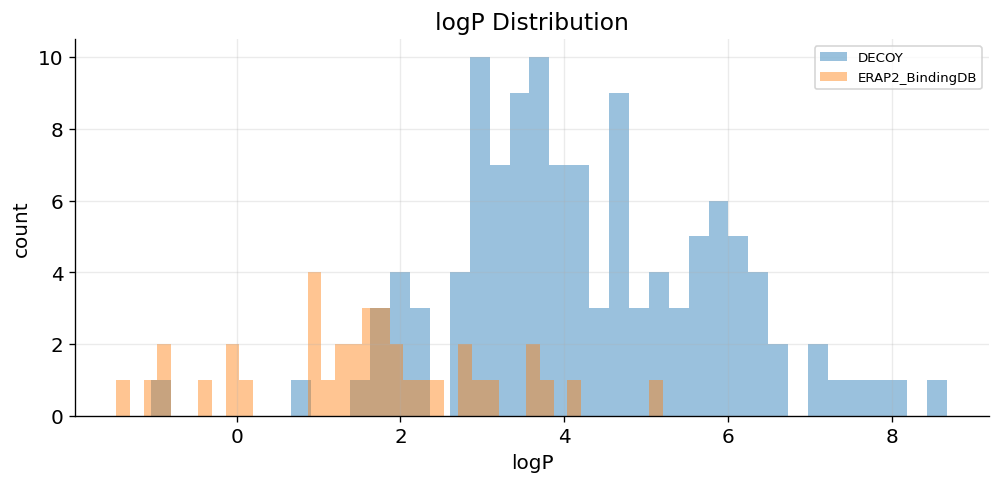

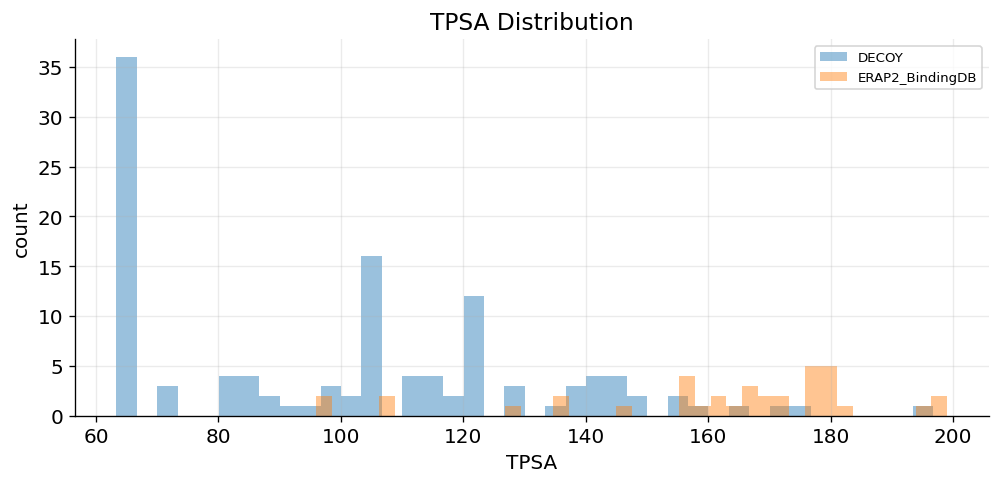

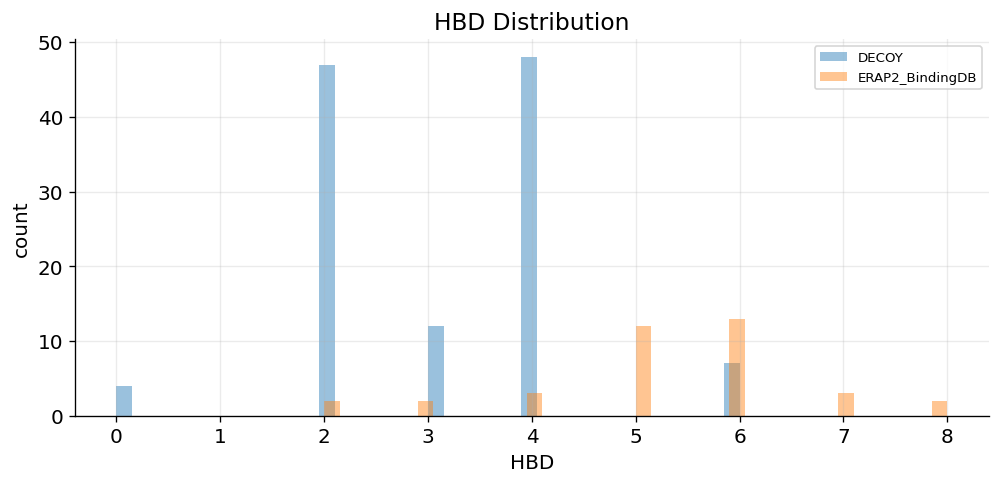

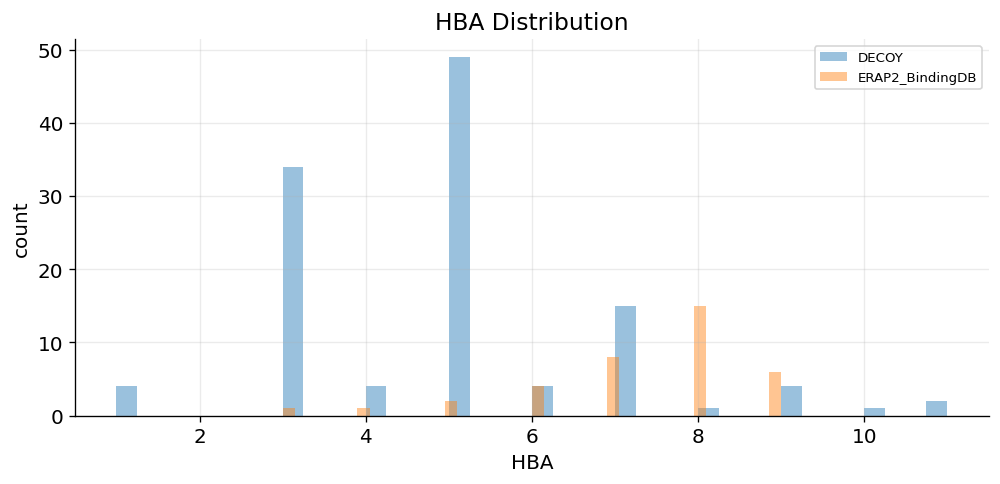

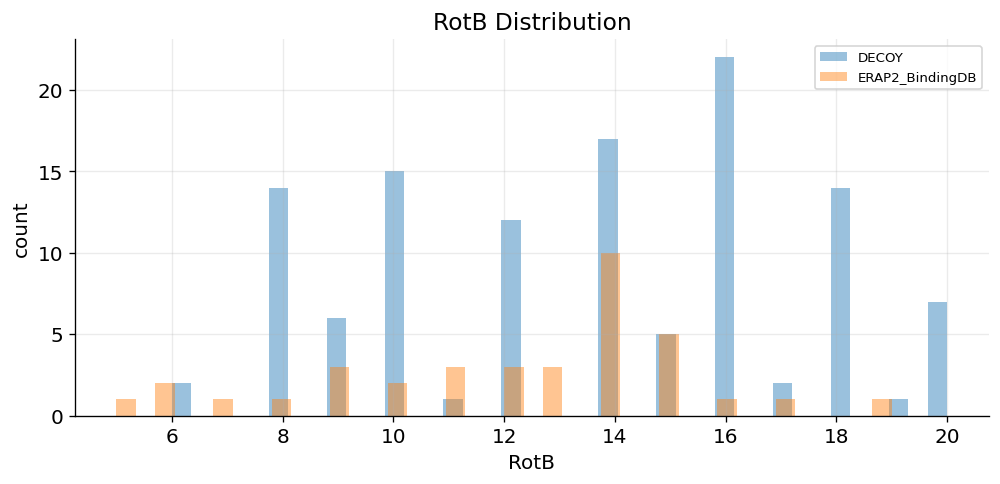

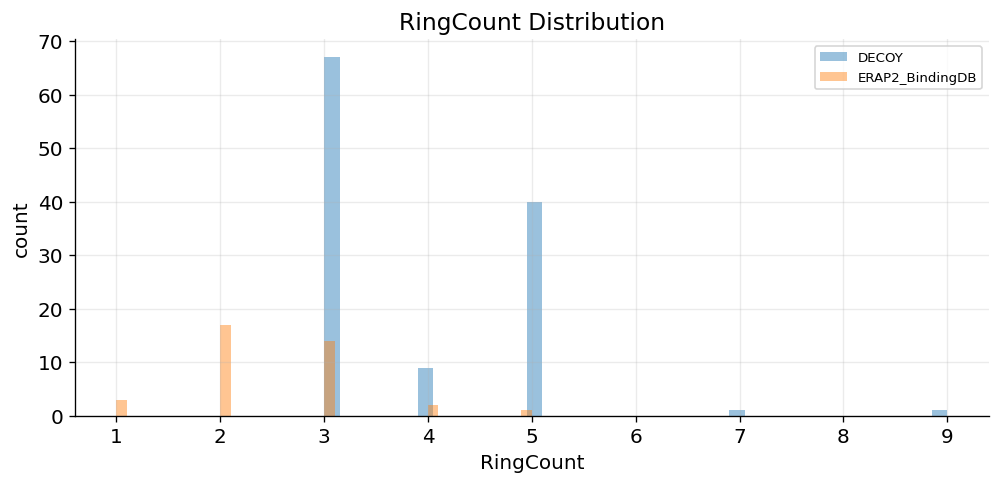

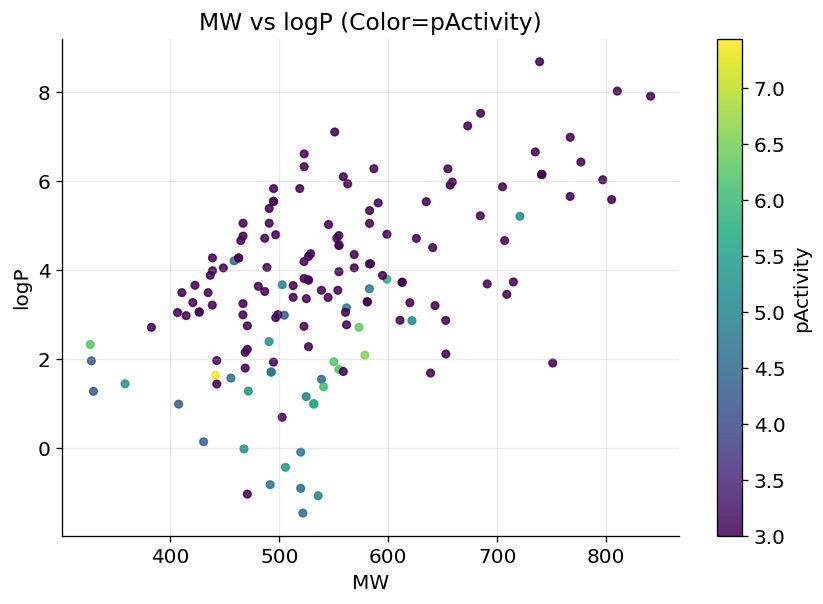

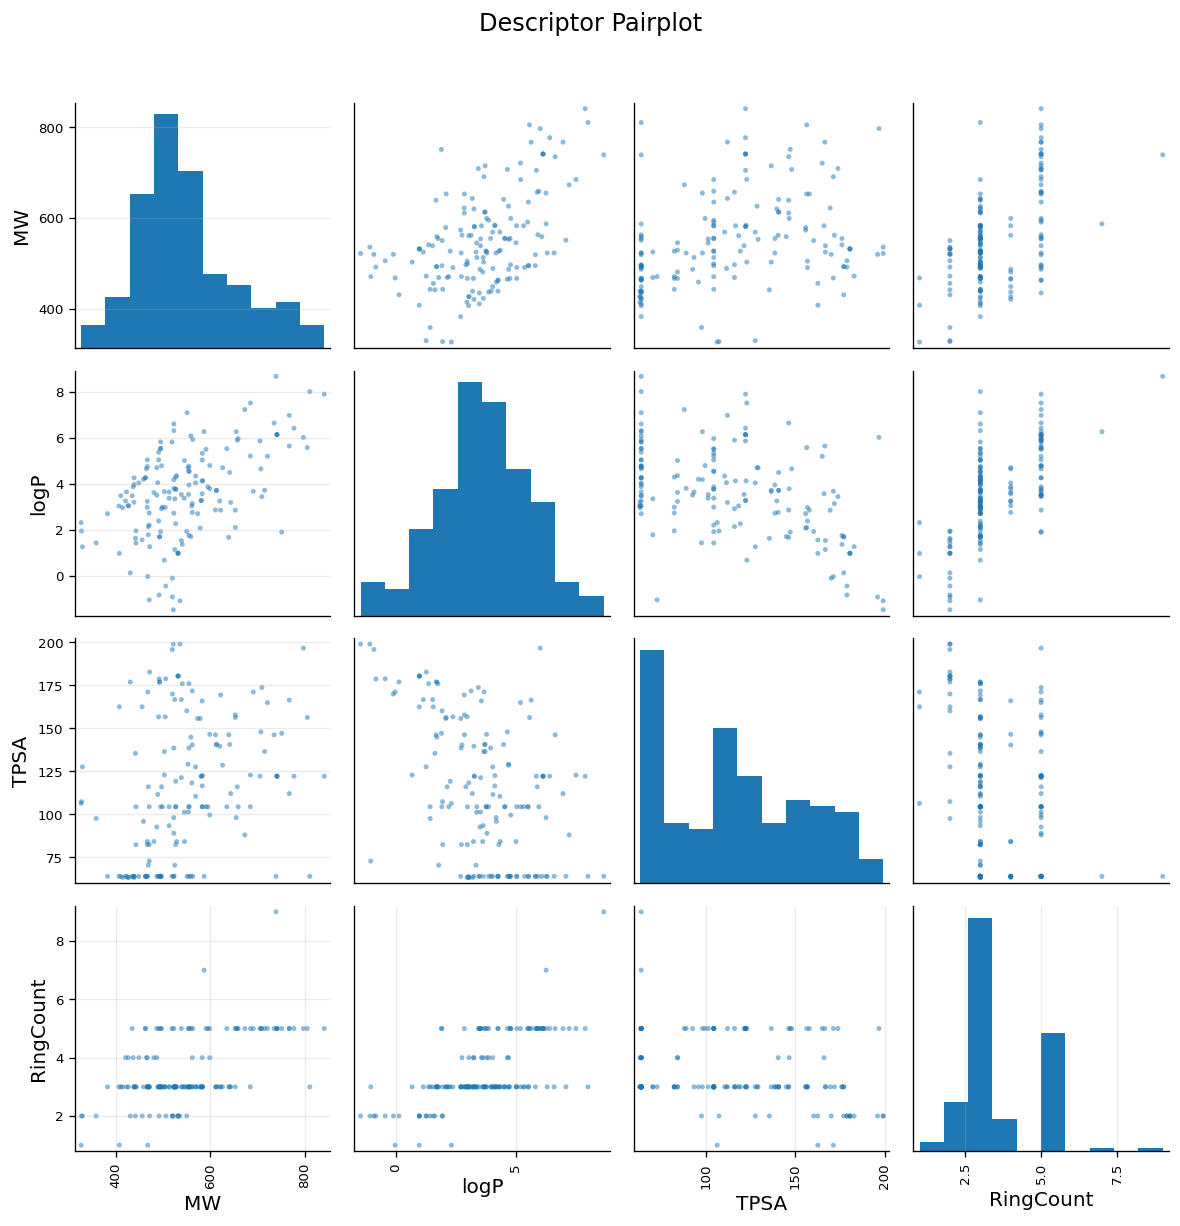

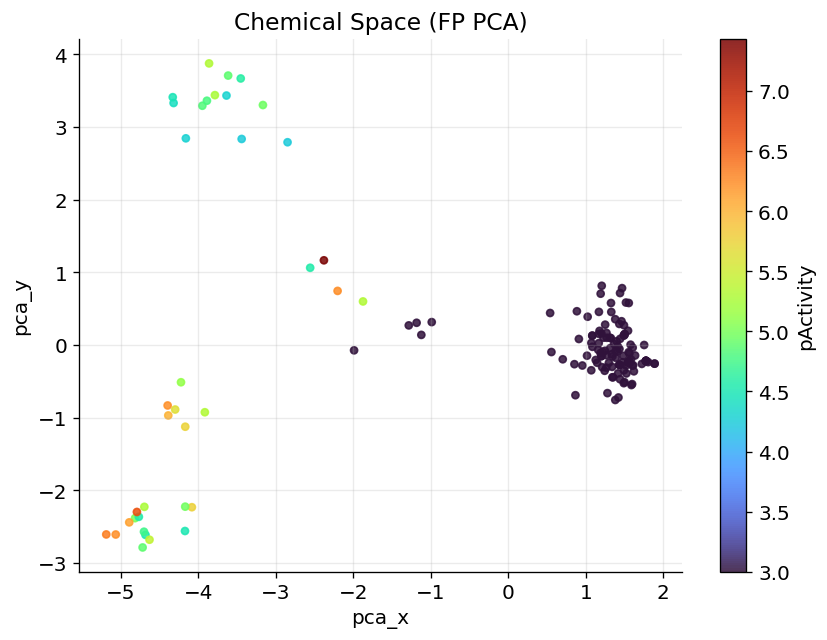

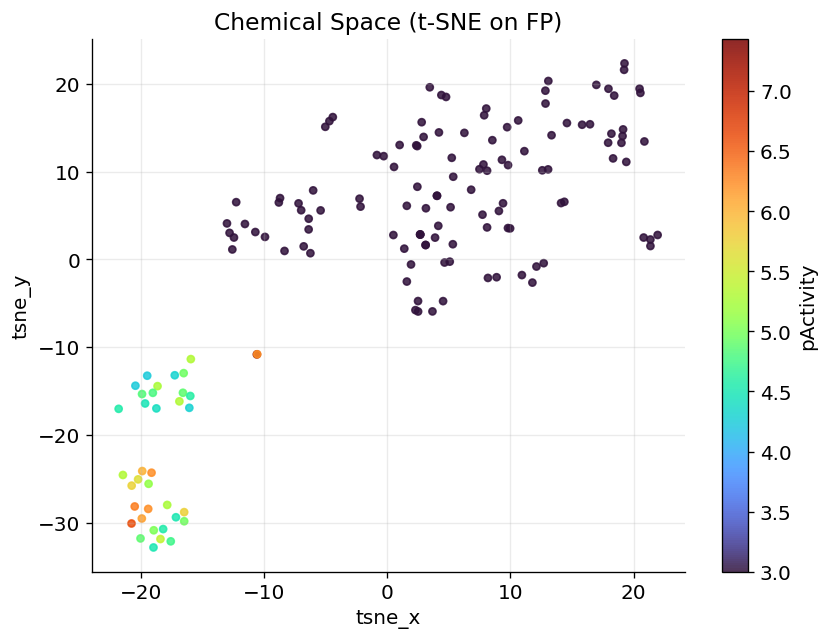

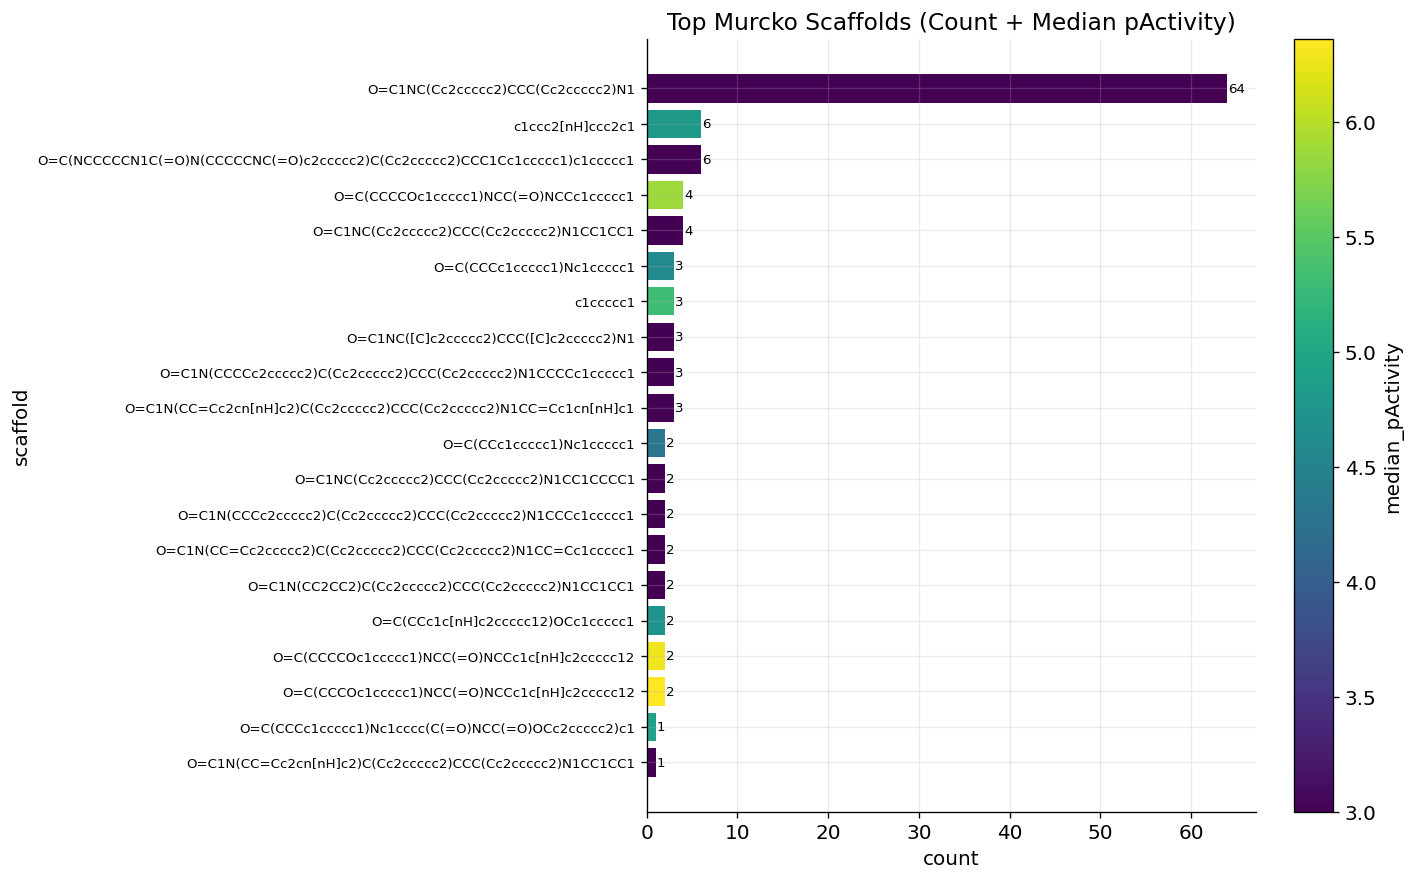

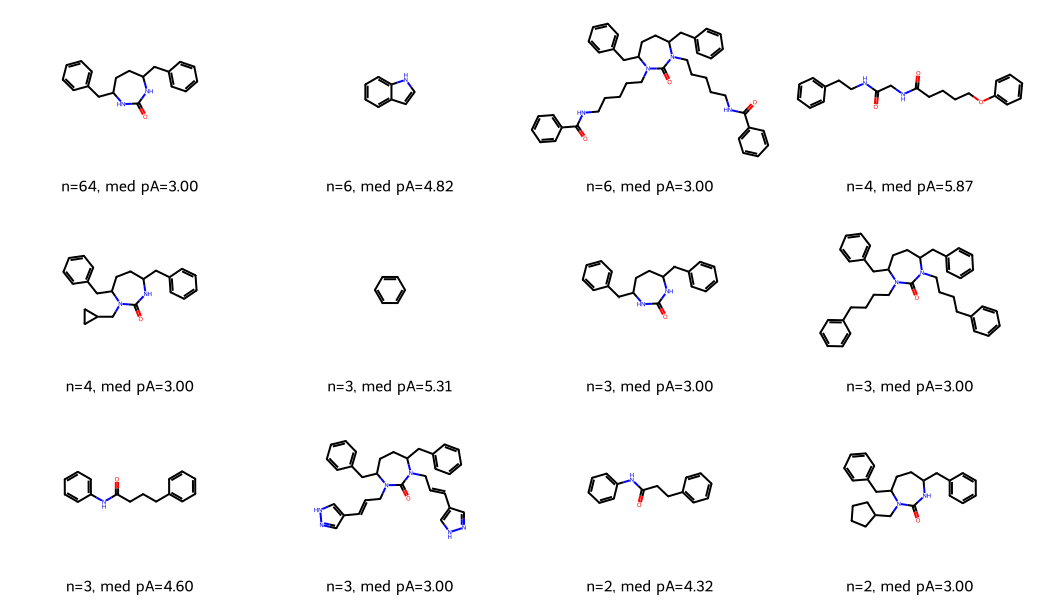

In [6]:
# 标签数据：ERAP2_BindingDB.tsv → pActivity；并可生成与活性样本等量的低相似度 decoy
labels_cache_dir = DATA / "labels" / target.target_id
labels_cache_dir.mkdir(parents=True, exist_ok=True)

labels_norm = None
labels_source_note = None

if ERAP2_BINDINGDB_TSV.exists():
    bdb = pd.read_csv(ERAP2_BINDINGDB_TSV, sep="\t")
    bdb = bdb.rename(
        columns={
            "BindingDB Reactant_set_id": "bindingdb_id",
            "Ligand SMILES": "smiles",
            "Target Name": "target_name",
            "Activity (nM)": "activity_nM",
        }
    )
    bdb["activity_nM"] = pd.to_numeric(bdb.get("activity_nM"), errors="coerce")
    bdb = bdb.dropna(subset=["smiles", "activity_nM"]).reset_index(drop=True)

    raw = pd.DataFrame(
        {
            "ligand_id": bdb.get("bindingdb_id", pd.Series(bdb.index.astype(str))).astype(str),
            "smiles": bdb["smiles"].astype(str),
            "measurement_type": "Activity",
            "relation": "=",
            "value": bdb["activity_nM"].astype(float),
            "unit": "nM",
        }
    )
    raw = raw.dropna(subset=["smiles", "value", "unit"]).reset_index(drop=True)
    labels_norm = s2d.normalize_label_table(raw, target_id=target.target_id, source="ERAP2_BindingDB")
    labels_source_note = "ERAP2_BindingDB"

    # 阴性对照：从 BindingDB_All.tsv 生成与活性样本等量、低相似度 decoy
    if (
        "RUN_BINDINGDB_DECOY_GEN" in globals()
        and RUN_BINDINGDB_DECOY_GEN
        and BINDINGDB_TSV.exists()
        and labels_norm is not None
        and not labels_norm.empty
    ):
        actives = (
            labels_norm.loc[
                labels_norm["value_nM"].astype(float) <= float(BINDINGDB_ACTIVE_THRESHOLD_NM),
                "smiles",
            ]
            .dropna()
            .astype(str)
            .unique()
            .tolist()
        )
        if len(actives) < 10:
            actives = labels_norm["smiles"].dropna().astype(str).unique().tolist()

        n_decoys = int(len(actives))
        if N_DECOYS is not None:
            try:
                v = int(N_DECOYS)
                if v > 0:
                    n_decoys = v
            except Exception:
                pass

        if n_decoys > 0 and actives:
            import hashlib

            act_key = hashlib.sha1("||".join(sorted(set(actives))).encode("utf-8")).hexdigest()[:8]
            decoys_cache = (
                labels_cache_dir
                / f"decoys_bindingdb_sim{DECOY_SIMILARITY_MAX}_n{n_decoys}_a{act_key}.parquet"
            )
            if decoys_cache.exists():
                decoys_raw = pd.read_parquet(decoys_cache)
            elif decoys_cache.with_suffix(".csv").exists():
                decoys_raw = pd.read_csv(decoys_cache.with_suffix(".csv"))
            else:
                decoys_raw = s2d.bindingdb_generate_low_similarity_decoys(
                    BINDINGDB_TSV,
                    active_smiles=actives,
                    n_decoys=n_decoys,
                    similarity_max=DECOY_SIMILARITY_MAX,
                    inactive_value_nM=DECOY_INACTIVE_VALUE_NM,
                    exclude_target_name_contains=BINDINGDB_TARGET_NAME,
                    exclude_smiles=labels_norm["smiles"].dropna().astype(str).unique().tolist(),
                    seed=0,
                )
                s2d.safe_to_parquet(decoys_raw, decoys_cache)

            if decoys_raw is None or decoys_raw.empty:
                print("No decoys generated; continue without decoys.")
            else:
                decoys_norm = s2d.normalize_label_table(decoys_raw, target_id=target.target_id, source="DECOY")
                labels_norm = pd.concat([labels_norm, decoys_norm], ignore_index=True)

elif RUN_BINDINGDB_EXTRACT and BINDINGDB_TSV.exists():
    # 缓存：避免每次对 BindingDB_All.tsv 进行全量扫描（约 6.6GB）
    bindingdb_cache = labels_cache_dir / "bindingdb_raw.parquet"
    if bindingdb_cache.exists():
        bindingdb_raw = pd.read_parquet(bindingdb_cache)
    elif bindingdb_cache.with_suffix(".csv").exists():
        bindingdb_raw = pd.read_csv(bindingdb_cache.with_suffix(".csv"))
    else:
        bindingdb_raw = s2d.bindingdb_extract_by_target(
            BINDINGDB_TSV,
            target_name=BINDINGDB_TARGET_NAME,
            organism_contains=BINDINGDB_ORGANISM_CONTAINS,
            limit=BINDINGDB_LIMIT,
        )
        s2d.safe_to_parquet(bindingdb_raw, bindingdb_cache)

    if bindingdb_raw.empty:
        print("BindingDB target extract returned empty; using synthetic example labels.")
    else:
        labels_norm = s2d.normalize_label_table(bindingdb_raw, target_id=target.target_id, source="BindingDB")
        labels_source_note = "BindingDB"

if labels_norm is None or labels_norm.empty:
    example_labels = pd.DataFrame(
        [
            {"ligand_id": "L1", "smiles": "CCO", "measurement_type": "IC50", "value": 120, "unit": "nM"},
            {"ligand_id": "L1", "smiles": "CCO", "measurement_type": "IC50", "value": 200, "unit": "nM"},
            {"ligand_id": "L2", "smiles": "c1ccccc1", "measurement_type": "Ki", "value": 3.2, "unit": "uM"},
            {"ligand_id": "L3", "smiles": "CCN", "measurement_type": "Kd", "value": 40, "unit": "nM"},
            {"ligand_id": "L4", "smiles": "O=C(O)C1=CC=CC=C1", "measurement_type": "IC50", "value": 1.5, "unit": "uM"},
            {"ligand_id": "L5", "smiles": "CC(C)N", "measurement_type": "IC50", "value": 900, "unit": "nM"},
        ]
    )
    labels_norm = s2d.normalize_label_table(example_labels, target_id=target.target_id, source="synthetic_example")
    labels_source_note = "synthetic_example"

labels_agg = s2d.aggregate_duplicates(labels_norm.drop(columns=["ligand_id"], errors="ignore"))

labels_dir = DATA / "labels" / target.target_id
labels_path = s2d.safe_to_parquet(labels_agg, labels_dir / "labels.parquet")

# 训练/QSAR/affinity 统一标签视图（以去重后的 labels_agg 为主）
labels_bindingdb = labels_agg.copy()
labels_bindingdb["activity_nM"] = np.power(10.0, 9.0 - labels_bindingdb["pActivity"].astype(float))
labels_bindingdb["is_active"] = (
    labels_bindingdb["activity_nM"].astype(float) <= float(BINDINGDB_ACTIVE_THRESHOLD_NM)
).astype(int)
if "sources" in labels_bindingdb.columns:
    src = labels_bindingdb["sources"].astype(str)
    labels_bindingdb["source"] = np.where(src.str.contains("DECOY", na=False), "DECOY", "ERAP2_BindingDB")
else:
    labels_bindingdb["source"] = "ERAP2_BindingDB"

labels_affinity = labels_bindingdb.copy()
labels_qsar = labels_bindingdb.copy()

print(
    {
        "labels_source": labels_source_note,
        "labels_norm": getattr(labels_norm, "shape", None),
        "labels_agg": getattr(labels_agg, "shape", None),
        "unique_smiles": int(labels_norm["smiles"].nunique()) if labels_norm is not None else 0,
        "sources": labels_norm["source"].value_counts().to_dict()
        if labels_norm is not None and "source" in labels_norm.columns
        else {},
    }
)

# ===== 数据分布可视化（多维度统计） =====
plot_df = labels_norm.dropna(subset=["smiles", "pActivity"]).copy()
if len(plot_df) > PLOT_MAX_POINTS:
    plot_df = plot_df.sample(n=PLOT_MAX_POINTS, random_state=0)

# 1) 活性分布（直方 + violin）
try:
    pa = plot_df["pActivity"].astype(float).to_numpy()
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.2))

    axes[0].hist(pa, bins=50, color=S2D_COLORWAY[0], alpha=0.9)
    axes[0].set_title("pActivity histogram")
    axes[0].set_xlabel("pActivity")
    axes[0].set_ylabel("count")

    parts = axes[1].violinplot(pa, showmeans=True, showmedians=False, showextrema=False)
    for b in parts.get("bodies", []):
        b.set_facecolor(S2D_COLORWAY[1])
        b.set_alpha(0.55)
    if "cmeans" in parts:
        parts["cmeans"].set_color(S2D_COLORWAY[3])
    axes[1].set_title("pActivity violin")
    axes[1].set_ylabel("pActivity")
    axes[1].set_xticks([])

    fig.suptitle("ERAP2 Activity Distribution")
    savefig(fig, FIG_DIR / "eda_activity_distribution.png")
    plt.show()
except Exception as e:
    print("Skip activity distribution plots:", repr(e))

# 2) 关系符号/来源
if "relation" in plot_df.columns:
    try:
        # relation 在 DECOY 等合成数据中可能缺失；统一填充避免出现 "nan" 作为刻度
        rel = plot_df["relation"].copy()
        rel = rel.fillna("=").astype(str).str.strip()
        rel = rel.replace({"nan": "=", "None": "=", "": "="})
        tab = pd.crosstab(rel, plot_df["source"].astype(str))
        fig, ax = plt.subplots(figsize=(10, 4.2))
        tab.plot(kind="bar", ax=ax, color=[S2D_COLORWAY[i % len(S2D_COLORWAY)] for i in range(tab.shape[1])])
        ax.set_title("Relation Symbols by Source")
        ax.set_xlabel("relation")
        ax.set_ylabel("count")
        ax.legend(title="source", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
        savefig(fig, FIG_DIR / "eda_relation_by_source.png")
        plt.show()
    except Exception as e:
        print("Skip relation-by-source plot:", repr(e))

# 3) DECOY 相似度分布
if "max_sim_to_active" in plot_df.columns and (plot_df["source"] == "DECOY").any():
    try:
        vals = (
            plot_df.loc[plot_df["source"] == "DECOY", "max_sim_to_active"]
            .dropna()
            .astype(float)
            .to_numpy()
        )
        if len(vals):
            fig, ax = plt.subplots(figsize=(7.2, 4.2))
            ax.hist(vals, bins=50, color=S2D_COLORWAY[2], alpha=0.9)
            ax.set_title(f"Decoy Max Similarity to Actives (<= {DECOY_SIMILARITY_MAX})")
            ax.set_xlabel("max_sim_to_active")
            ax.set_ylabel("count")
            savefig(fig, FIG_DIR / "eda_decoy_similarity.png")
            plt.show()
    except Exception as e:
        print("Skip decoy similarity plot:", repr(e))

# 4) 物化性质 + 化学空间（PCA/t-SNE）+ scaffold
try:
    import matplotlib as mpl
    from rdkit import Chem
    from rdkit.Chem import Crippen, Descriptors, Lipinski, Draw
    from rdkit.Chem.Scaffolds import MurckoScaffold
    from IPython.display import display
    from sklearn.decomposition import PCA

    mol_tab = (
        labels_norm.dropna(subset=["smiles", "pActivity"])
        .groupby("smiles", as_index=False)
        .agg(
            pActivity=("pActivity", "median"),
            sources=("source", lambda x: "|".join(sorted(set(map(str, x))))),
        )
    )
    if len(mol_tab) > PLOT_MAX_POINTS:
        mol_tab = mol_tab.sample(n=PLOT_MAX_POINTS, random_state=0).reset_index(drop=True)

    def _desc(smi: str):
        m = Chem.MolFromSmiles(str(smi))
        if m is None:
            return None
        return {
            "smiles": Chem.MolToSmiles(m),
            "MW": float(Descriptors.MolWt(m)),
            "logP": float(Crippen.MolLogP(m)),
            "TPSA": float(Descriptors.TPSA(m)),
            "HBD": int(Lipinski.NumHDonors(m)),
            "HBA": int(Lipinski.NumHAcceptors(m)),
            "RotB": int(Lipinski.NumRotatableBonds(m)),
            "RingCount": int(Lipinski.RingCount(m)),
        }

    desc_rows = []
    for smi in mol_tab["smiles"].astype(str).tolist():
        r = _desc(smi)
        if r is not None:
            desc_rows.append(r)
    desc_df = pd.DataFrame(desc_rows)
    mol_tab = mol_tab.merge(desc_df, on="smiles", how="inner")

    # 4.1 描述符分布
    for col in ["MW", "logP", "TPSA", "HBD", "HBA", "RotB", "RingCount"]:
        try:
            fig, ax = plt.subplots(figsize=(8.5, 4.2))
            for i, (src, g) in enumerate(mol_tab.groupby("sources")):
                ax.hist(
                    g[col].astype(float).to_numpy(),
                    bins=40,
                    alpha=0.45,
                    label=str(src),
                    color=S2D_COLORWAY[i % len(S2D_COLORWAY)],
                )
            ax.set_title(f"{col} Distribution")
            ax.set_xlabel(col)
            ax.set_ylabel("count")
            if mol_tab["sources"].nunique() > 1:
                ax.legend(fontsize=8)
            savefig(fig, FIG_DIR / f"eda_desc_{col}.png")
            plt.show()
        except Exception as e:
            print(f"Skip {col} histogram:", repr(e))

    try:
        fig, ax = plt.subplots(figsize=(7.2, 5.2))
        sc = ax.scatter(
            mol_tab["MW"].astype(float),
            mol_tab["logP"].astype(float),
            c=mol_tab["pActivity"].astype(float),
            cmap="viridis",
            s=20,
            alpha=0.85,
        )
        ax.set_title("MW vs logP (Color=pActivity)")
        ax.set_xlabel("MW")
        ax.set_ylabel("logP")
        fig.colorbar(sc, ax=ax, label="pActivity")
        savefig(fig, FIG_DIR / "eda_mw_logp.png")
        plt.show()
    except Exception as e:
        print("Skip MW vs logP scatter:", repr(e))

    try:
        from pandas.plotting import scatter_matrix

        sm_df = mol_tab[["MW", "logP", "TPSA", "RingCount"]].copy()
        if len(sm_df) > 1000:
            sm_df = sm_df.sample(n=1000, random_state=0).reset_index(drop=True)
        axs = scatter_matrix(sm_df, figsize=(10, 10), diagonal="hist", alpha=0.5)
        fig = axs[0, 0].get_figure()
        fig.suptitle("Descriptor Pairplot", y=1.02)
        savefig(fig, FIG_DIR / "eda_desc_pairplot.png")
        plt.show()
    except Exception as e:
        print("Skip scatter_matrix:", repr(e))

    # 4.2 化学空间（FP PCA + t-SNE）
    fps = []
    rows = []
    for smi, src, pa in mol_tab[["smiles", "sources", "pActivity"]].itertuples(index=False, name=None):
        m = Chem.MolFromSmiles(str(smi))
        if m is None:
            continue
        fp = s2d.morgan_fp_bits(m, n_bits=256)
        fps.append(fp)
        rows.append({"smiles": smi, "sources": src, "pActivity": float(pa)})

    if fps:
        X = np.stack(fps, axis=0)
        cs = pd.DataFrame(rows)

        xy = PCA(n_components=2, random_state=0).fit_transform(X)
        cs["pca_x"] = xy[:, 0]
        cs["pca_y"] = xy[:, 1]
        try:
            fig, ax = plt.subplots(figsize=(7.2, 5.5))
            sc = ax.scatter(
                cs["pca_x"].astype(float),
                cs["pca_y"].astype(float),
                c=cs["pActivity"].astype(float),
                cmap="turbo",
                s=18,
                alpha=0.85,
            )
            ax.set_title("Chemical Space (FP PCA)")
            ax.set_xlabel("pca_x")
            ax.set_ylabel("pca_y")
            fig.colorbar(sc, ax=ax, label="pActivity")
            savefig(fig, FIG_DIR / "eda_fp_pca.png")
            plt.show()
        except Exception as e:
            print("Skip FP PCA plot:", repr(e))

        try:
            from sklearn.manifold import TSNE

            if X.shape[0] <= 2000:
                tsne = TSNE(
                    n_components=2,
                    perplexity=min(30, max(5, X.shape[0] // 10)),
                    init="pca",
                    learning_rate="auto",
                    random_state=0,
                )
                xy2 = tsne.fit_transform(X)
                cs["tsne_x"] = xy2[:, 0]
                cs["tsne_y"] = xy2[:, 1]
                try:
                    fig, ax = plt.subplots(figsize=(7.2, 5.5))
                    sc = ax.scatter(
                        cs["tsne_x"].astype(float),
                        cs["tsne_y"].astype(float),
                        c=cs["pActivity"].astype(float),
                        cmap="turbo",
                        s=18,
                        alpha=0.85,
                    )
                    ax.set_title("Chemical Space (t-SNE on FP)")
                    ax.set_xlabel("tsne_x")
                    ax.set_ylabel("tsne_y")
                    fig.colorbar(sc, ax=ax, label="pActivity")
                    savefig(fig, FIG_DIR / "eda_fp_tsne.png")
                    plt.show()
                except Exception as e:
                    print("Skip t-SNE plot:", repr(e))
        except Exception as e:
            print("Skip t-SNE:", repr(e))

    # 4.3 Murcko scaffold
    scaffolds = []
    for smi in mol_tab["smiles"].astype(str).tolist():
        m = Chem.MolFromSmiles(smi)
        if m is None:
            scaffolds.append(None)
            continue
        try:
            scaffolds.append(MurckoScaffold.MurckoScaffoldSmiles(mol=m))
        except Exception:
            scaffolds.append(None)

    sc_df = mol_tab.copy()
    sc_df["scaffold"] = scaffolds
    sc_stat = (
        sc_df.dropna(subset=["scaffold"])
        .groupby("scaffold", as_index=False)
        .agg(n=("scaffold", "size"), median_pActivity=("pActivity", "median"))
    )
    sc_stat = sc_stat.sort_values("n", ascending=False).head(20)
    if not sc_stat.empty:
        try:
            sc_stat_plot = sc_stat.sort_values("n", ascending=True).copy()
            fig, ax = plt.subplots(figsize=(12, 7.5))
            norm = mpl.colors.Normalize(
                vmin=float(sc_stat_plot["median_pActivity"].min()),
                vmax=float(sc_stat_plot["median_pActivity"].max()),
            )
            colors = mpl.cm.viridis(norm(sc_stat_plot["median_pActivity"].astype(float).to_numpy()))
            bars = ax.barh(sc_stat_plot["scaffold"].astype(str), sc_stat_plot["n"].astype(int), color=colors)
            ax.set_title("Top Murcko Scaffolds (Count + Median pActivity)")
            ax.set_xlabel("count")
            ax.set_ylabel("scaffold")
            ax.tick_params(axis="y", labelsize=8)
            for b in bars:
                w = b.get_width()
                ax.text(w + 0.1, b.get_y() + b.get_height() / 2.0, f"{int(w)}", va="center", fontsize=8)
            sm = mpl.cm.ScalarMappable(norm=norm, cmap="viridis")
            sm.set_array([])
            fig.colorbar(sm, ax=ax, label="median_pActivity")
            savefig(fig, FIG_DIR / "eda_scaffold_bar.png")
            plt.show()
        except Exception as e:
            print("Skip scaffold bar plot:", repr(e))

        top_scaf = sc_stat.head(12)
        mols = []
        legends = []
        for _, r in top_scaf.iterrows():
            m = Chem.MolFromSmiles(str(r["scaffold"]))
            if m is None:
                continue
            mols.append(m)
            legends.append(f"n={int(r['n'])}, med pA={float(r['median_pActivity']):.2f}")
        if mols:
            img = Draw.MolsToGridImage(mols, legends=legends, molsPerRow=4, subImgSize=(260, 200))
            display(img)
            try:
                img.save(FIG_DIR / "eda_top_scaffolds.png")
            except Exception:
                pass

except Exception as e:
    print("Skip RDKit advanced EDA:", repr(e))


In [7]:
# ===== ERAP2 BindingDB（训练/QSAR/affinity；可生成等量 decoy） =====
labels_bindingdb = None
labels_affinity = None
labels_qsar = None

try:
    if ERAP2_BINDINGDB_TSV.exists():
        bdb = pd.read_csv(ERAP2_BINDINGDB_TSV, sep="\t")
        bdb = bdb.rename(
            columns={
                "BindingDB Reactant_set_id": "bindingdb_id",
                "Ligand SMILES": "smiles",
                "Target Name": "target_name",
                "Activity (nM)": "activity_nM",
            }
        )
        bdb["activity_nM"] = pd.to_numeric(bdb.get("activity_nM"), errors="coerce")
        bdb = bdb.dropna(subset=["smiles", "activity_nM"]).reset_index(drop=True)

        from rdkit import Chem

        def _canon(s: str):
            m = Chem.MolFromSmiles(str(s))
            if m is None:
                return None
            return Chem.MolToSmiles(m)

        bdb["smiles_canon"] = [_canon(s) for s in bdb["smiles"].astype(str).tolist()]
        bdb = bdb.dropna(subset=["smiles_canon"]).reset_index(drop=True)

        labels_bindingdb = (
            bdb.groupby("smiles_canon", as_index=False)
            .agg(activity_nM=("activity_nM", "median"), n_measurements=("activity_nM", "size"))
            .rename(columns={"smiles_canon": "smiles"})
        )
        labels_bindingdb["pActivity"] = 9.0 - np.log10(labels_bindingdb["activity_nM"].astype(float))
        labels_bindingdb["is_active"] = (
            labels_bindingdb["activity_nM"].astype(float) <= float(BINDINGDB_ACTIVE_THRESHOLD_NM)
        ).astype(int)
        labels_bindingdb["source"] = "ERAP2_BindingDB"
        labels_bindingdb["target_id"] = target.target_id
    else:
        print("Missing ERAP2_BINDINGDB_TSV:", ERAP2_BINDINGDB_TSV)
except Exception as e:
    print("BindingDB label build failed:", repr(e))
    labels_bindingdb = None

# 训练用：为 ERAP2_BindingDB 活性样本生成等量低相似度 decoy（分块扫描 BindingDB_All.tsv；结果缓存到 data/labels/<target_id>/）
if (
    "RUN_BINDINGDB_DECOY_GEN" in globals()
    and RUN_BINDINGDB_DECOY_GEN
    and labels_bindingdb is not None
    and not labels_bindingdb.empty
    and BINDINGDB_TSV.exists()
):
    actives = (
        labels_bindingdb.loc[labels_bindingdb["is_active"] == 1, "smiles"]
        .dropna()
        .astype(str)
        .unique()
        .tolist()
    )
    if len(actives) < 10:
        actives = labels_bindingdb["smiles"].dropna().astype(str).unique().tolist()

    n_decoys = int(len(actives))
    if N_DECOYS is not None:
        try:
            v = int(N_DECOYS)
            if v > 0:
                n_decoys = v
        except Exception:
            pass

    if n_decoys > 0 and actives:
        labels_cache_dir = DATA / "labels" / target.target_id
        labels_cache_dir.mkdir(parents=True, exist_ok=True)

        import hashlib

        act_key = hashlib.sha1("||".join(sorted(set(actives))).encode("utf-8")).hexdigest()[:8]
        decoys_cache = labels_cache_dir / f"decoys_bindingdb_sim{DECOY_SIMILARITY_MAX}_n{n_decoys}_a{act_key}.parquet"
        if decoys_cache.exists():
            decoys_raw = pd.read_parquet(decoys_cache)
        elif decoys_cache.with_suffix(".csv").exists():
            decoys_raw = pd.read_csv(decoys_cache.with_suffix(".csv"))
        else:
            decoys_raw = s2d.bindingdb_generate_low_similarity_decoys(
                BINDINGDB_TSV,
                active_smiles=actives,
                n_decoys=n_decoys,
                similarity_max=DECOY_SIMILARITY_MAX,
                inactive_value_nM=DECOY_INACTIVE_VALUE_NM,
                exclude_target_name_contains=BINDINGDB_TARGET_NAME,
                exclude_smiles=labels_bindingdb["smiles"].dropna().astype(str).unique().tolist(),
                seed=0,
            )
            s2d.safe_to_parquet(decoys_raw, decoys_cache)

        if decoys_raw is None or decoys_raw.empty:
            print("No decoys generated for ERAP2_BindingDB; continue without decoys.")
        else:
            dec_df = pd.DataFrame({"smiles": decoys_raw["smiles"].astype(str)})
            dec_df = dec_df.dropna(subset=["smiles"]).drop_duplicates(subset=["smiles"]).reset_index(drop=True)
            dec_df["activity_nM"] = float(DECOY_INACTIVE_VALUE_NM)
            dec_df["n_measurements"] = 1
            dec_df["pActivity"] = 9.0 - np.log10(dec_df["activity_nM"].astype(float))
            dec_df["is_active"] = 0
            dec_df["source"] = "DECOY"
            dec_df["target_id"] = target.target_id
            if "max_sim_to_active" in decoys_raw.columns:
                dec_df["max_sim_to_active"] = pd.to_numeric(decoys_raw["max_sim_to_active"], errors="coerce")
            labels_bindingdb = pd.concat([labels_bindingdb, dec_df], ignore_index=True)

if labels_bindingdb is not None and not labels_bindingdb.empty:
    labels_affinity = labels_bindingdb.copy()
    labels_qsar = labels_bindingdb.copy()
else:
    labels_affinity = labels_agg if "labels_agg" in globals() else None
    labels_qsar = labels_agg if "labels_agg" in globals() else None

print(
    {
        "labels_bindingdb": getattr(labels_bindingdb, "shape", None),
        "labels_affinity": getattr(labels_affinity, "shape", None),
        "labels_qsar": getattr(labels_qsar, "shape", None),
        "bindingdb_active": int(labels_bindingdb["is_active"].sum()) if labels_bindingdb is not None and not labels_bindingdb.empty else None,
        "bindingdb_inactive": int((1 - labels_bindingdb["is_active"]).sum()) if labels_bindingdb is not None and not labels_bindingdb.empty else None,
    }
)


{'labels_bindingdb': (294, 8), 'labels_affinity': (294, 8), 'labels_qsar': (294, 8), 'bindingdb_active': 118, 'bindingdb_inactive': 176}


### （可选）从全量 BindingDB 抽取其它靶点/扩展数据集

当需要构建 ERAP2 以外的靶点数据集，或希望从 `BindingDB_All.tsv` 抽取更大规模的训练标签时，可使用 `state2drug.bindingdb_extract_by_target` 进行流式抽取，并统一规范化为 `pActivity`。

说明：该过程需要扫描大文件，建议通过 `RUN_BINDINGDB_EXTRACT` 开关显式启用，并将结果缓存到 `data/labels/<target_id>/`。


In [8]:
# 1) 从 BindingDB_All.tsv 抽取 target 活性（可选；需要扫描大文件）
if RUN_BINDINGDB_EXTRACT:
    if not BINDINGDB_TSV.exists():
        raise FileNotFoundError(BINDINGDB_TSV)

    labels_cache_dir = DATA / "labels" / target.target_id
    labels_cache_dir.mkdir(parents=True, exist_ok=True)
    bindingdb_cache = labels_cache_dir / "bindingdb_raw.parquet"
    if bindingdb_cache.exists():
        bindingdb_raw = pd.read_parquet(bindingdb_cache)
    elif bindingdb_cache.with_suffix(".csv").exists():
        bindingdb_raw = pd.read_csv(bindingdb_cache.with_suffix(".csv"))
    else:
        bindingdb_raw = s2d.bindingdb_extract_by_target(
            BINDINGDB_TSV,
            target_name=BINDINGDB_TARGET_NAME,
            organism_contains=BINDINGDB_ORGANISM_CONTAINS,
            limit=BINDINGDB_LIMIT,
        )
        s2d.safe_to_parquet(bindingdb_raw, bindingdb_cache)

    bindingdb_raw.head(10), bindingdb_raw.shape
else:
    print("Skip BindingDB extract. Set RUN_BINDINGDB_EXTRACT=True to scan BindingDB_All.tsv.")

Skip BindingDB extract. Set RUN_BINDINGDB_EXTRACT=True to scan BindingDB_All.tsv.


In [9]:
# 2) 规范化抽取结果并保存（可选）
if RUN_BINDINGDB_EXTRACT:
    if "bindingdb_raw" not in globals() or bindingdb_raw is None or bindingdb_raw.empty:
        raise RuntimeError("bindingdb_raw is empty; check the extract step.")

    labels_ext = s2d.normalize_label_table(bindingdb_raw, target_id=target.target_id, source="BindingDB_Extract")
    labels_ext_agg = s2d.aggregate_duplicates(labels_ext.drop(columns=["ligand_id"], errors="ignore"))

    out_dir = DATA / "labels" / target.target_id
    out_path = s2d.safe_to_parquet(labels_ext_agg, out_dir / "bindingdb_extracted.parquet")
    out_path, labels_ext_agg.head(10)
else:
    print("Skip normalization. Set RUN_BINDINGDB_EXTRACT=True first.")

Skip normalization. Set RUN_BINDINGDB_EXTRACT=True first.


In [10]:
# 3) 选择训练标签：使用 labels_bindingdb（ERAP2_BindingDB + decoy）
if "labels_bindingdb" not in globals() or labels_bindingdb is None or labels_bindingdb.empty:
    raise RuntimeError("labels_bindingdb is empty; check Module C label construction.")

labels_train = labels_bindingdb.copy()
labels_train_source = (
    labels_train["source"].value_counts().to_dict() if "source" in labels_train.columns else "unknown"
)

# 训练开销：每条标签需生成 pose；大规模训练可通过抽样、并行化或替换为更快的打分/更小训练规模降低计算成本
labels_model = labels_train.sample(n=min(len(labels_train), int(MAX_TRAIN)), random_state=0).reset_index(drop=True)

{
    "labels_train_source": labels_train_source,
    "labels_train": labels_train.shape,
    "labels_model": labels_model.shape,
}


{'labels_train_source': {'ERAP2_BindingDB': 176, 'DECOY': 118},
 'labels_train': (294, 8),
 'labels_model': (294, 8)}

## 7. 模块D：Pose 生成层（用于训练与精筛）

本版本移除了外部对接相关依赖，`PoseGenConfig.backend` 仅支持 `"geometry"`：

- `POSE_CONFIG_TRAIN`：训练/生成用（速度优先）
- `POSE_CONFIG_COARSE`：筛选粗评估（更快、过滤较松）
- `POSE_CONFIG_FINE`：筛选/证据链精评估（更严：更高 coarse_multiplier、更长 refine、稳定性扰动）

`Pose.pose_quality` 用于下游训练/可视化：

- 基础几何：`min_dist` / `clash_count` / `contact_count` / `mean_closest_dist`
- 稳定性 proxy：`stability_ok_frac`（局部扰动鲁棒性，作为“短 MD 稳定性”的轻量近似）
- 关键相互作用 proxy：`anchor_match_count/anchor_total`（从代表复合物的共结晶配体提取极性 anchor 点）
- 派生辅助分数：`interaction_score = contact_count - clash_count`（用于模型的 pose_aux 特征）


In [11]:
lig = s2d.Ligand.from_smiles("O=C(O)C1=CC=CC=C1", ligand_id="example_lig")

pose_rows = []
for cfg_name, cfg in [
    ("train_geometry", POSE_CONFIG_TRAIN),
    ("coarse_geometry", POSE_CONFIG_COARSE),
    ("fine_geometry", POSE_CONFIG_FINE),
]:
    try:
        poses = s2d.generate_poses_for_state(lig, states[0], num_poses=3, seed=0, pose_config=cfg)
        for p in poses:
            q = p.pose_quality
            try:
                interaction_score = float(q.get("contact_count", 0.0)) - float(q.get("clash_count", 0.0))
            except Exception:
                interaction_score = float("nan")
            pose_rows.append(
                {
                    "config": cfg_name,
                    "pose_id": p.pose_id,
                    "stage": q.get("stage"),
                    "interaction_score": interaction_score,
                    "min_dist": q.get("min_dist"),
                    "clash_count": q.get("clash_count"),
                    "contact_count": q.get("contact_count"),
                    "mean_closest_dist": q.get("mean_closest_dist"),
                    "anchor_match_count": q.get("anchor_match_count"),
                    "anchor_total": q.get("anchor_total"),
                    "stability_ok_frac": q.get("stability_ok_frac"),
                }
            )
    except Exception as e:
        pose_rows.append({"config": cfg_name, "error": repr(e)})

pd.DataFrame(pose_rows)


,config,pose_id,stage,interaction_score,min_dist,clash_count,contact_count,mean_closest_dist,anchor_match_count,anchor_total,stability_ok_frac
0,train_geometry,pose_00_example_lig_00,refined,15.0,1.628174,0,15,2.099354,0,8,NaN
1,train_geometry,pose_00_example_lig_01,refined,15.0,1.551010,0,15,2.172755,0,8,NaN
2,train_geometry,pose_00_example_lig_02,refined,15.0,1.515684,0,15,2.257034,0,8,NaN
3,coarse_geometry,pose_00_example_lig_00,refined,15.0,1.628174,0,15,2.099354,0,8,NaN
4,coarse_geometry,pose_00_example_lig_01,refined,15.0,1.551010,0,15,2.172755,0,8,NaN
5,coarse_geometry,pose_00_example_lig_02,refined,15.0,1.515684,0,15,2.257034,0,8,NaN
6,fine_geometry,pose_00_example_lig_00,refined,15.0,1.612509,0,15,2.115128,0,8,0.875
7,fine_geometry,pose_00_example_lig_01,refined,15.0,1.603419,0,15,2.351712,0,8,0.625
8,fine_geometry,pose_00_example_lig_02,refined,15.0,1.519862,0,15,2.784905,0,8,0.500


## 8. 模块E：状态条件化打分模型（主模型：Torch SE(3) 等变网络）

目标：对同一分子在不同 pocket states 下的结合/活性趋势给出预测，并输出可解释的 state 偏好谱。

当前实现（与 `state2drug.py` 一致）：

- 输入：每个 state 的 pocket 原子坐标 + 该 state 下的 ligand pose 坐标（几何 pose）
- 模型：SE(3)-equivariant EGNN 编码 protein–ligand 复合物图，并用 MIL attention 聚合多个 state/pose 实例
- 特征：3D 坐标 + 元素类型/键 + `Pose.pose_quality`（contact/clash、anchor、stability 等；并派生 `interaction_score`）+ state embedding
- 输出：
  - `main_score`：跨 states 聚合后的预测 pActivity
  - `state_profile`：每个 state 的单独预测（解释“偏好哪些构象状态”）

依赖：需要 `torch`。若出现 `ModuleNotFoundError: No module named 'torch'`，可用 CPU 版安装并重启 kernel：

```bash
python3 -m pip install --user --upgrade torch --index-url https://download.pytorch.org/whl/cpu --extra-index-url https://pypi.org/simple
```


{'unique_smiles': 294, 'train': 235, 'test': 59, 'pose_backend': 'geometry'}
[se3_score] trained 2D baseline: ExtraTrees | n=235 | fp_bits=2048


SE3 dataset:   0%|          | 0/235 [00:00<?, ?it/s]

[se3_score] epoch 001 | train_mse=0.1258 val_mse=0.1495 val_rmse=0.387 val_mae=0.182
[se3_score] epoch 002 | train_mse=0.1257 val_mse=0.1486 val_rmse=0.386 val_mae=0.180
[se3_score] epoch 003 | train_mse=0.1220 val_mse=0.1513 val_rmse=0.389 val_mae=0.186
[se3_score] epoch 004 | train_mse=0.1269 val_mse=0.1473 val_rmse=0.384 val_mae=0.189
[se3_score] epoch 005 | train_mse=0.1239 val_mse=0.1475 val_rmse=0.384 val_mae=0.183
[se3_score] epoch 006 | train_mse=0.1254 val_mse=0.1473 val_rmse=0.384 val_mae=0.186
[se3_score] epoch 007 | train_mse=0.1249 val_mse=0.1486 val_rmse=0.385 val_mae=0.180
[se3_score] epoch 008 | train_mse=0.1228 val_mse=0.1478 val_rmse=0.384 val_mae=0.179
[se3_score] epoch 009 | train_mse=0.1262 val_mse=0.1475 val_rmse=0.384 val_mae=0.196
[se3_score] epoch 010 | train_mse=0.1265 val_mse=0.1477 val_rmse=0.384 val_mae=0.180
[se3_score] epoch 011 | train_mse=0.1249 val_mse=0.1475 val_rmse=0.384 val_mae=0.182
[se3_score] epoch 012 | train_mse=0.1244 val_mse=0.1486 val_rmse=

{'main_score': 4.283380959366931,
 'state_profile': {'00': 4.2835946643701925,
  '01': 4.283039894138946,
  '02': 4.283594925140513,
  '03': 4.283308740889205,
  '04': 4.283569678848161,
  '05': 4.283179480766429},
 'pose_summary': {'pose_contact_count_mean': 15.0,
  'pose_contact_count_best': 15.0,
  'pose_clash_count_mean': 0.0,
  'pose_clash_count_best': 0.0,
  'pose_min_dist_mean': 1.5750678380330403,
  'pose_min_dist_best': 1.5047653913497925,
  'pose_mean_closest_dist_mean': 2.1722873051961265,
  'pose_mean_closest_dist_best': 2.018890619277954,
  'pose_anchor_match_count_mean': 0.0,
  'pose_anchor_match_count_best': 0.0,
  'pose_anchor_match_frac_mean': 0.0,
  'pose_anchor_match_frac_best': 0.0,
  'pose_interaction_score_mean': 15.0,
  'pose_interaction_score_best': 15.0},
 'baseline_score': 4.256522003745212}

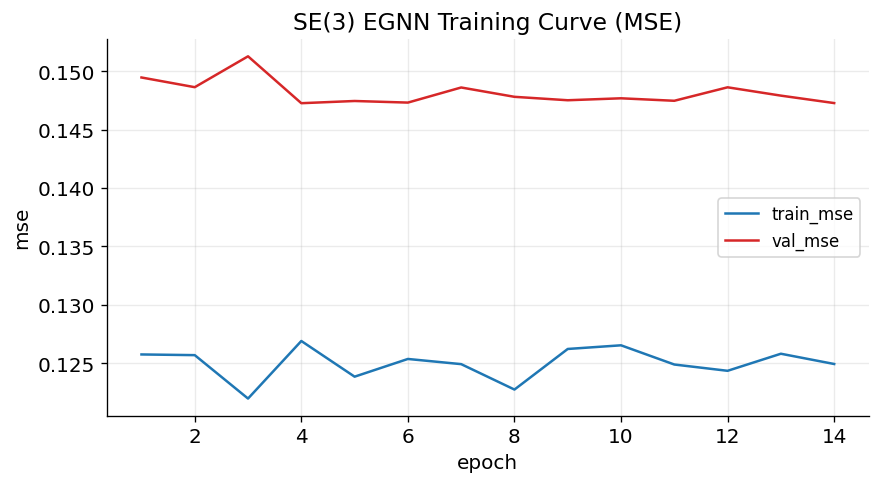

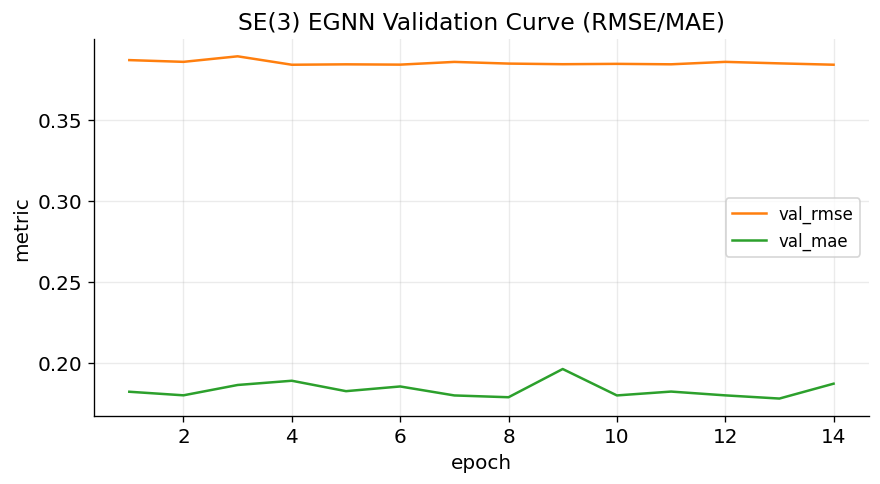

[train] ok=200/200
[train] rmse=0.245 mae=0.144


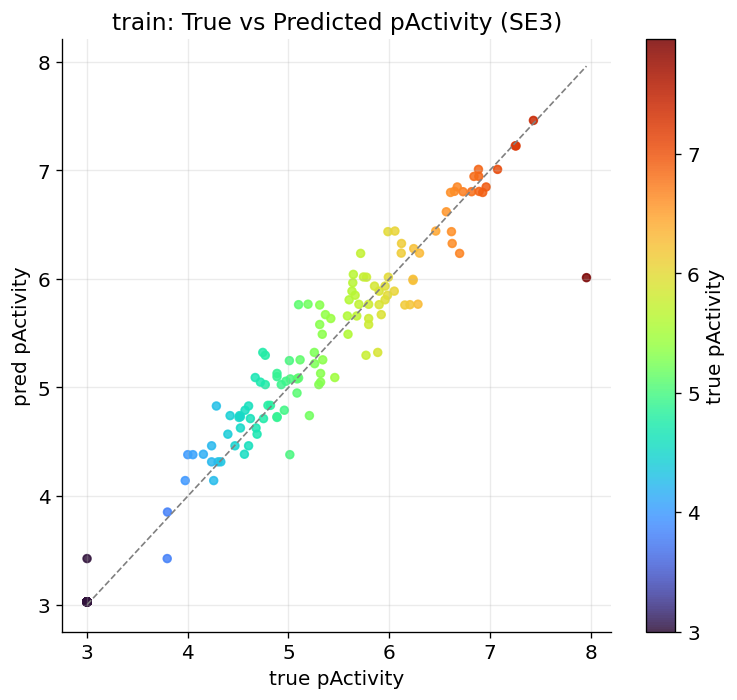

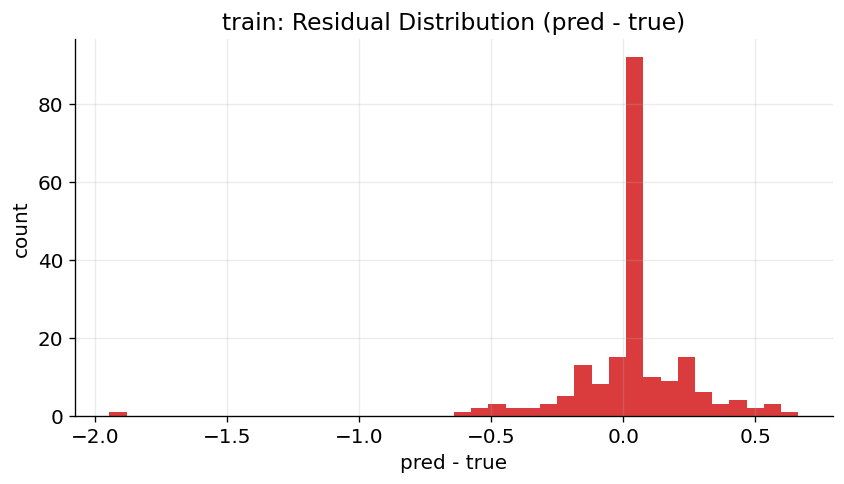

[test] ok=59/59
[test] rmse=0.441 mae=0.282


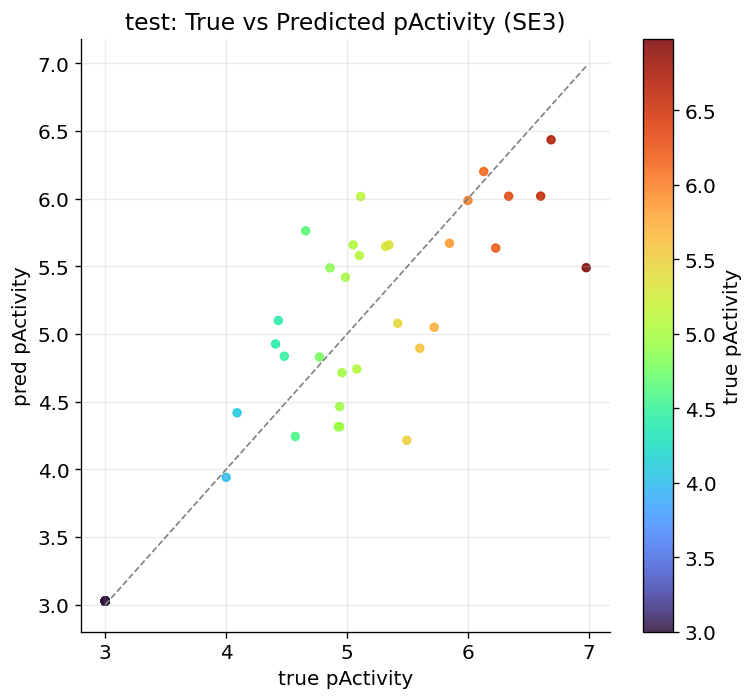

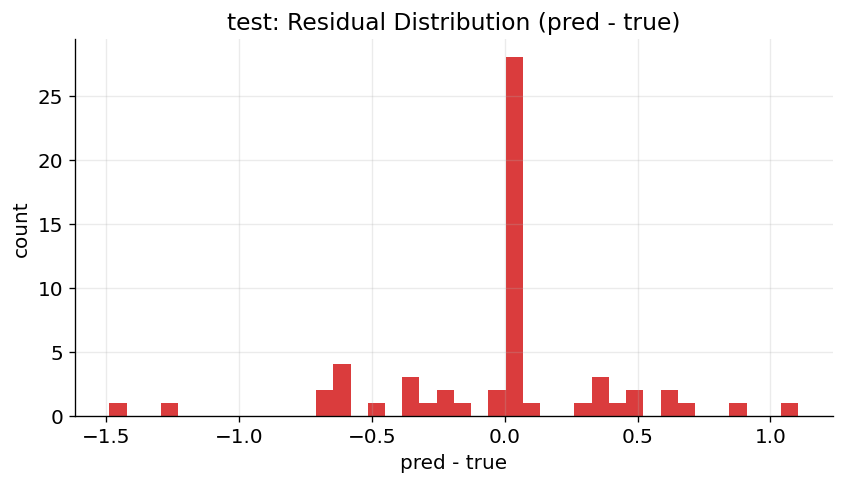

{'train': {'rmse': 0.24514101149321216, 'mae': 0.14407674519655644},
 'test': {'rmse': 0.4412569233884327, 'mae': 0.2819584157531572}}

In [12]:
# ===== 主模型（Torch SE(3) EGNN + MIL attention；需要 torch；CPU 也可运行） =====
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

STATE_EMB_DIM = len(states[0].features.get("embedding", []))
# 版本控制：避免加载旧模型导致预测退化为常数（例如缺少 baseline 校准）
SCORE_MODEL_PATH = RUN_DIR / "se3_score_model_hybrid.pt"
HIST_PATH = RUN_DIR / "se3_training_history_hybrid.csv"

# 用于强制重新训练
FORCE_RETRAIN_SE3 = False

# 训练 pose：使用几何后端
POSE_CONFIG_SCORE_TRAIN = POSE_CONFIG_TRAIN

# 去重（按 SMILES 聚合）并进行 Train/Test 划分（用于过拟合评估）
label_df = labels_model.dropna(subset=["smiles", "pActivity"]).copy()
label_df["smiles"] = label_df["smiles"].astype(str)
label_df["pActivity"] = pd.to_numeric(label_df["pActivity"], errors="coerce")
label_df = label_df.dropna(subset=["pActivity"]).groupby("smiles", as_index=False).agg(pActivity=("pActivity", "median"))

train_df, test_df = train_test_split(label_df, test_size=0.20, random_state=0, shuffle=True)
print({
    "unique_smiles": int(len(label_df)),
    "train": int(len(train_df)),
    "test": int(len(test_df)),
    "pose_backend": str(getattr(POSE_CONFIG_SCORE_TRAIN, "backend", "?")),
})

hist = None
if SCORE_MODEL_PATH.exists() and not FORCE_RETRAIN_SE3:
    score_model = s2d.SE3ScoreModel.load(SCORE_MODEL_PATH, device="cuda")
    if HIST_PATH.exists():
        try:
            hist = pd.read_csv(HIST_PATH)
        except Exception:
            hist = None
else:
    score_model_train = s2d.SE3ScoreModel(
        state_emb_dim=int(STATE_EMB_DIM),
        # 通过减小模型容量并增大 dropout 缓解过拟合
        dim=160,
        n_layers=4,
        k_nn=32,
        radius=9.0,
        dropout=0.20,
        device="cuda" if torch.cuda.is_available() else "cpu",
    )

    score_model_train.fit_from_labeled_ligands(
        train_df,
        states=states,
        poses_per_state=2,
        max_states_per_ligand=min(10, len(states)),
        pose_config=POSE_CONFIG_SCORE_TRAIN,
        seed=0,
        n_jobs=HTVS_N_JOBS,
        epochs=60,
        lr=2e-4,
        weight_decay=5e-4,
        # 尾部加权（提升对极端值的稳健性）
        tail_quantile=0.20,
        tail_weight=2.0,
        weight_alpha=0.8,
        max_weight=8.0,
        # 数据增强/正则
        coord_noise=0.05,
        instance_dropout=0.25,
        patience=10,
        verbose=True,
    )

    hist = score_model_train.history_
    if hist is not None and len(hist):
        try:
            hist.to_csv(HIST_PATH, index=False)
        except Exception:
            pass

    score_model_train.save(SCORE_MODEL_PATH)

    # HTVS 阶段推荐使用 CPU（降低多进程与 GPU fork 带来的不确定性）
    score_model = s2d.SE3ScoreModel.load(SCORE_MODEL_PATH, device="cuda")

print("SE3 score model device:", score_model.device)
print("SE3 score model path:", SCORE_MODEL_PATH)
print("SE3 QSAR baseline present:", bool(getattr(score_model, "baseline_", None) and getattr(score_model, "baseline_", {}).get("model") is not None))

_example_pose_cfg = POSE_CONFIG_SCORE_TRAIN

# 一致性检查：对单个示例配体进行打分
try:
    example_score = score_model.score_ligand(
        lig,
        states=states[:6],
        poses_per_state=2,
        pose_config=_example_pose_cfg,
        seed=0,
    )
    display(example_score)
except Exception as e:
    print("Example scoring failed:", repr(e))

# ===== 训练过程可视化 =====
try:
    if hist is not None and len(hist):
        fig, ax = plt.subplots(figsize=(7.5, 4.2))
        x = hist["epoch"].astype(float).to_numpy() if "epoch" in hist.columns else np.arange(len(hist), dtype=float)
        for col, color in [("train_mse", S2D_COLORWAY[0]), ("val_mse", S2D_COLORWAY[3])]:
            if col in hist.columns:
                ax.plot(x, hist[col].astype(float).to_numpy(), label=col, color=color)
        ax.set_title("SE(3) EGNN Training Curve (MSE)")
        ax.set_xlabel("epoch")
        ax.set_ylabel("mse")
        ax.legend()
        savefig(fig, FIG_DIR / "se3_training_curve_mse.png")
        plt.show()

        fig, ax = plt.subplots(figsize=(7.5, 4.2))
        for col, color in [("val_rmse", S2D_COLORWAY[1]), ("val_mae", S2D_COLORWAY[2])]:
            if col in hist.columns:
                ax.plot(x, hist[col].astype(float).to_numpy(), label=col, color=color)
        ax.set_title("SE(3) EGNN Validation Curve (RMSE/MAE)")
        ax.set_xlabel("epoch")
        ax.set_ylabel("metric")
        ax.legend()
        savefig(fig, FIG_DIR / "se3_training_curve_rmse_mae.png")
        plt.show()
except Exception as e:
    print("Skip training history plot:", repr(e))


def _eval_split(df: pd.DataFrame, *, name: str, n_max: int = 200):
    df = df.copy()
    if df.empty:
        print(name, "empty")
        return None
    df = df.sample(n=min(len(df), int(n_max)), random_state=0).reset_index(drop=True)

    preds = []
    err_msgs = []
    for i, smi in enumerate(df["smiles"].astype(str).tolist()):
        try:
            sc = score_model.score_smiles(
                smi,
                states=states[: min(8, len(states))],
                poses_per_state=2,
                pose_config=_example_pose_cfg,
                seed=10000 + i,
            )
            preds.append(float(sc["main_score"]))
            err_msgs.append(None)
        except Exception as e:
            preds.append(float("nan"))
            err_msgs.append(repr(e))

    df["pred"] = preds
    ok = df.dropna(subset=["pred"]).copy()
    print(f"[{name}] ok={len(ok)}/{len(df)}")
    if ok.empty:
        bad = [m for m in err_msgs if m]
        print(f"[{name}] no valid predictions; example errors:", bad[:3])
        return None

    y_true = ok["pActivity"].astype(float).to_numpy()
    y_pred = ok["pred"].astype(float).to_numpy()
    rmse = float(mean_squared_error(y_true, y_pred) ** 0.5)
    mae = float(mean_absolute_error(y_true, y_pred))
    print(f"[{name}] rmse={rmse:.3f} mae={mae:.3f}")

    fig, ax = plt.subplots(figsize=(6.5, 6.0))
    sca = ax.scatter(
        y_true,
        y_pred,
        c=y_true,
        cmap="turbo",
        s=22,
        alpha=0.85,
    )
    _min = float(min(y_true.min(), y_pred.min()))
    _max = float(max(y_true.max(), y_pred.max()))
    ax.plot([_min, _max], [_min, _max], linestyle="--", color="gray", linewidth=1)
    ax.set_title(f"{name}: True vs Predicted pActivity (SE3)")
    ax.set_xlabel("true pActivity")
    ax.set_ylabel("pred pActivity")
    fig.colorbar(sca, ax=ax, label="true pActivity")
    savefig(fig, FIG_DIR / f"se3_{name}_fit_scatter.png")
    plt.show()

    err = y_pred - y_true
    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    ax.hist(err, bins=40, color=S2D_COLORWAY[3], alpha=0.9)
    ax.set_title(f"{name}: Residual Distribution (pred - true)")
    ax.set_xlabel("pred - true")
    ax.set_ylabel("count")
    savefig(fig, FIG_DIR / f"se3_{name}_residuals.png")
    plt.show()

    return {"rmse": rmse, "mae": mae}


train_metrics = _eval_split(train_df, name="train")
test_metrics = _eval_split(test_df, name="test")
{"train": train_metrics, "test": test_metrics}


## 9. 模块F：独立活性模型（辅助模型）与 QSAR 训练效果展示

本笔记本提供两类 2D 模型，目的不是取代主模型，而是用于：

- 作为辅助分类器（用于偏差控制与异常分子识别）
- 给出标准 QSAR **分类** 训练效果图（ROC/PR/校准/混淆矩阵/AD）与可解释性

当前实现：

1. **二分类（active/inactive）**：Morgan 指纹 + LogisticRegression，输出 `secondary_prob`，并展示 ROC/PR/校准曲线
2. **QSAR 分类（active: `<= 10000 nM`）**：Morgan 指纹 + ExtraTreesClassifier，输出 ROC/PR/校准/混淆矩阵，以及适用域（与训练集最大 Tanimoto）

在主模型尚未充分校准或样本规模有限的情况下，该模块可提供可复现的 QSAR 分类基线与解释性分析。


{'qsar_rows': 294, 'active': 118, 'inactive': 176}


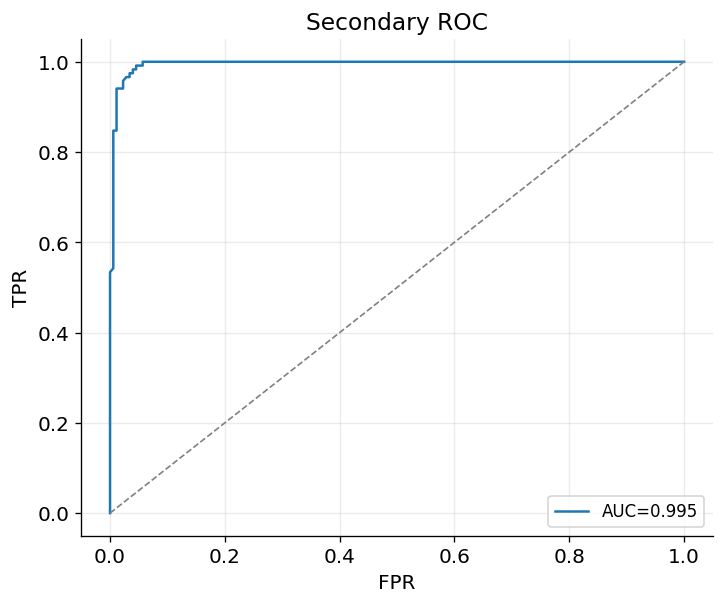

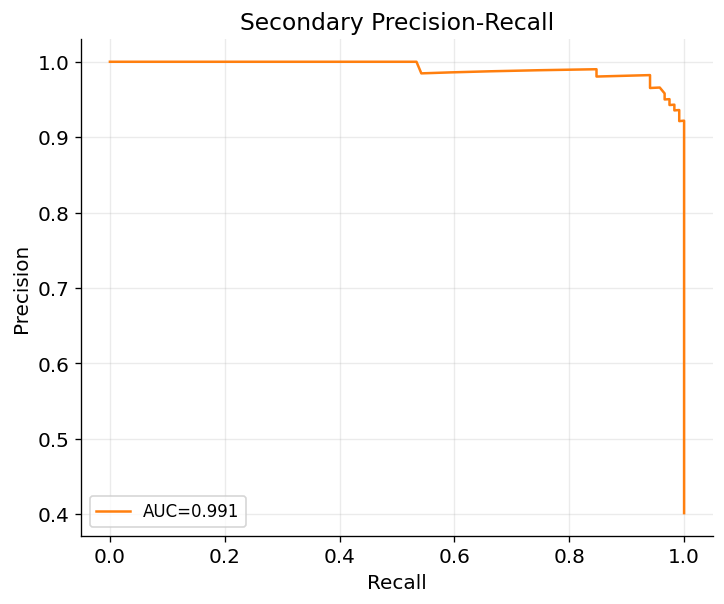

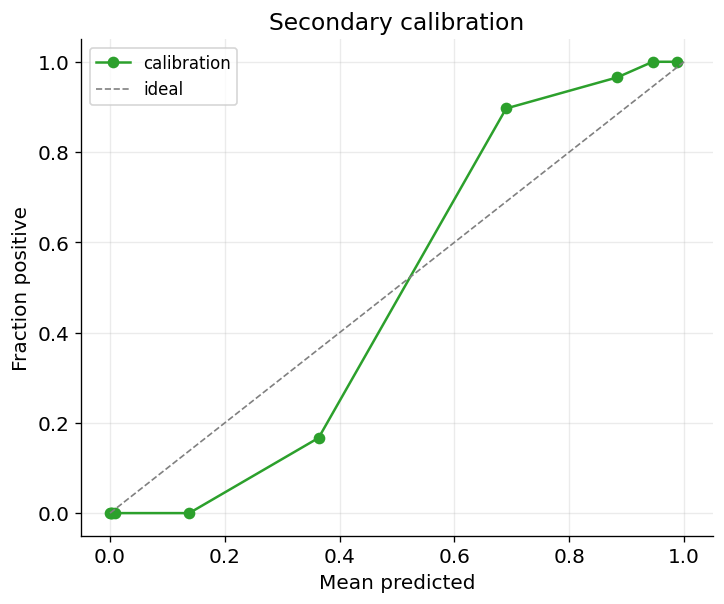

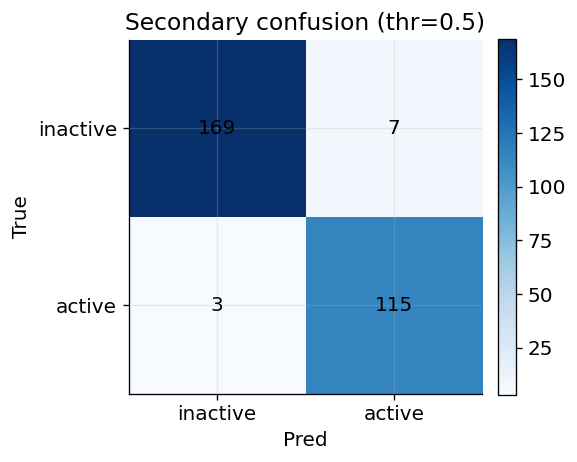

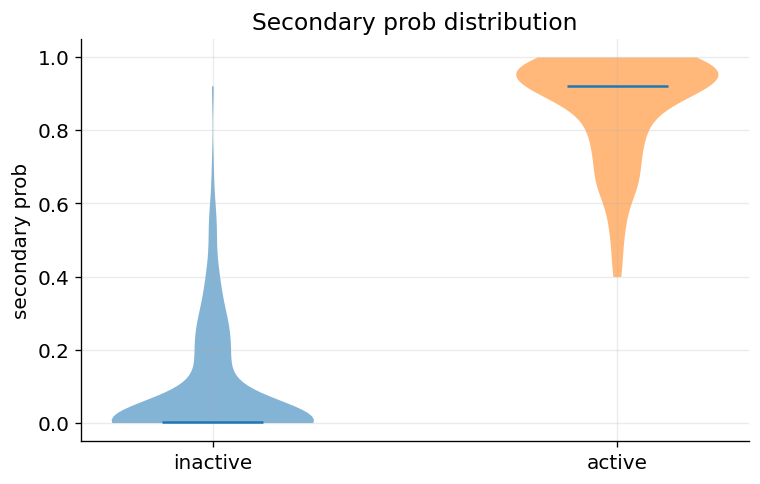

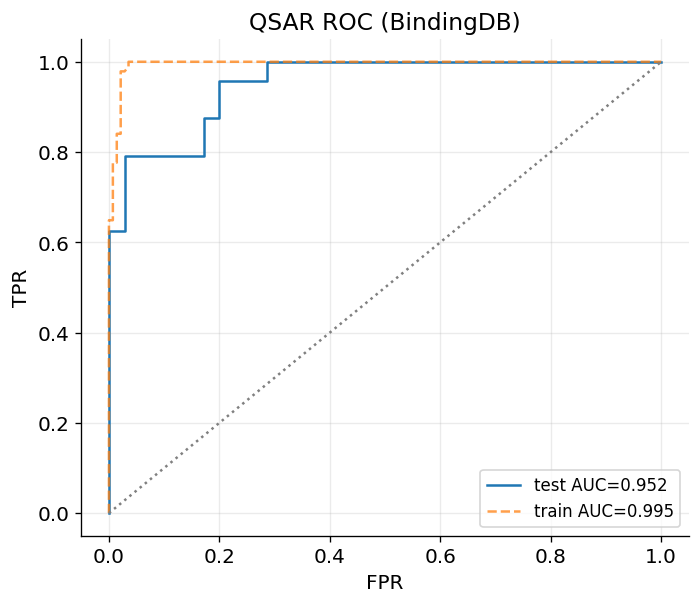

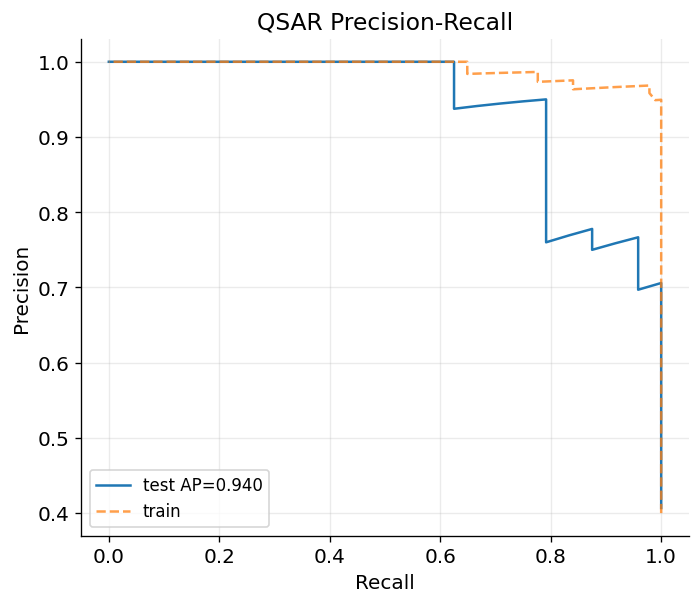

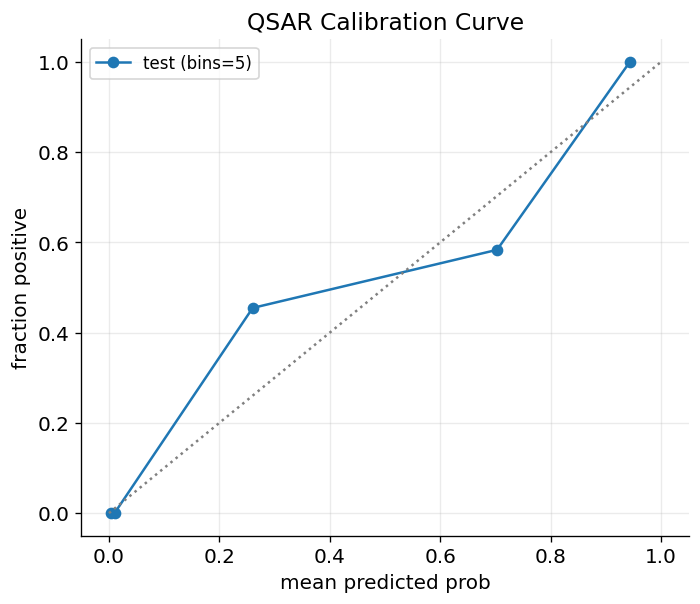

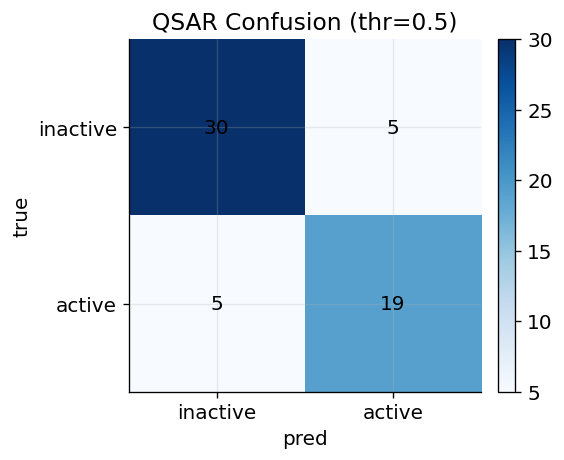

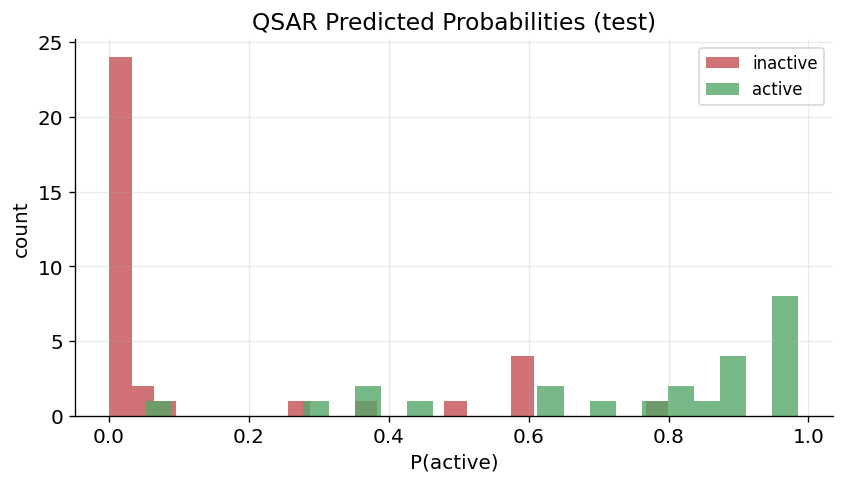

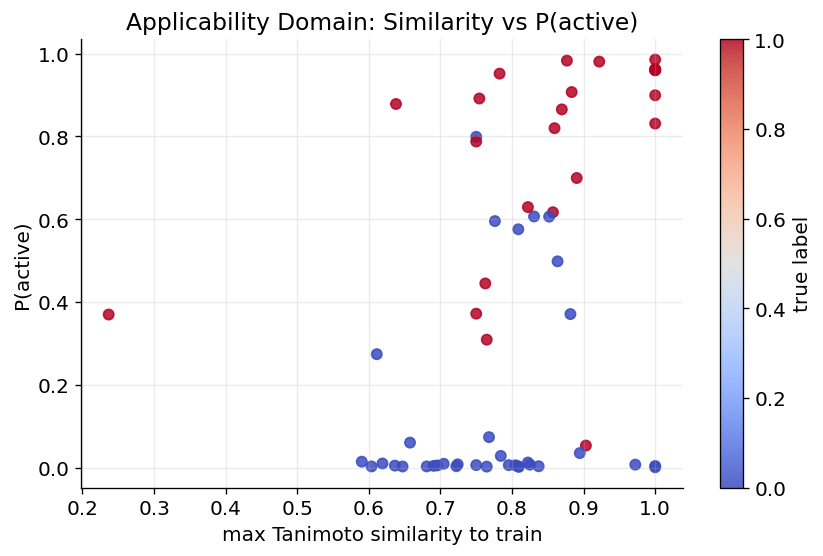

In [13]:
# ===== 选择 BindingDB 作为 QSAR/二分类数据源 =====
qsar_src = None
if "labels_qsar" in globals() and labels_qsar is not None and not labels_qsar.empty:
    qsar_src = labels_qsar.copy()
elif "labels_model" in globals() and labels_model is not None and not labels_model.empty:
    qsar_src = labels_model.copy()

if qsar_src is None or qsar_src.empty:
    raise RuntimeError("No QSAR labels available. Check ERAP2_BindingDB.tsv.")

qsar_df = qsar_src.dropna(subset=["smiles", "pActivity"]).copy()
qsar_df["smiles"] = qsar_df["smiles"].astype(str)

# active 定义：activity_nM ≤ BINDINGDB_ACTIVE_THRESHOLD_NM
if "is_active" not in qsar_df.columns:
    if "activity_nM" in qsar_df.columns:
        qsar_df["is_active"] = (qsar_df["activity_nM"].astype(float) <= float(BINDINGDB_ACTIVE_THRESHOLD_NM)).astype(int)
    else:
        qsar_df["is_active"] = (qsar_df["pActivity"].astype(float) >= float(BINDINGDB_ACTIVE_THRESHOLD_PACT)).astype(int)

print({"qsar_rows": int(len(qsar_df)), "active": int(qsar_df["is_active"].sum()), "inactive": int((1 - qsar_df["is_active"]).sum())})

secondary = s2d.SecondaryPredictor(fp_bits=256, active_threshold=float(BINDINGDB_ACTIVE_THRESHOLD_PACT))
secondary.fit(qsar_df)
auc_val = secondary.evaluate_auc(qsar_df)
auc_val

# ===== 辅助活性模型可视化（ROC/PR/校准/混淆矩阵/分布） =====
try:
    from sklearn.metrics import auc as _auc
    from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
    from sklearn.calibration import calibration_curve

    df = qsar_df.dropna(subset=["smiles", "pActivity"]).copy()
    df = df.sample(n=min(len(df), 2000), random_state=0).reset_index(drop=True)
    y = df["is_active"].astype(int).to_numpy()
    p = np.array([secondary.predict_proba(s) for s in df["smiles"].astype(str).tolist()], dtype=float)
    m = np.isfinite(p)
    y = y[m]
    p = p[m]

    if len(set(y.tolist())) > 1:
        fpr, tpr, _ = roc_curve(y, p)
        roc_auc = float(_auc(fpr, tpr))
        fig, ax = plt.subplots(figsize=(6.2, 5.2))
        ax.plot(fpr, tpr, color=S2D_COLORWAY[0], label=f"AUC={roc_auc:.3f}")
        ax.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
        ax.set_title("Secondary ROC")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend()
        savefig(fig, FIG_DIR / "secondary_roc.png")
        plt.show()

        pr, rc, _ = precision_recall_curve(y, p)
        pr_auc = float(_auc(rc, pr))
        fig, ax = plt.subplots(figsize=(6.2, 5.2))
        ax.plot(rc, pr, color=S2D_COLORWAY[1], label=f"AUC={pr_auc:.3f}")
        ax.set_title("Secondary Precision-Recall")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend()
        savefig(fig, FIG_DIR / "secondary_pr.png")
        plt.show()

        frac_pos, mean_pred = calibration_curve(y, p, n_bins=10, strategy="quantile")
        fig, ax = plt.subplots(figsize=(6.2, 5.2))
        ax.plot(mean_pred, frac_pos, marker="o", color=S2D_COLORWAY[2], label="calibration")
        ax.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1, label="ideal")
        ax.set_title("Secondary calibration")
        ax.set_xlabel("Mean predicted")
        ax.set_ylabel("Fraction positive")
        ax.legend()
        savefig(fig, FIG_DIR / "secondary_calibration.png")
        plt.show()

        cm = confusion_matrix(y, (p >= 0.5).astype(int))
        fig, ax = plt.subplots(figsize=(4.8, 4.2))
        im = ax.imshow(cm, cmap="Blues")
        ax.set_title("Secondary confusion (thr=0.5)")
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["inactive", "active"])
        ax.set_yticks([0, 1])
        ax.set_yticklabels(["inactive", "active"])
        for (i, j), val in np.ndenumerate(cm):
            ax.text(j, i, str(int(val)), ha="center", va="center", color="black", fontsize=12)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        savefig(fig, FIG_DIR / "secondary_confusion.png")
        plt.show()

        fig, ax = plt.subplots(figsize=(6.5, 4.2))
        data = [p[y == 0], p[y == 1]]
        parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=False)
        for i, b in enumerate(parts.get("bodies", [])):
            b.set_facecolor(S2D_COLORWAY[i % len(S2D_COLORWAY)])
            b.set_alpha(0.55)
        ax.set_xticks([1, 2])
        ax.set_xticklabels(["inactive", "active"])
        ax.set_ylabel("secondary prob")
        ax.set_title("Secondary prob distribution")
        savefig(fig, FIG_DIR / "secondary_prob_distribution.png")
        plt.show()
    else:
        print("Skip ROC/PR: only one class in qsar_df sample.")
except Exception as e:
    print("Skip secondary plots:", repr(e))


# ===== QSAR（分类）：SMILES -> active/inactive =====
try:
    from rdkit import Chem, DataStructs
    from rdkit.Chem import AllChem
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.metrics import (
        accuracy_score,
        average_precision_score,
        confusion_matrix,
        precision_recall_curve,
        roc_auc_score,
        roc_curve,
        f1_score,
    )
    from sklearn.model_selection import train_test_split
    from sklearn.calibration import calibration_curve

    mols = []
    smiles = []
    y = []
    fps = []
    for smi, act in qsar_df[["smiles", "is_active"]].itertuples(index=False, name=None):
        m = Chem.MolFromSmiles(str(smi))
        if m is None:
            continue
        mols.append(m)
        smiles.append(Chem.MolToSmiles(m))
        y.append(int(act))
        fps.append(AllChem.GetMorganFingerprintAsBitVect(m, int(QSAR_RADIUS), nBits=int(QSAR_FP_BITS)))

    if len(mols) < 30:
        print("Skip QSAR classification: too few valid molecules.")
    else:
        X = np.stack([s2d.morgan_fp_bits(m, n_bits=QSAR_FP_BITS, radius=QSAR_RADIUS) for m in mols], axis=0)
        y = np.asarray(y, dtype=int)

        X_tr, X_te, y_tr, y_te, smi_tr, smi_te, fps_tr, fps_te = train_test_split(
            X,
            y,
            smiles,
            fps,
            test_size=float(QSAR_TEST_SIZE),
            random_state=int(QSAR_RANDOM_STATE),
            stratify=y,
        )

        model = ExtraTreesClassifier(
            n_estimators=int(QSAR_N_ESTIMATORS),
            random_state=int(QSAR_RANDOM_STATE),
            n_jobs=-1,
            class_weight="balanced",
            min_samples_leaf=2,
        )
        model.fit(X_tr, y_tr)

        p_tr = model.predict_proba(X_tr)[:, 1]
        p_te = model.predict_proba(X_te)[:, 1]
        y_hat = (p_te >= 0.5).astype(int)

        metrics = {
            "n_train": int(len(y_tr)),
            "n_test": int(len(y_te)),
            "train_auc": float(roc_auc_score(y_tr, p_tr)),
            "test_auc": float(roc_auc_score(y_te, p_te)),
            "test_ap": float(average_precision_score(y_te, p_te)),
            "test_acc": float(accuracy_score(y_te, y_hat)),
            "test_f1": float(f1_score(y_te, y_hat)),
        }
        metrics

        # ROC 曲线
        fig, ax = plt.subplots(figsize=(6.0, 5.2))
        fpr, tpr, _ = roc_curve(y_te, p_te)
        ax.plot(fpr, tpr, label=f"test AUC={metrics['test_auc']:.3f}")
        fpr2, tpr2, _ = roc_curve(y_tr, p_tr)
        ax.plot(fpr2, tpr2, linestyle="--", alpha=0.75, label=f"train AUC={metrics['train_auc']:.3f}")
        ax.plot([0, 1], [0, 1], linestyle=":", color="gray")
        ax.set_title("QSAR ROC (BindingDB)")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend()
        savefig(fig, FIG_DIR / "qsar_roc.png")
        plt.show()

        # PR 曲线
        fig, ax = plt.subplots(figsize=(6.0, 5.2))
        pr, rc, _ = precision_recall_curve(y_te, p_te)
        ax.plot(rc, pr, label=f"test AP={metrics['test_ap']:.3f}")
        pr2, rc2, _ = precision_recall_curve(y_tr, p_tr)
        ax.plot(rc2, pr2, linestyle="--", alpha=0.75, label="train")
        ax.set_title("QSAR Precision-Recall")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend()
        savefig(fig, FIG_DIR / "qsar_pr.png")
        plt.show()

        # 校准曲线
        fig, ax = plt.subplots(figsize=(6.0, 5.2))
        # 测试集较小时（例如 ~50-60 个），10 bins 会导致每个 bin 样本过少 -> 曲线波动很大
        n_bins = int(min(10, max(5, len(y_te) // 15)))
        frac_pos, mean_pred = calibration_curve(y_te, p_te, n_bins=n_bins, strategy="quantile")
        ax.plot(mean_pred, frac_pos, marker="o", label=f"test (bins={n_bins})")
        ax.plot([0, 1], [0, 1], linestyle=":", color="gray")
        ax.set_title("QSAR Calibration Curve")
        ax.set_xlabel("mean predicted prob")
        ax.set_ylabel("fraction positive")
        ax.legend()
        savefig(fig, FIG_DIR / "qsar_calibration.png")
        plt.show()

        # 混淆矩阵
        cm = confusion_matrix(y_te, y_hat)
        fig, ax = plt.subplots(figsize=(4.8, 4.0))
        im = ax.imshow(cm, cmap="Blues")
        for (i, j), v in np.ndenumerate(cm):
            ax.text(j, i, str(int(v)), ha="center", va="center")
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(["inactive", "active"])
        ax.set_yticklabels(["inactive", "active"])
        ax.set_xlabel("pred")
        ax.set_ylabel("true")
        ax.set_title("QSAR Confusion (thr=0.5)")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        savefig(fig, FIG_DIR / "qsar_confusion.png")
        plt.show()

        # 预测概率分布
        fig, ax = plt.subplots(figsize=(7.2, 4.2))
        ax.hist(p_te[y_te == 0], bins=25, alpha=0.8, label="inactive", color="#C44E52")
        ax.hist(p_te[y_te == 1], bins=25, alpha=0.8, label="active", color="#55A868")
        ax.set_title("QSAR Predicted Probabilities (test)")
        ax.set_xlabel("P(active)")
        ax.set_ylabel("count")
        ax.legend()
        savefig(fig, FIG_DIR / "qsar_prob_hist.png")
        plt.show()

        # 适用域（Applicability Domain）
        max_sim = []
        for fp in fps_te:
            sims = DataStructs.BulkTanimotoSimilarity(fp, fps_tr)
            max_sim.append(float(max(sims)) if sims else 0.0)
        fig, ax = plt.subplots(figsize=(7.2, 4.8))
        sca = ax.scatter(max_sim, p_te, c=y_te, cmap="coolwarm", s=38, alpha=0.85)
        ax.set_title("Applicability Domain: Similarity vs P(active)")
        ax.set_xlabel("max Tanimoto similarity to train")
        ax.set_ylabel("P(active)")
        fig.colorbar(sca, ax=ax, label="true label")
        savefig(fig, FIG_DIR / "qsar_similarity_vs_prob.png")
        plt.show()

        df_out = pd.DataFrame({"smiles": smi_te, "p_active": p_te, "is_active": y_te, "max_sim_to_train": max_sim})
        df_out.sort_values("p_active", ascending=False).head(10)
except Exception as e:
    print("Skip QSAR classification section:", repr(e))


## 10. 模块G：证据链筛选与候选优选（HTVS 与生成共享）

本笔记本将每个候选分子的关键证据写入 `Candidate.evidence`，并在 HTVS 输出目录中落盘：

- `secondary`：二分类模型给出的 `secondary_prob`
- `main`：主模型给出的 `main_score` + `state_profile`
- `evidence/*.json`：每个候选的证据链（可用于审计与复现）

同时，本笔记本在可视化中补充“解释性证据”：

- state 偏好谱（`state_profile`）
- 与训练集中已知活性样本的相似性检索（fingerprint similarity）

如需更严格的过滤（PAINS/反应性基团/合成可行性/关键相互作用/短 MD 稳定性等），可在本模块按阶段逐步引入相关规则，并持续写入 evidence 以保证可追溯性。


In [14]:
cand = s2d.build_candidate(
    "O=C(O)C1=CC=CC=C1",
    target=target,
    states=states,
    score_model=score_model,
    secondary=secondary,
    filter_config=FILTER_CONFIG,
    pose_config=POSE_CONFIG_FINE,
    k_states=3,
    poses_per_state=2,
    seed=0,
)

# 证据链概览 + 关键打分/过滤/相互作用替代指标
cand.candidate_id, [(e.stage, e.decision) for e in cand.evidence], cand.aggregated_scores


('cand_26bf882abdda',
 [('filters', 'pass'),
  ('secondary', 'fail'),
  ('main', 'fail'),
  ('pose', 'info')],
 {'heavy_atoms': 9,
  'rings': 1,
  'MW': 122.12299999999996,
  'logP': 1.3848,
  'TPSA': 37.3,
  'HBD': 1,
  'HBA': 1,
  'RotB': 1,
  'qed': 0.6106035394285075,
  'sa_score': 1.0549172379947862,
  'pains_hits': 0,
  'brenk_hits': 0,
  'nih_hits': 0,
  'zinc_hits': 0,
  'reactive_hits': 0,
  'filters_pass': 1,
  'secondary_prob': 0.028935379053831034,
  'main_score': 4.283438395892753,
  'pose_contact_count_mean': 15.0,
  'pose_contact_count_best': 15.0,
  'pose_clash_count_mean': 0.0,
  'pose_clash_count_best': 0.0,
  'pose_min_dist_mean': 1.6219438393910726,
  'pose_min_dist_best': 1.5065569877624512,
  'pose_mean_closest_dist_mean': 2.273727464675903,
  'pose_mean_closest_dist_best': 2.0838236808776855,
  'pose_anchor_match_count_mean': 0.0,
  'pose_anchor_match_count_best': 0.0,
  'pose_anchor_match_frac_mean': 0.0,
  'pose_anchor_match_frac_best': 0.0,
  'pose_stability_o

## 11. 任务1：高通量虚拟筛选（HTVS）

本模块展示的是 **流式 HTVS** 的工程骨架：

- 输入：一个 SMILES 文件（可自动构建 `screening_library.smi`，也可直接接 DrugGEN/扩散模型输出 CSV）
- 粗筛：少量 states + `POSE_CONFIG_COARSE`（更快）
- 精筛：更多 states/pose + `POSE_CONFIG_FINE`（更严：关键接触 + 稳定性/anchor）
- 输出：`runs/<RUN_ID>/htvs/hits_*.csv` + `runs/<RUN_ID>/htvs/evidence/*.json`

并行与可观测性：

- `HTVS_N_JOBS` 控制多进程（例如 24）。
- 运行日志：`runs/<RUN_ID>/htvs/htvs.log`
- worker PID 记录：`runs/<RUN_ID>/htvs/worker_pids_screen.txt`、`runs/<RUN_ID>/htvs/worker_pids_refine.txt`（用于确认是否跑满多核）


In [15]:
from rdkit import Chem
from rdkit.Chem import BRICS, Lipinski, QED
from tqdm.auto import tqdm

lib_dir = DATA / "library"
lib_path = lib_dir / "screening_library.smi"
lib_dir.mkdir(parents=True, exist_ok=True)

# 构建用于筛选的 SMILES 库：以训练集分子为种子，并通过 BRICS 进行轻量扩增
N_LIBRARY = 100
rng = np.random.default_rng(0)

seed_smis = []
if "labels_train" in globals() and labels_train is not None and not labels_train.empty:
    seed_smis = labels_train["smiles"].dropna().astype(str).unique().tolist()
elif "labels_agg" in globals() and labels_agg is not None and not labels_agg.empty:
    seed_smis = labels_agg["smiles"].dropna().astype(str).unique().tolist()

# 必须包含输入复合物中的参考配体（共晶配体），保证最终筛选结果里一定能看到它
REFERENCE_LIG_SMILES = None
try:
    st0 = states[0] if ("states" in globals() and states) else None
    if st0 is not None:
        REFERENCE_LIG_SMILES = s2d.extract_reference_ligand_smiles_from_state(st0)
except Exception as _e:
    print("Reference ligand SMILES extraction failed:", repr(_e))
    REFERENCE_LIG_SMILES = None
print("Reference ligand SMILES:", REFERENCE_LIG_SMILES)

if not seed_smis:
    seed_smis = ["CCO", "CCN", "c1ccccc1", "O=C(O)C1=CC=CC=C1", "CC(C)N", "COC", "CCCl", "CC(=O)O"]

def _canon(s: str):
    m = Chem.MolFromSmiles(str(s))
    if m is None:
        return None
    return Chem.MolToSmiles(m)

force_list = FORCE_INCLUDE_SMILES_NEUTRAL if "FORCE_INCLUDE_SMILES_NEUTRAL" in globals() else (FORCE_INCLUDE_SMILES if "FORCE_INCLUDE_SMILES" in globals() else [])
force_canons = []
for _s in force_list:
    cs = _canon(_s)
    if cs is not None:
        force_canons.append(cs)
force_canons = sorted(set(force_canons))
if force_canons:
    print("Force-include canonical SMILES:", force_canons)

ref_canon = _canon(REFERENCE_LIG_SMILES) if REFERENCE_LIG_SMILES else None
if ref_canon is None:
    fb = REFERENCE_LIGAND_FALLBACK_SMILES_NEUTRAL if "REFERENCE_LIGAND_FALLBACK_SMILES_NEUTRAL" in globals() else (REFERENCE_LIGAND_FALLBACK_SMILES if "REFERENCE_LIGAND_FALLBACK_SMILES" in globals() else None)
    ref_canon = _canon(fb) if fb else None
if ref_canon is None:
    raise ValueError("Reference ligand SMILES missing or invalid; cannot build library.")
print("Reference ligand canonical SMILES:", ref_canon)

def _passes(smi: str) -> bool:
    m = Chem.MolFromSmiles(str(smi))
    if m is None:
        return False
    if FILTER_CONFIG is not None:
        f = s2d.evaluate_filters(m, config=FILTER_CONFIG)
        if int(f.get("filters_pass", 0)) != 1:
            return False
        qed = float(f.get("qed", 0.0))
    else:
        qed = float(QED.qed(m))
    ha = int(m.GetNumHeavyAtoms())
    rings = int(Lipinski.RingCount(m))
    return (
        ha >= int(GEN_MIN_HEAVY_ATOMS)
        and ha <= int(GEN_MAX_HEAVY_ATOMS)
        and rings >= int(GEN_MIN_RINGS)
        and qed >= float(GEN_QED_MIN)
    )

smis = set()
# 强制把参考/基准化合物加入库中（不受 _passes 过滤影响）
smis.add(ref_canon)
for cs in force_canons:
    smis.add(cs)
for s in seed_smis:
    cs = _canon(s)
    if cs is None:
        continue
    if _passes(cs):
        smis.add(cs)

# BRICS 扩增（可选）：仅使用参考配体的碎片再随机重组，直到填满 N_LIBRARY
frag_by_smi = {}
ref_smis = [ref_canon]
for s in tqdm(ref_smis, desc="BRICS fragments"):
    m = Chem.MolFromSmiles(str(s))
    if m is None:
        continue
    try:
        # 只取叶子片段（真正拆分出的碎片），避免把整分子/大块中间体当作“片段”
        parts = BRICS.BRICSDecompose(m, keepNonLeafNodes=False, minFragmentSize=2, returnMols=True)
    except Exception:
        continue
    for fm in list(parts):
        if fm is None:
            continue
        ha = int(fm.GetNumHeavyAtoms())
        if not (2 <= ha <= 35):
            continue
        try:
            fs = Chem.MolToSmiles(fm)
        except Exception:
            continue
        # 不把参考配体本身当作片段（当 BRICS 无可拆分键时会退化成整分子）
        if fs == ref_canon:
            continue
        frag_by_smi.setdefault(fs, fm)
frag_pool = list(frag_by_smi.values())
print("BRICS leaf fragments (reference):", len(frag_pool))
for fs in sorted(frag_by_smi.keys()):
    print("  ", fs)
frags_path = lib_dir / "reference_brics_fragments.smi"
frags_path.write_text("\n".join(sorted(frag_by_smi.keys())) + "\n", encoding="utf-8")
print("Saved fragments:", frags_path)

tries = 0
target_n = int(N_LIBRARY)
pbar = None
if len(smis) < target_n and len(frag_pool) >= 2:
    pbar = tqdm(total=target_n, initial=len(smis), desc="BRICS library", mininterval=0.3, smoothing=0.2)
while len(smis) < target_n and tries < 20000 and len(frag_pool) >= 2:
    tries += 1
    k = int(rng.integers(2, min(4, len(frag_pool)) + 1))
    pick = rng.choice(np.array(frag_pool, dtype=object), size=int(k), replace=False).tolist()
    try:
        gen = BRICS.BRICSBuild(pick, maxDepth=3, onlyCompleteMols=True, uniquify=True, scrambleReagents=True)
    except Exception:
        continue
    for m in gen:
        if m is None:
            continue
        try:
            smi = Chem.MolToSmiles(m)
        except Exception:
            continue
        if smi in smis:
            continue
        if _passes(smi):
            smis.add(smi)
            if pbar is not None:
                pbar.update(1)
        if len(smis) >= target_n:
            break

if pbar is not None:
    pbar.close()

lib_path.write_text("\n".join(sorted(smis)) + "\n", encoding="utf-8")
lib_path, len(smis)


Reference ligand SMILES: N[C@H](C(=O)Nc1ccc2oc(=O)n(CC(=O)N3CCCCC3)c2c1)c1ccc(-c2ccccc2)cc1
Force-include canonical SMILES: ['N[C@H](C(=O)Nc1ccc2oc(=O)n(CC(=O)N3CCCCC3)c2c1)c1ccc(-c2ccccc2)cc1', 'O=C(NC[C@@H]1Cc2cccc(-c3cccnc3)c2O1)c1ccc2c(c1)no[n+]2[O-]']
Reference ligand canonical SMILES: N[C@H](C(=O)Nc1ccc2oc(=O)n(CC(=O)N3CCCCC3)c2c1)c1ccc(-c2ccccc2)cc1


BRICS fragments:   0%|          | 0/1 [00:00<?, ?it/s]

BRICS leaf fragments (reference): 6
   [1*]C(=O)C[8*]
   [1*]C(=O)[C@H]([8*])N
   [16*]c1ccc([16*])cc1
   [16*]c1ccccc1
   [5*]N1CCCCC1
   [5*]Nc1ccc2oc(=O)n([9*])c2c1
Saved fragments: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/data/library/reference_brics_fragments.smi


BRICS library:  74%|#######4  | 74/100 [00:00<?, ?it/s]

(PosixPath('/media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/data/library/screening_library.smi'),
 100)

In [16]:
import os
from tqdm.auto import tqdm

# Ensure HTVS uses tqdm for visible progress bars in notebooks
s2d.tqdm = tqdm

HTVS_LOG = RUN_DIR / "htvs" / "htvs.log"
print(f"HTVS_N_JOBS={HTVS_N_JOBS} | os.cpu_count()={os.cpu_count()}")
print("HTVS log:", HTVS_LOG)

# 两阶段 HTVS（粗筛 + 精筛）：运行后输出进度与多进程日志
hits2 = s2d.htvs_two_stage(
    lib_path,
    target=target,
    states=states,
    score_model=score_model,
    secondary=secondary,
    filter_config=FILTER_CONFIG,
    pose_config_small=POSE_CONFIG_COARSE,
    pose_config_large=POSE_CONFIG_FINE,
    run_dir=RUN_DIR,
    log_path=HTVS_LOG,
    k_small=3,
    k_large=6,
    poses_small=1,
    poses_large=2,
    chunk_size=50,
    top_n_stage1=80,
    top_n_final=25,
    n_jobs=HTVS_N_JOBS,
    seed=0,
)

# 确保参考配体出现在最终 hits_refined.csv 中（即使不在 Top-N）
try:
    import json
    from rdkit import Chem

    ref_smiles = globals().get("REFERENCE_LIG_SMILES", None)
    if ref_smiles is None:
        st0 = states[0] if states else None
        if st0 is not None:
            ref_smiles = s2d.extract_reference_ligand_smiles_from_state(st0)
    if ref_smiles:
        m = Chem.MolFromSmiles(str(ref_smiles))
        ref_canon = Chem.MolToSmiles(m) if m is not None else str(ref_smiles)

        has_ref = (
            hits2 is not None
            and (not hits2.empty)
            and ("smiles" in hits2.columns)
            and (hits2["smiles"].astype(str) == ref_canon).any()
        )
        if not has_ref:
            print("Reference ligand not in hits_refined; scoring & appending:", ref_canon)
            ref_cand = s2d.build_candidate(
                ref_canon,
                target=target,
                states=states,
                score_model=score_model,
                secondary=secondary,
                filter_config=FILTER_CONFIG,
                pose_config=POSE_CONFIG_FINE,
                k_states=6,
                poses_per_state=2,
                seed=0,
                force_score=True,
            )
            ref_row = {
                "candidate_id": ref_cand.candidate_id,
                "smiles": ref_cand.smiles,
                "main_score": float("nan"),
                "main_refined": float(ref_cand.aggregated_scores.get("main_score", float("nan"))),
                "secondary_prob": float(ref_cand.aggregated_scores.get("secondary_prob", float("nan"))),
                "combined": float(ref_cand.aggregated_scores.get("combined", float("nan"))),
                "filters_pass": int(ref_cand.aggregated_scores.get("filters_pass", 1)),
                "qed": float(ref_cand.aggregated_scores.get("qed", float("nan"))),
                "sa_score": float(ref_cand.aggregated_scores.get("sa_score", float("nan"))),
                "pains_hits": int(ref_cand.aggregated_scores.get("pains_hits", 0)),
                "reactive_hits": int(ref_cand.aggregated_scores.get("reactive_hits", 0)),
                "state_profile_json": json.dumps(ref_cand.state_profile, ensure_ascii=False),
            }
            hits2 = pd.concat([hits2, pd.DataFrame([ref_row])], ignore_index=True)
            try:
                s2d._write_candidate_evidence(ref_cand, RUN_DIR / "htvs" / "evidence" / f"{ref_cand.candidate_id}.json")
            except Exception:
                pass

        hits2["is_reference"] = (hits2["smiles"].astype(str) == ref_canon).astype(int)
        hits2.to_csv(RUN_DIR / "htvs" / "hits_refined.csv", index=False)
        print("Reference ligand candidate_id:", hits2.loc[hits2["is_reference"] == 1, "candidate_id"].tolist())
except Exception as _e:
    print("Reference ligand inclusion skipped:", repr(_e))

display(hits2.head(10))

# 多进程核验：PID 文件记录 worker 数量
for p in [RUN_DIR / "htvs" / "worker_pids_screen.txt", RUN_DIR / "htvs" / "worker_pids_refine.txt"]:
    if p.exists():
        pids = {x.strip() for x in p.read_text(encoding="utf-8", errors="ignore").splitlines() if x.strip()}
        print(p.name, "unique_pids=", len(pids), "(expect ~", HTVS_N_JOBS, ")")
    else:
        print("missing", p)


HTVS_N_JOBS=1 | os.cpu_count()=24
HTVS log: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/runs/ERAP2_20260129_110535/htvs/htvs.log
2026-01-29 11:29:50 [htvs_screen] single-process | lib=screening_library.smi | chunk_size=50 | top_n=80


HTVS stage1:   0%|          | 0/2 [00:00<?, ?it/s]

2026-01-29 11:30:13 [htvs_screen] progress | chunks=1 | seen=50 | heap_min=3.027
2026-01-29 11:30:34 [htvs_screen] progress | chunks=2 | seen=100 | heap_min=3.027
2026-01-29 11:30:35 [htvs_screen] done | hits=80 | saved=/media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/runs/ERAP2_20260129_110535/htvs/hits.csv
2026-01-29 11:30:35 [htvs_two_stage] stage2 refine | single-process | n=80 | k=6 | poses=2


HTVS stage2 refine:   0%|          | 0/80 [00:00<?, ?it/s]

2026-01-29 11:30:45 [htvs_two_stage] refine progress | done=12/80
2026-01-29 11:30:55 [htvs_two_stage] refine progress | done=24/80
2026-01-29 11:31:05 [htvs_two_stage] refine progress | done=37/80
2026-01-29 11:31:16 [htvs_two_stage] refine progress | done=51/80
2026-01-29 11:31:27 [htvs_two_stage] refine progress | done=62/80
2026-01-29 11:31:37 [htvs_two_stage] refine progress | done=71/80
2026-01-29 11:31:48 [htvs_two_stage] refine progress | done=80/80
2026-01-29 11:31:48 [htvs_two_stage] done | hits=25 | saved=/media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/runs/ERAP2_20260129_110535/htvs/hits_refined.csv
Reference ligand candidate_id: ['cand_646b62d4db7c']


,candidate_id,smiles,main_score,main_refined,secondary_prob,combined,filters_pass,qed,sa_score,pains_hits,reactive_hits,state_profile_json,is_reference
0,cand_ff319e5c9219,CC(C)C[C@H](CP(=O)(O)[C@@H](N)CCc1ccccc1)C(=O)...,6.943332,6.943332,0.989583,7.432914,1,0.497874,3.777339,0,0,"{""07"": 6.943331776250531, ""01"": 6.943331772525...",0
1,cand_5132c9b1b5d7,NC(CCc1ccc(CO)cc1)P(=O)(O)CC(Cc1ccccc1)C(=O)O,6.802565,6.802565,0.926678,7.229243,1,0.462155,3.352727,0,0,"{""01"": 6.8025652632213705, ""03"": 6.80256526322...",0
2,cand_e00d29d5c9bb,N[C@@H](CCc1ccccc1)P(=O)(O)C[C@@H](Cc1ccccc1)C...,6.434782,6.434782,0.976543,6.911325,1,0.595929,3.221528,0,0,"{""07"": 6.434782484777119, ""01"": 6.434782481051...",0
3,cand_5741afd0f532,NC(CCc1ccccc1)P(=O)(O)CC(Cc1ccccc1)C(=O)O,6.434782,6.434782,0.976543,6.911325,1,0.595929,3.221528,0,0,"{""05"": 6.434782484777119, ""07"": 6.434782484777...",0
4,cand_d286d26b77d4,NC(CCc1cccnc1)P(=O)(O)CC(Cc1ccccc1)C(=O)O,6.434782,6.434782,0.981003,6.915786,1,0.590810,3.416921,0,0,"{""07"": 6.434782484777119, ""05"": 6.434782481051...",0
5,cand_ac759c066696,NC(CCc1ccncc1)P(=O)(O)CC(Cc1ccccc1)C(=O)O,6.434782,6.434782,0.981608,6.916390,1,0.590810,3.420638,0,0,"{""05"": 6.4347824773265385, ""03"": 6.43478247732...",0
6,cand_d9a8ab9a0a3c,NC(CCc1ccccc1)P(=O)(O)CC(Cc1ccc(O)cc1)C(=O)O,5.849328,5.849328,0.992253,6.341581,1,0.498797,3.353053,0,0,"{""03"": 5.8493280049435485, ""05"": 5.84932800121...",0
7,cand_c3b8e4086add,NC(CCc1ccc(O)cc1)P(=O)(O)CC(Cc1ccccc1)C(=O)O,5.849328,5.849328,0.992253,6.341581,1,0.498797,3.353053,0,0,"{""01"": 5.8493280049435485, ""03"": 5.84932800494...",0
8,cand_2b7efba8d8bf,O=C(Cc1ccc(-c2ccc(-c3ccccc3)cc2)cc1)N1CCCCC1,5.762473,5.762473,0.016462,5.278935,1,0.598488,1.692782,0,0,"{""01"": 5.762472695612748, ""03"": 5.762472695612...",0
9,cand_646b62d4db7c,N[C@H](C(=O)Nc1ccc2oc(=O)n(CC(=O)N3CCCCC3)c2c1...,5.762473,5.762473,0.078734,5.341206,1,0.431121,2.818572,0,0,"{""01"": 5.762472695612748, ""03"": 5.762472695612...",1


missing /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/runs/ERAP2_20260129_110535/htvs/worker_pids_screen.txt
missing /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/runs/ERAP2_20260129_110535/htvs/worker_pids_refine.txt


### （可选）两阶段 HTVS：粗筛 + 精筛

使用 `htvs_two_stage()`：先用 `K_small` 粗筛，再对 Top 集合用 `K_large` + 更多 pose 精筛。

精筛阶段会将更高成本的证据（更多 state/pose）追加写回同一候选的证据链，用于在结果报告中提供可解释的选择依据。


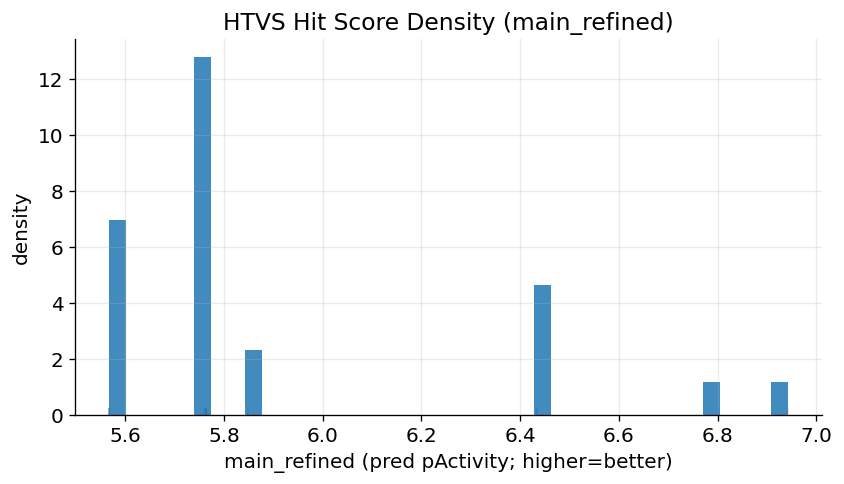

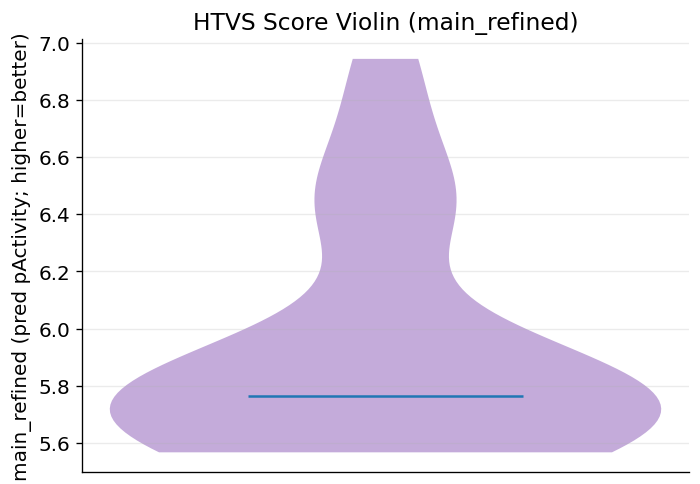

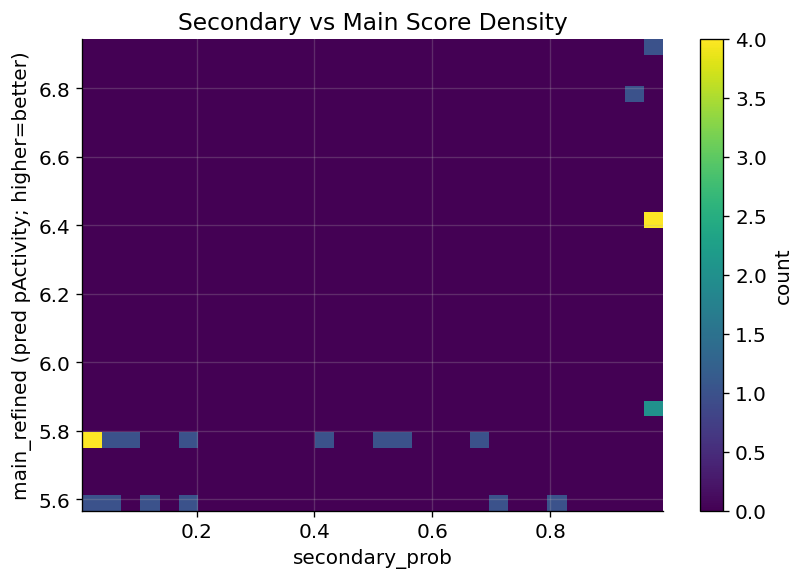

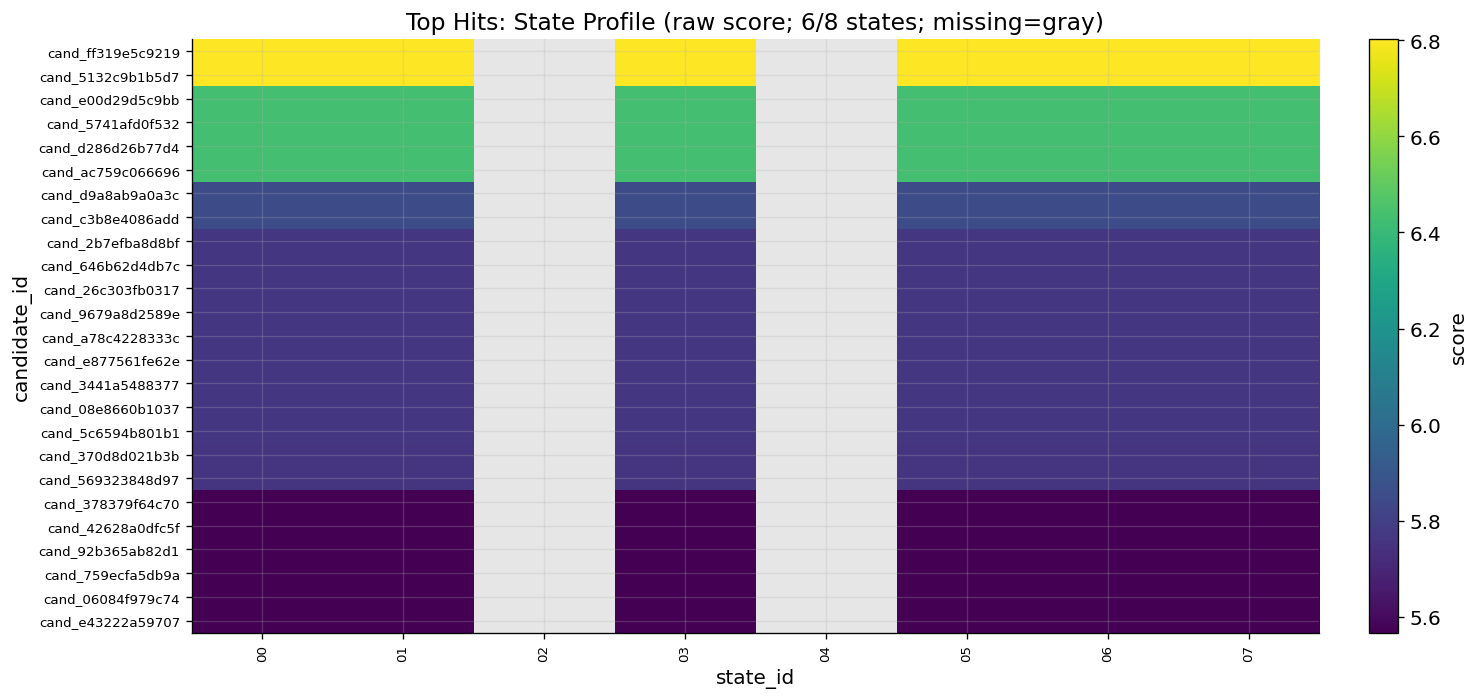

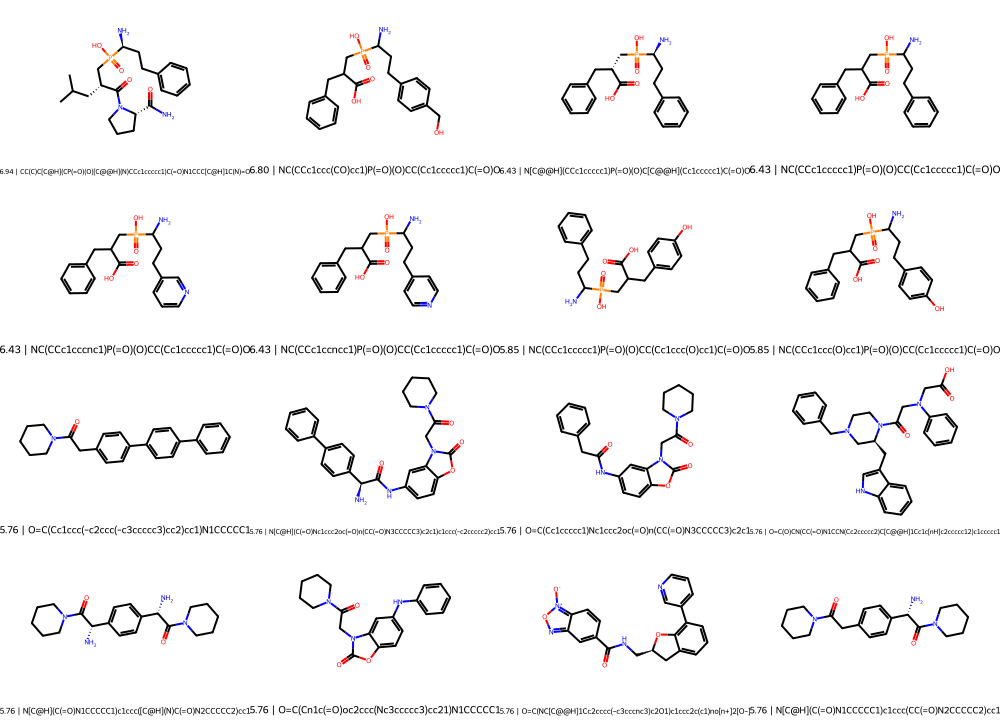

In [17]:
# 复用上一个单元的 hits2（两阶段 HTVS 输出）进行可视化
if "hits2" not in globals() or hits2 is None:
    raise RuntimeError("Run the HTVS cell first to produce `hits2`.")

# ===== HTVS 结果可视化（密度 + 偏好谱） =====
hits_view = hits2.copy()
if hits_view.empty:
    print("No hits")
else:
    score_col = "main_refined" if "main_refined" in hits_view.columns else "main_score"
    # 注意：这里的 main_score/main_refined 是模型预测的 pActivity（越大越好），不是 docking ΔG（通常为负）
    score_label = f"{score_col} (pred pActivity; higher=better)"
    try:
        vals = hits_view[score_col].dropna().astype(float).to_numpy()
        if len(vals):
            fig, ax = plt.subplots(figsize=(7.2, 4.2))
            ax.hist(vals, bins=40, density=True, color=S2D_COLORWAY[0], alpha=0.85)
            # Rug（用于密度图的样本标记）
            rug = vals
            if len(rug) > 2000:
                rug = np.random.default_rng(0).choice(rug, size=2000, replace=False)
            y0 = ax.get_ylim()[0]
            ax.plot(rug, np.full_like(rug, y0), "|", color=S2D_COLORWAY[0], alpha=0.15, markersize=8)
            ax.set_title(f"HTVS Hit Score Density ({score_col})")
            ax.set_xlabel(score_label)
            ax.set_ylabel("density")
            savefig(fig, FIG_DIR / f"htvs_score_density_{score_col}.png")
            plt.show()
    except Exception as e:
        print("Skip density plot:", repr(e))

    try:
        vals = hits_view[score_col].dropna().astype(float).to_numpy()
        if len(vals):
            fig, ax = plt.subplots(figsize=(6.0, 4.2))
            parts = ax.violinplot(vals, showmeans=False, showmedians=True, showextrema=False)
            for b in parts.get("bodies", []):
                b.set_facecolor(S2D_COLORWAY[4])
                b.set_alpha(0.55)
            ax.set_title(f"HTVS Score Violin ({score_col})")
            ax.set_ylabel(score_label)
            ax.set_xticks([])
            savefig(fig, FIG_DIR / f"htvs_score_violin_{score_col}.png")
            plt.show()
    except Exception as e:
        print("Skip violin plot:", repr(e))

    if "secondary_prob" in hits_view.columns:
        try:
            x = hits_view["secondary_prob"].dropna().astype(float).to_numpy()
            y = hits_view.loc[hits_view["secondary_prob"].notna(), score_col].dropna().astype(float).to_numpy()
            m = np.isfinite(x) & np.isfinite(y)
            x = x[m]
            y = y[m]
            if len(x) and len(y):
                fig, ax = plt.subplots(figsize=(7.0, 5.0))
                h = ax.hist2d(x, y, bins=30, cmap="viridis")
                ax.set_title("Secondary vs Main Score Density")
                ax.set_xlabel("secondary_prob")
                ax.set_ylabel(score_label)
                fig.colorbar(h[3], ax=ax, label="count")
                savefig(fig, FIG_DIR / f"htvs_secondary_vs_{score_col}_density.png")
                plt.show()
        except Exception as e:
            print("Skip secondary-vs-main density:", repr(e))

    try:
        import json as _json

        top = hits_view.head(25).copy()
        state_ids = [s.state_id for s in states]
        mat = []
        for _, r in top.iterrows():
            d = _json.loads(r.get("state_profile_json", "{}"))
            # 缺失 state 使用 NaN（避免以 0 导致色阶范围不合理拉伸）
            mat.append([float(d.get(sid, float('nan'))) for sid in state_ids])
        mat = np.array(mat, dtype=float)

        # 绘制“偏好谱”：每个候选减去其 state 均值（强调相对偏好，便于比较）
        row_mean = np.nanmean(mat, axis=1, keepdims=True)
        pref = mat - row_mean

        finite_counts = np.sum(np.isfinite(mat), axis=1) if mat.size else np.array([], dtype=int)
        max_finite = int(np.max(finite_counts)) if finite_counts.size else 0

        fig, ax = plt.subplots(figsize=(12.5, 6.0))
        if max_finite <= 1:
            # 对仅含单一 state 的候选，Δ 恒为 0；此时展示 raw score 更具区分度
            plot_mat = np.ma.masked_invalid(mat)
            cmap = plt.get_cmap("viridis").copy()
            cmap.set_bad(color="#e6e6e6")
            if plot_mat.count():
                vmin = float(np.nanpercentile(mat, 5))
                vmax = float(np.nanpercentile(mat, 95))
            else:
                vmin, vmax = 0.0, 1.0
            if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
                vmin = float(np.nanmin(mat)) if plot_mat.count() else 0.0
                vmax = float(np.nanmax(mat)) if plot_mat.count() else 1.0
                if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
                    vmin, vmax = 0.0, 1.0
            im = ax.imshow(plot_mat, cmap=cmap, aspect="auto", vmin=vmin, vmax=vmax)
            ax.set_title("Top Hits: State Profile (raw score; missing=gray)")
            cbar_label = "score"
        else:
            # 将缺失 state 设为 NaN 并显示为灰色，避免 0 造成色阶偏移
            pref_m = np.ma.masked_invalid(pref)
            vals = np.abs(pref_m.compressed()) if pref_m.count() else np.array([], dtype=float)
            v = float(np.nanpercentile(vals, 95)) if vals.size else float("nan")

            # 若 Δ 极小（几乎不随 state 变化），展示 raw score 更有信息量；missing state 仍以灰色显示
            if (not np.isfinite(v)) or v <= 0 or v < 1e-3:
                plot_mat = np.ma.masked_invalid(mat)
                cmap = plt.get_cmap("viridis").copy()
                cmap.set_bad(color="#e6e6e6")
                if plot_mat.count():
                    vmin = float(np.nanpercentile(mat, 5))
                    vmax = float(np.nanpercentile(mat, 95))
                else:
                    vmin, vmax = 0.0, 1.0
                if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
                    vmin = float(np.nanmin(mat)) if plot_mat.count() else 0.0
                    vmax = float(np.nanmax(mat)) if plot_mat.count() else 1.0
                    if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
                        vmin, vmax = 0.0, 1.0
                im = ax.imshow(plot_mat, cmap=cmap, aspect="auto", vmin=vmin, vmax=vmax)
                ax.set_title(f"Top Hits: State Profile (raw score; {max_finite}/{len(state_ids)} states; missing=gray)")
                cbar_label = "score"
            else:
                cmap = plt.get_cmap("RdBu_r").copy()
                cmap.set_bad(color="#e6e6e6")
                im = ax.imshow(pref_m, cmap=cmap, aspect="auto", vmin=-v, vmax=v)
                ax.set_title(f"Top Hits: State Preference Profile (Δ vs per-hit mean; {max_finite}/{len(state_ids)} states; missing=gray)")
                cbar_label = "Δscore"
        ax.set_xlabel("state_id")
        ax.set_ylabel("candidate_id")
        ax.set_xticks(list(range(len(state_ids))))
        ax.set_xticklabels([str(s) for s in state_ids], rotation=90, fontsize=8)
        ylabels = top["candidate_id"].astype(str).tolist()
        ax.set_yticks(list(range(len(ylabels))))
        ax.set_yticklabels(ylabels, fontsize=8)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label=cbar_label)
        savefig(fig, FIG_DIR / "htvs_state_profile_heatmap.png")
        plt.show()
    except Exception as e:
        print("Skip state-profile heatmap:", repr(e))

    try:
        from rdkit import Chem
        from rdkit.Chem import Draw
        from IPython.display import display

        top = hits_view.head(16).copy()
        mols = []
        legends = []
        for _, r in top.iterrows():
            smi = str(r["smiles"])
            m = Chem.MolFromSmiles(smi)
            if m is None:
                continue
            mols.append(m)
            legends.append(f"{r[score_col]:.2f} | {smi}")
        if mols:
            display(Draw.MolsToGridImage(mols, legends=legends, molsPerRow=4, subImgSize=(250, 180)))
    except Exception as e:
        print("Skip mol grid:", repr(e))


### （可选）对接 DrugGEN 输出（CSV）并进入 pocket-state 精筛

DrugGEN 本体是 2D 图生成（target-specific），不包含口袋 3D 条件。常见做法是：

1. DrugGEN 先生成大量 SMILES（`inference_drugs.csv`，默认列 `SMILES`）
2. 再用本笔记本的 pocket-state 主模型做 3D proxy 精筛 + 证据链落盘

输出会进入 `runs/<RUN_ID>/htvs/`，并可用后续的交互视图查看命中与解释。 


In [18]:
if RUN_DRUGGEN_SCREEN:
    if not DRUGGEN_CSV.exists():
        raise FileNotFoundError(DRUGGEN_CSV)

    # Auto-detect SMILES column name (DrugGEN outputs are not always consistent)
    smiles_col = "SMILES"
    try:
        cols = list(pd.read_csv(DRUGGEN_CSV, nrows=1).columns)
        for c in ["SMILES", "smiles", "Smiles"]:
            if c in cols:
                smiles_col = c
                break
    except Exception:
        pass

    print("HTVS log:", RUN_DIR / "htvs" / "htvs.log")
    print({"DRUGGEN_CSV": str(DRUGGEN_CSV), "smiles_col": smiles_col})

    hits_druggen = s2d.htvs_two_stage(
        DRUGGEN_CSV,
        smiles_col=smiles_col,
        target=target,
        states=states,
        score_model=score_model,
        secondary=secondary,
        filter_config=FILTER_CONFIG,
        pose_config_small=POSE_CONFIG_COARSE,
        pose_config_large=POSE_CONFIG_FINE,
        run_dir=RUN_DIR,
        log_path=RUN_DIR / "htvs" / "htvs.log",
        k_small=3,
        k_large=6,
        poses_small=1,
        poses_large=2,
        chunk_size=2000,
        top_n_stage1=500,
        top_n_final=50,
        n_jobs=HTVS_N_JOBS,
        seed=0,
    )
    hits_druggen.head(10)
else:
    print("Skip DrugGEN HTVS (RUN_DRUGGEN_SCREEN=False).")
    try:
        print({"RUN_DRUGGEN_SCREEN": bool(RUN_DRUGGEN_SCREEN), "DRUGGEN_CSV": str(DRUGGEN_CSV), "exists": bool(DRUGGEN_CSV.exists())})
    except Exception:
        pass
    print("如需运行：在配置单元格将 RUN_DRUGGEN_SCREEN=True，并把 DRUGGEN_CSV 指向 DrugGEN 推理输出 CSV（需要 SMILES 列）。")


Skip DrugGEN HTVS (RUN_DRUGGEN_SCREEN=False).
{'RUN_DRUGGEN_SCREEN': False, 'DRUGGEN_CSV': 'data/druggen/inference_drugs.csv', 'exists': False}
如需运行：在配置单元格将 RUN_DRUGGEN_SCREEN=True，并把 DRUGGEN_CSV 指向 DrugGEN 推理输出 CSV（需要 SMILES 列）。


## 12. 任务2：分子生成（输出轨迹以支持诊断与模型替换）

生成器模块可替换；默认实现通过约束与过滤避免生成过小或缺乏化学意义的分子，并将“类药规则”作为有效生成的硬约束：

- 片段来源：从训练集/seed 分子做 BRICS 分解形成 fragment pool
- 生成方式：BRICS 片段重组（带约束：heavy atoms / ring count / QED + Rule-of-5 + Veber）
- 输出：
  - `runs/<RUN_ID>/gen_nontargeted/generated.csv`
  - `runs/<RUN_ID>/gen_targeted/generated.csv`
  - `runs/<RUN_ID>/gen_*/trajectories/*.sdf`（每一步 `step` 属性，用于回放与诊断）

Targeted 模式在重组过程中引入 pocket-state 主模型与辅助分类器作为引导信号；Non-targeted 模式仅使用药物样性与尺寸约束。

若替换为扩散模型或 3D 生长模型，只需保持“轨迹 SDF + generated.csv”的输出接口一致，即可复用本笔记本的可视化与评估流程。


### Non-targeted design（不使用 pocket 条件）

- 不调用 `ScoreModel`，仅在 BRICS 重组候选中按 **尺寸/环数/QED** 筛选，并从 top-QED 候选中采样
- 目的：保证分子不再“过小/过于简单”，同时保留多样性


In [19]:
gen_nt_df = s2d.generate_stepwise(
    target=target,
    states=None,
    score_model=None,
    secondary=None,
    filter_config=FILTER_CONFIG,
    out_dir=RUN_DIR,
    out_subdir="gen_nontargeted",
    design_mode="nontargeted",
    seed_smiles=(
        labels_train.dropna(subset=["smiles", "pActivity"])
        .sort_values("pActivity", ascending=False)["smiles"]
        .astype(str)
        .tolist()[:2000]
        if "labels_train" in globals() and "pActivity" in labels_train.columns
        else labels_agg["smiles"].dropna().astype(str).unique().tolist()[:2000]
    ),
    fragment_source_smiles=(
        labels_train["smiles"].dropna().astype(str).unique().tolist()[:5000]
        if "labels_train" in globals()
        else labels_agg["smiles"].dropna().astype(str).unique().tolist()[:5000]
    ),
    n_molecules=GEN_N_MOLECULES,
    steps=GEN_STEPS,
    beam_width=GEN_BEAM_WIDTH,
    seed=0,
    min_heavy_atoms=GEN_MIN_HEAVY_ATOMS,
    max_heavy_atoms=GEN_MAX_HEAVY_ATOMS,
    min_rings=GEN_MIN_RINGS,
    qed_min=GEN_QED_MIN,
    score_evals_per_step=GEN_SCORE_EVALS_PER_STEP,
    druglike=DRUGLIKE_ENABLE,
    ro5_max_violations=DRUGLIKE_MAX_RO5_VIOLATIONS,
    ro5_max_mw=DRUGLIKE_RO5_MAX_MW,
    ro5_max_logp=DRUGLIKE_RO5_MAX_LOGP,
    ro5_max_hbd=DRUGLIKE_RO5_MAX_HBD,
    ro5_max_hba=DRUGLIKE_RO5_MAX_HBA,
    veber_max_rotb=DRUGLIKE_VEBER_MAX_ROTB,
    veber_max_tpsa=DRUGLIKE_VEBER_MAX_TPSA,
    progress=True,
    progress_desc="gen_nontargeted",
)
gen_nt_df.head(10)


gen_nontargeted:   0%|          | 0/20 [00:00<?, ?it/s]

,design_mode,smiles,main_score,secondary_prob,objective,heavy_atoms,rings,MW,logP,TPSA,...,filters_pass,pains_hits,brenk_hits,reactive_hits,sa_score,ro5_violations,ro5_pass,ro5_fail_reasons,veber_pass,trajectory_path
0,nontargeted,N[C@@H](CCc1ccccc1)P(=O)(O)C[C@@H](Cc1cc(-c2cc...,NaN,NaN,NaN,34,4,482.521,3.7057,122.55,...,1,0,0,0,3.762361,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
1,nontargeted,COc1cc(Oc2cc(-c3cc(F)ccc3Oc3cc(OC)no3)no2)on1,NaN,NaN,NaN,28,4,389.295,4.0585,115.01,...,1,0,0,0,3.518984,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
2,nontargeted,COc1ccc(N)c(-c2cc(-c3ccc(N)c(OC)c3)ccc2N)c1,NaN,NaN,NaN,25,3,335.407,3.7844,96.52,...,1,0,0,0,2.168121,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
3,nontargeted,CN(C(=O)c1ccc(NC(=O)[C@@H](O)[C@H](N)COc2ccc(O...,NaN,NaN,NaN,32,3,435.480,2.3745,125.12,...,1,0,0,0,2.953767,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
4,nontargeted,NC1CCCCC1c1ccc(C(F)(F)F)cc1-c1cc(C(F)(F)F)ccc1...,NaN,NaN,NaN,34,4,484.528,7.3610,52.04,...,1,0,0,0,3.734643,1,1,[logP],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
5,nontargeted,CC(C)[C@H](NC(=O)[C@@H](O)[C@H](N)CCc1ccccc1)C...,NaN,NaN,NaN,29,2,399.491,1.7925,124.68,...,1,0,0,0,3.025581,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
6,nontargeted,NCc1ccc(-c2ccc(N)c(-c3cc(-c4ccc(CN)cc4)ccc3N)c...,NaN,NaN,NaN,30,4,394.522,4.7694,104.08,...,1,0,0,0,2.047319,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
7,nontargeted,COc1ccc(C(=O)O)cc1S(=O)(=O)Nc1ccc(N2CCCCC2)cc1...,NaN,NaN,NaN,33,4,473.595,4.1748,99.18,...,1,0,0,0,2.286662,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
8,nontargeted,O=C(O)CCCCCN1C(=O)N(c2ccccc2)[C@H](Cc2ccccc2)[...,NaN,NaN,NaN,37,4,502.611,4.6480,101.31,...,1,0,0,0,3.613559,1,1,[MW],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
9,nontargeted,O=S(=O)(NCc1ccccc1N1CCCCC1)c1ccc(-c2ccccc2N2CC...,NaN,NaN,NaN,34,5,495.714,5.8742,52.65,...,1,0,0,0,2.415500,1,1,[logP],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...


### Targeted design（pocket-state conditioned）

- 使用 `states + ScoreModel.score_smiles()` 对候选做 pocket-state 打分（成本较高，因此有 `GEN_SCORE_EVALS_PER_STEP` 控制）
- objective 由 `main_score` + `secondary_prob` + `QED` 组合而成（见 `state2drug.generate_stepwise()`）
- **按口袋生成（推荐）**：当 `GEN_TARGETED_PER_POCKET=True` 时，对每个 `PocketState` 单独生成 `GEN_N_MOLECULES_PER_POCKET` 个化合物：
  - 单 pocket 输出：`runs/<RUN_ID>/gen_targeted/state_<state_id>/generated.csv`
  - 合并输出：`runs/<RUN_ID>/gen_targeted/generated_all_states.csv`

说明：这里的“口袋”对应 pocket-state ensemble 中的单个 `state`。这样生成的分子更容易覆盖不同构象状态下的结合模式。


gen_state_00:   0%|          | 0/10 [00:00<?, ?it/s]

gen_state_01:   0%|          | 0/10 [00:00<?, ?it/s]

gen_state_02:   0%|          | 0/10 [00:00<?, ?it/s]

gen_state_03:   0%|          | 0/10 [00:00<?, ?it/s]

gen_state_04:   0%|          | 0/10 [00:00<?, ?it/s]

gen_state_05:   0%|          | 0/10 [00:00<?, ?it/s]

gen_state_06:   0%|          | 0/10 [00:00<?, ?it/s]

gen_state_07:   0%|          | 0/10 [00:00<?, ?it/s]

Saved: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/runs/ERAP2_20260129_110535/gen_targeted/generated_all_states.csv


,state_id,design_mode,smiles,main_score,secondary_prob,objective,heavy_atoms,rings,MW,logP,...,filters_pass,pains_hits,brenk_hits,reactive_hits,sa_score,ro5_violations,ro5_pass,ro5_fail_reasons,veber_pass,trajectory_path
0,00,targeted,CC(C)C[C@@H](CP(=O)(O)[C@@H](N)CCc1ccccc1)C(=O...,6.943332,0.939297,7.418570,28,2,402.475,4.47540,...,1,0,0,0,3.289007,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
1,00,targeted,N[C@@H](CCc1ccccc1)P(=O)(O)C[C@@H](CC12CC3CC(C...,6.048920,0.995665,6.552979,29,5,419.502,4.48170,...,1,0,0,0,4.927451,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
2,00,targeted,CC(=O)CC(c1ccc(O)cc1)N1CCC[C@H]1c1ccc(O)cc1,5.762473,0.800041,6.349236,24,3,325.408,3.95510,...,1,0,0,0,3.035212,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
3,00,targeted,O=C([C@H](Cc1c[nH]c2ccccc12)N1CCCCC1)N1CCCCC1,5.762473,0.381162,6.165398,25,4,339.483,3.57740,...,1,0,0,0,2.637936,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
4,00,targeted,COc1ccc(COC(=O)[C@H](Cc2c[nH]c3ccccc23)OC)c(N(...,5.762473,0.742980,6.119279,32,3,439.512,2.78740,...,1,0,0,0,3.404502,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
5,00,targeted,NC1CCCCC1[C@@H]1CCCN1C(=O)[C@H](Cc1cnc[nH]1)NC...,5.683055,0.627892,6.005999,30,4,416.614,1.80860,...,1,0,0,0,3.963658,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
6,00,targeted,N=C(N)N[C@H]1CN(c2ccccc2)CCN1c1ccccc1,5.566784,0.668989,5.949625,22,3,295.390,1.82237,...,1,0,0,0,2.794267,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
7,00,targeted,COC(=O)c1cc(-c2cc(-c3cc(C(=O)OC)on3)on2)on1,5.442591,0.520362,5.778955,23,3,319.229,1.55780,...,1,0,0,0,2.791059,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
8,00,targeted,COc1cccc(NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H](N)...,5.279777,0.759457,5.742382,27,2,369.465,2.34450,...,1,0,0,0,2.551853,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...
9,00,targeted,OCC1OC(c2ccc(C(F)(F)F)cc2N2CCCCC2)C(O)C1O,5.186542,0.049484,5.344485,25,3,361.360,1.84970,...,1,0,0,0,3.487054,0,1,[],1,/media/xuchengjie/756e81e2-04b1-4f94-af30-d521...


{'force_include_in_gen_df': 2, 'expected': 2}


,state_id,design_mode,smiles,main_score,secondary_prob,objective,filters_pass
80,-1,reference,N[C@H](C(=O)Nc1ccc2oc(=O)n(CC(=O)N3CCCCC3)c2c1...,5.762473,0.078734,5.767400,1
81,-1,reference,O=C(NC[C@@H]1Cc2cccc(-c3cccnc3)c2O1)c1ccc2c(c1...,5.762473,0.191945,5.877412,1


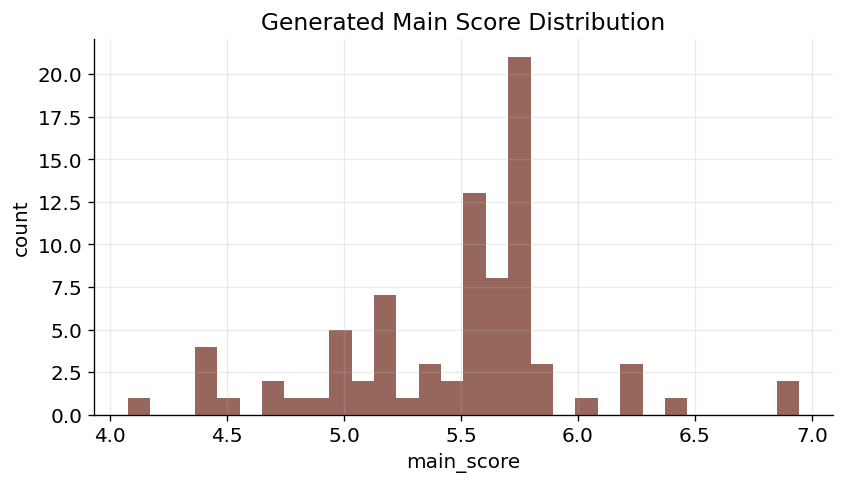

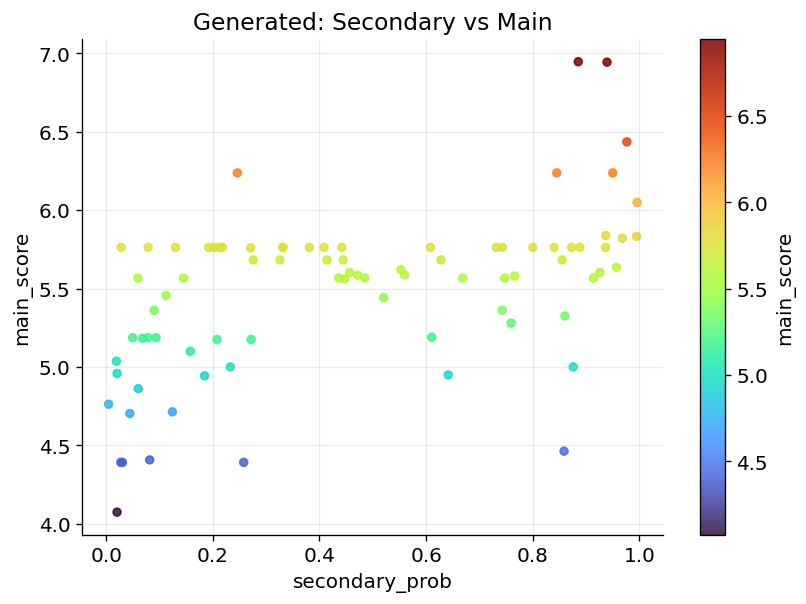

In [20]:
import re


def _safe_tag(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9_.-]+", "_", str(s)).strip("_") or "state"


def _gen_kwargs():
    return dict(
        steps=GEN_STEPS,
        beam_width=GEN_BEAM_WIDTH,
        min_heavy_atoms=GEN_MIN_HEAVY_ATOMS,
        max_heavy_atoms=GEN_MAX_HEAVY_ATOMS,
        min_rings=GEN_MIN_RINGS,
        qed_min=GEN_QED_MIN,
        score_evals_per_step=GEN_SCORE_EVALS_PER_STEP,
        druglike=DRUGLIKE_ENABLE,
        ro5_max_violations=DRUGLIKE_MAX_RO5_VIOLATIONS,
        ro5_max_mw=DRUGLIKE_RO5_MAX_MW,
        ro5_max_logp=DRUGLIKE_RO5_MAX_LOGP,
        ro5_max_hbd=DRUGLIKE_RO5_MAX_HBD,
        ro5_max_hba=DRUGLIKE_RO5_MAX_HBA,
        veber_max_rotb=DRUGLIKE_VEBER_MAX_ROTB,
        veber_max_tpsa=DRUGLIKE_VEBER_MAX_TPSA,
        progress=True,
        progress_leave=False,
    )


states_gen = list(states)
if GEN_TARGETED_MAX_STATES is not None:
    states_gen = states_gen[: int(GEN_TARGETED_MAX_STATES)]

frag_source = (
    labels_train["smiles"].dropna().astype(str).unique().tolist()[:5000]
    if "labels_train" in globals()
    else labels_agg["smiles"].dropna().astype(str).unique().tolist()[:5000]
)

if GEN_TARGETED_PER_POCKET:
    gen_state_dfs = []
    for j, st in enumerate(states_gen):
        tag = _safe_tag(st.state_id)
        dfj = s2d.generate_stepwise(
            target=target,
            states=[st],
            score_model=score_model,
            secondary=secondary,
            filter_config=FILTER_CONFIG,
            pose_config=POSE_CONFIG_TRAIN,
            out_dir=RUN_DIR,
            out_subdir=f"gen_targeted/state_{tag}",
            fragment_source_smiles=frag_source,
            n_molecules=GEN_N_MOLECULES_PER_POCKET,
            seed=1000 + j,
            progress_desc=f"gen_state_{tag}",
            **_gen_kwargs(),
        )
        dfj.insert(0, "state_id", st.state_id)
        gen_state_dfs.append(dfj)

    gen_df = pd.concat(gen_state_dfs, ignore_index=True) if gen_state_dfs else pd.DataFrame()
    if not gen_df.empty:
        out_path = RUN_DIR / "gen_targeted" / "generated_all_states.csv"
        out_path.parent.mkdir(parents=True, exist_ok=True)
        gen_df.to_csv(out_path, index=False)
        print("Saved:", out_path)
else:
    gen_df = s2d.generate_stepwise(
        target=target,
        states=states_gen,
        score_model=score_model,
        secondary=secondary,
        filter_config=FILTER_CONFIG,
        pose_config=POSE_CONFIG_TRAIN,
        out_dir=RUN_DIR,
        out_subdir="gen_targeted",
        fragment_source_smiles=frag_source,
        n_molecules=GEN_N_MOLECULES,
        seed=0,
        progress_desc="gen_targeted",
        **_gen_kwargs(),
    )

# ===== 强制输出指定化合物（对照/基准） =====
force_canons = []
try:
    from rdkit import Chem
    from rdkit.Chem import QED
except Exception as e:
    Chem = None
    QED = None
    print("RDKit import failed; skip FORCE_INCLUDE_SMILES append:", repr(e))

force_list = FORCE_INCLUDE_SMILES_NEUTRAL if "FORCE_INCLUDE_SMILES_NEUTRAL" in globals() else (FORCE_INCLUDE_SMILES if "FORCE_INCLUDE_SMILES" in globals() else [])
if Chem is not None and force_list:
    for _s in force_list:
        m0 = Chem.MolFromSmiles(str(_s))
        if m0 is None:
            continue
        force_canons.append(Chem.MolToSmiles(m0))
    force_canons = sorted(set(force_canons))

if force_canons:
    existing = (
        set(gen_df["smiles"].astype(str).tolist())
        if ("smiles" in gen_df.columns and gen_df is not None and not gen_df.empty)
        else set()
    )
    miss = [s for s in force_canons if s not in existing]
    if miss:
        rows = []
        for smi in miss:
            m = Chem.MolFromSmiles(str(smi))
            if m is None:
                continue

            row = {"design_mode": "reference", "smiles": str(smi), "trajectory_path": ""}

            # 评分（与生成逻辑保持一致：最多取前 6 个 state、每 state 1 pose）
            main = float("nan")
            sec = float("nan")
            try:
                if score_model is not None and states_gen:
                    sc = score_model.score_smiles(
                        str(smi),
                        states=states_gen[: min(6, len(states_gen))],
                        poses_per_state=1,
                        pose_config=POSE_CONFIG_TRAIN,
                        seed=0,
                    )
                    main = float(sc.get("main_score", float("nan")))
            except Exception:
                pass
            try:
                if secondary is not None:
                    sec = float(secondary.predict_proba(str(smi)))
            except Exception:
                pass
            row["main_score"] = main
            row["secondary_prob"] = sec

            # 物化性质 / 过滤器
            try:
                if FILTER_CONFIG is not None:
                    f = s2d.evaluate_filters(m, config=FILTER_CONFIG)
                    for k in [
                        "heavy_atoms",
                        "rings",
                        "MW",
                        "logP",
                        "TPSA",
                        "HBD",
                        "HBA",
                        "RotB",
                        "qed",
                        "filters_pass",
                        "pains_hits",
                        "brenk_hits",
                        "reactive_hits",
                        "sa_score",
                    ]:
                        if k in f:
                            row[k] = f[k]
                else:
                    p = s2d.calc_physchem(m)
                    row.update(p)
                    row.update({"filters_pass": 1, "pains_hits": 0, "brenk_hits": 0, "reactive_hits": 0})
            except Exception:
                pass

            # objective（与 generate_stepwise 默认一致：main + 0.5*(sec-0.5) + 0.5*qed）
            obj = float(main) if np.isfinite(main) else -1e6
            if np.isfinite(sec):
                obj = obj + 0.5 * (sec - 0.5)
            try:
                qed_val = float(row.get("qed", QED.qed(m) if QED is not None else float("nan")))
                if np.isfinite(qed_val):
                    obj = obj + 0.5 * qed_val
            except Exception:
                pass
            row["objective"] = obj

            # Ro5 + Veber（用于与生成表字段对齐）
            try:
                if bool(DRUGLIKE_ENABLE):
                    v = 0
                    reasons = []
                    mw = float(row.get("MW", float("nan")))
                    if (not np.isfinite(mw)) or mw > float(DRUGLIKE_RO5_MAX_MW):
                        v += 1
                        reasons.append("MW")
                    logp = float(row.get("logP", float("nan")))
                    if (not np.isfinite(logp)) or logp > float(DRUGLIKE_RO5_MAX_LOGP):
                        v += 1
                        reasons.append("logP")
                    hbd = int(row.get("HBD", 0))
                    if hbd > int(DRUGLIKE_RO5_MAX_HBD):
                        v += 1
                        reasons.append("HBD")
                    hba = int(row.get("HBA", 0))
                    if hba > int(DRUGLIKE_RO5_MAX_HBA):
                        v += 1
                        reasons.append("HBA")
                    row["ro5_violations"] = int(v)
                    row["ro5_pass"] = 1 if int(v) <= int(DRUGLIKE_MAX_RO5_VIOLATIONS) else 0
                    row["ro5_fail_reasons"] = reasons
                    rotb = int(row.get("RotB", 0))
                    tpsa = float(row.get("TPSA", float("nan")))
                    veber_ok = (rotb <= int(DRUGLIKE_VEBER_MAX_ROTB)) and (
                        np.isfinite(tpsa) and tpsa <= float(DRUGLIKE_VEBER_MAX_TPSA)
                    )
                    row["veber_pass"] = 1 if veber_ok else 0
            except Exception:
                pass

            rows.append(row)

        if rows:
            ref_df = pd.DataFrame(rows)
            if "state_id" in gen_df.columns:
                ref_df.insert(0, "state_id", -1)
            gen_df = pd.concat([gen_df, ref_df], ignore_index=True, sort=False)
            # per-pocket 模式下，覆盖保存一份包含 reference 的总表
            if bool(GEN_TARGETED_PER_POCKET):
                try:
                    out_path2 = RUN_DIR / "gen_targeted" / "generated_all_states.csv"
                    out_path2.parent.mkdir(parents=True, exist_ok=True)
                    gen_df.to_csv(out_path2, index=False)
                except Exception:
                    pass

display(gen_df.head(10))

if force_canons and ("smiles" in gen_df.columns):
    ref_view = gen_df[gen_df["smiles"].astype(str).isin(force_canons)].copy()
    print({"force_include_in_gen_df": int(len(ref_view)), "expected": int(len(force_canons))})
    try:
        cols = [
            c
            for c in ["state_id", "design_mode", "smiles", "main_score", "secondary_prob", "objective", "filters_pass"]
            if c in ref_view.columns
        ]
        display(ref_view[cols].head(20))
    except Exception:
        pass

# ===== 生成结果可视化 =====
try:
    vals = gen_df["main_score"].dropna().astype(float).to_numpy()
    if len(vals):
        fig, ax = plt.subplots(figsize=(7.2, 4.2))
        ax.hist(vals, bins=30, color=S2D_COLORWAY[5], alpha=0.9)
        ax.set_title("Generated Main Score Distribution")
        ax.set_xlabel("main_score")
        ax.set_ylabel("count")
        savefig(fig, FIG_DIR / "gen_main_score_distribution.png")
        plt.show()
except Exception as e:
    print("Skip gen main-score histogram:", repr(e))

if "secondary_prob" in gen_df.columns:
    try:
        dfp = gen_df.dropna(subset=["secondary_prob", "main_score"]).copy()
        if not dfp.empty:
            fig, ax = plt.subplots(figsize=(7.0, 5.2))
            sc = ax.scatter(
                dfp["secondary_prob"].astype(float),
                dfp["main_score"].astype(float),
                c=dfp["main_score"].astype(float),
                cmap="turbo",
                s=22,
                alpha=0.85,
            )
            ax.set_title("Generated: Secondary vs Main")
            ax.set_xlabel("secondary_prob")
            ax.set_ylabel("main_score")
            fig.colorbar(sc, ax=ax, label="main_score")
            savefig(fig, FIG_DIR / "gen_secondary_vs_main.png")
            plt.show()
    except Exception as e:
        print("Skip gen secondary-main scatter:", repr(e))


## 13. 可视化与交互界面

本笔记本提供两条可视化路径（内嵌展示与离线资产）：

1. **内嵌展示**：Matplotlib 静态图（VS Code/Jupyter 直接可显示）
2. **离线资产**：所有关键图都会写到 `runs/<RUN_ID>/figures/*.png`，即使在笔记本环境中无法渲染也能直接打开查看

若图形或交互控件无法显示，可参考第 0 节的可视化依赖与故障排查。若无法导入 ipywidgets，将自动回退到静态展示（不影响流程执行）。

---


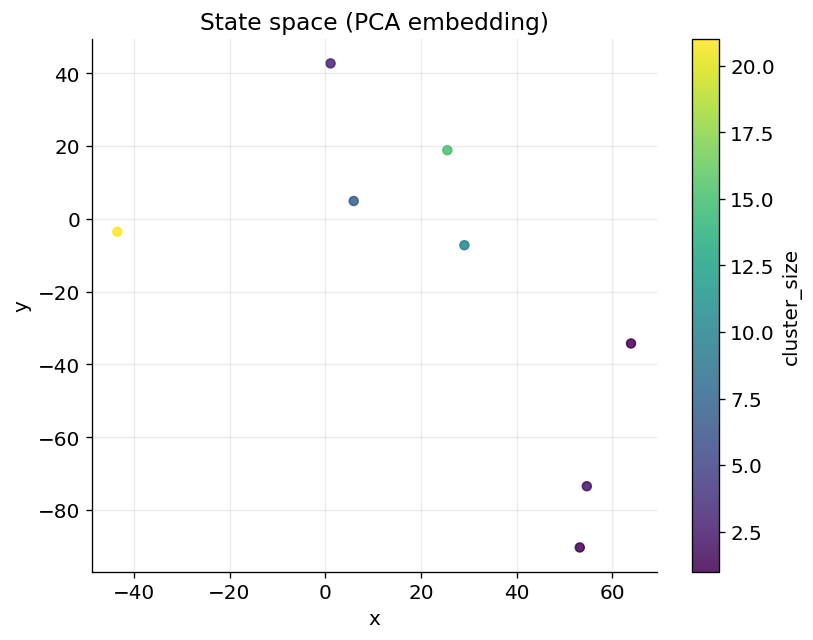

In [21]:
emb = np.array([s.features["embedding"] for s in states], dtype=float)
state_df = pd.DataFrame({"state_id": [s.state_id for s in states], "size": [s.features["cluster_size"] for s in states]})
state_df["x"] = emb[:, 0]
state_df["y"] = emb[:, 1] if emb.shape[1] > 1 else 0.0
try:
    fig, ax = plt.subplots(figsize=(7.0, 5.5))
    sc = ax.scatter(
        state_df["x"].astype(float),
        state_df["y"].astype(float),
        c=state_df["size"].astype(float),
        cmap="viridis",
        s=28,
        alpha=0.85,
    )
    ax.set_title("State space (PCA embedding)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(sc, ax=ax, label="cluster_size")
    savefig(fig, FIG_DIR / "state_space_pca.png")
    plt.show()
except Exception as e:
    print("Skip state embedding plot:", repr(e))


In [22]:
from pathlib import Path

# 默认关闭 3Dmol：某些前端（尤其 VS Code）会阻止远程 JS，导致输出里出现 "3Dmol.js failed to load"。
# 如需交互式 3D，可将其设为 True，并在前端允许加载远程内容。
ENABLE_3DMOL = False


def _print_widget_help():
    print(
        "If widgets are not displayed, ensure ipywidgets is installed and enabled (see Section 0: visualization dependencies and troubleshooting)."
    )
    if not ENABLE_3DMOL:
        print("3D view is disabled by default (set ENABLE_3DMOL=True to try py3Dmol/3Dmol.js).")
    else:
        print(
            "If you see '3Dmol.js failed to load', your notebook front-end may block remote JS (common in VS Code). "
            "Allow remote content or open the notebook in JupyterLab/Notebook, or open the PDB file in PyMOL/ChimeraX."
        )


def _show_state_info_static(st):
    print({"state_id": st.state_id, **st.features})
    print(st.provenance)
    pdb_path = st.provenance.get("rep_pdb_path")
    print({"rep_pdb_path": pdb_path})
    if pdb_path and Path(pdb_path).exists():
        txt = Path(pdb_path).read_text(encoding="utf-8", errors="ignore").splitlines()[:12]
        print("\n".join(txt))


def _try_show_pdb_3dmol(pdb_path: str, *, width: int = 520, height: int = 300):
    if not ENABLE_3DMOL:
        return
    try:
        import py3Dmol

        view = py3Dmol.view(width=width, height=height)
        view.addModel(Path(pdb_path).read_text(encoding="utf-8", errors="ignore"), "pdb")
        view.setStyle({"stick": {"radius": 0.18}})
        view.zoomTo()
        view.show()
    except Exception as e:
        print("py3Dmol render skipped:", repr(e))


try:
    import ipywidgets as widgets
    from IPython.display import display
except Exception as e:
    widgets = None
    display = None
    print("ipywidgets import failed:", repr(e))
    _print_widget_help()

if not states:
    print("No states available.")
elif widgets is None:
    # 回退策略：输出前若干 state 的摘要信息，确保流程继续执行
    for st in states[:3]:
        _show_state_info_static(st)
else:
    _print_widget_help()

    state_options = [(f"state {s.state_id} | n={s.features.get('cluster_size')}", s.state_id) for s in states]
    state_dd = widgets.Dropdown(options=state_options, description="State")

    def show_state(state_id: str):
        st = [s for s in states if s.state_id == state_id][0]
        display({"state_id": st.state_id, **st.features})
        display(st.provenance)
        pdb_path = st.provenance.get("rep_pdb_path")
        display({"rep_pdb_path": pdb_path})
        if pdb_path and Path(pdb_path).exists():
            txt = Path(pdb_path).read_text(encoding="utf-8", errors="ignore").splitlines()[:12]
            print("\n".join(txt))
            _try_show_pdb_3dmol(pdb_path)

    widgets.interact(show_state, state_id=state_dd);


If widgets are not displayed, ensure ipywidgets is installed and enabled (see Section 0: visualization dependencies and troubleshooting).
3D view is disabled by default (set ENABLE_3DMOL=True to try py3Dmol/3Dmol.js).


interactive(children=(Dropdown(description='State', options=(('state 00 | n=2', '00'), ('state 01 | n=21', '01…

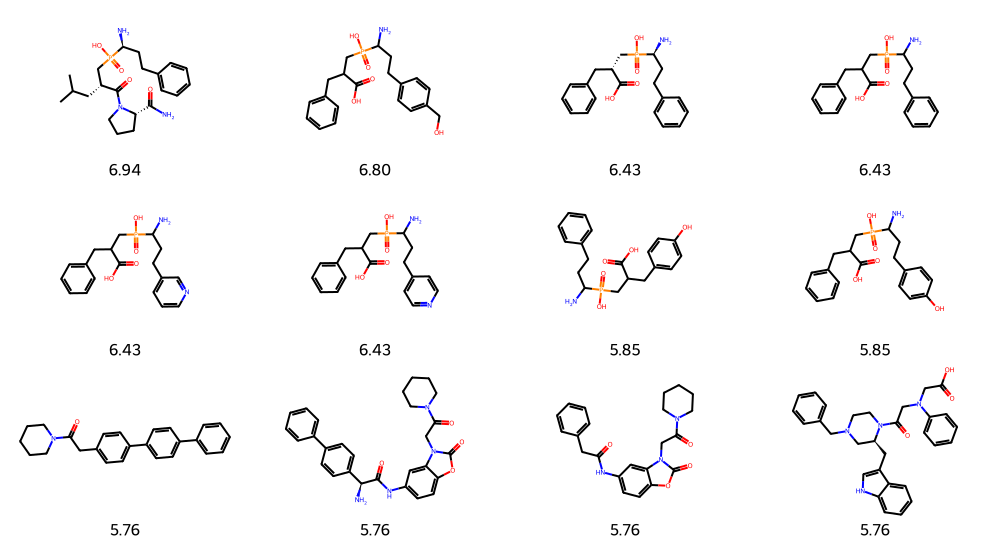

若未显示 ipywidgets 交互控件，请参考第 0 节完成安装与启用；亦可使用上方静态表格/图像，并查看 runs/<RUN_ID>/figures/*.html。


interactive(children=(Dropdown(description='Hit', options=(('00 | 6.94 | CC(C)C[C@H](CP(=O)(O)[C@@H](N)CCc1ccc…

In [23]:
import json

import numpy as np
import pandas as pd
from IPython.display import display
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw

hits_view = hits2 if "hits2" in globals() else hits
score_col = "main_refined" if ("main_refined" in hits_view.columns) else "main_score"

# ===== 静态概览（在无交互控件环境下仍可复现） =====
try:
    top = hits_view.sort_values(score_col, ascending=False).head(12).reset_index(drop=True)
    mols = []
    legends = []
    for _, row in top.iterrows():
        m = Chem.MolFromSmiles(str(row["smiles"]))
        if m is None:
            continue
        mols.append(m)
        legends.append(f"{float(row[score_col]):.2f}")
    if mols:
        display(Draw.MolsToGridImage(mols, legends=legends, molsPerRow=4, subImgSize=(250, 180)))
except Exception as e:
    print("Skip static hit grid:", repr(e))

# ===== 解释性：为每个候选检索最相似的训练活性（按指纹相似度） =====
ref_df = labels_train if "labels_train" in globals() else labels_agg
ref_df = ref_df.dropna(subset=["smiles", "pActivity"]).copy()
ref_df = ref_df.drop_duplicates(subset=["smiles"]).reset_index(drop=True)
ref_act = ref_df[ref_df["pActivity"].astype(float) >= float(BINDINGDB_ACTIVE_THRESHOLD_PACT)].copy()
if ref_act.empty:
    ref_act = ref_df.copy()
ref_act = ref_act.sample(n=min(len(ref_act), 2000), random_state=0).reset_index(drop=True)
ref_mols = []
ref_fps = []
ref_meta = []
for smi, pa in ref_act[["smiles", "pActivity"]].itertuples(index=False, name=None):
    m = Chem.MolFromSmiles(str(smi))
    if m is None:
        continue
    ref_mols.append(m)
    ref_fps.append(AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048))
    ref_meta.append({"smiles": Chem.MolToSmiles(m), "pActivity": float(pa)})


def _print_widget_help():
    print(
        "若未显示 ipywidgets 交互控件，请参考第 0 节完成安装与启用；亦可使用上方静态表格/图像，并查看 runs/<RUN_ID>/figures/*.html。"
    )


def show_hit_row(row: pd.Series):
    smi = str(row["smiles"])
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        display(Draw.MolToImage(mol, size=(280, 200)))
    display(row)
    try:
        if "state_profile_json" in row and pd.notna(row["state_profile_json"]):
            display(pd.Series(json.loads(row["state_profile_json"])).sort_values(ascending=False).to_frame("state_score"))
    except Exception:
        pass

    # 相似活性检索（用于解释候选的潜在活性依据）
    try:
        if mol is not None and ref_fps:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
            sims = DataStructs.BulkTanimotoSimilarity(fp, ref_fps)
            order = np.argsort(np.array(sims))[::-1][:8]
            mols = [ref_mols[i] for i in order]
            legends = [f"sim={sims[i]:.2f} | pA={ref_meta[i]['pActivity']:.2f}" for i in order]
            display(Draw.MolsToGridImage(mols, legends=legends, molsPerRow=4, subImgSize=(250, 180)))
    except Exception as e:
        print("Skip similarity explain:", repr(e))

    ev_path = RUN_DIR / "htvs" / "evidence" / f"{row['candidate_id']}.json"
    display(ev_path)


# ===== 交互控件（可选） =====
try:
    import ipywidgets as widgets
except Exception as e:
    widgets = None
    print("ipywidgets import failed:", repr(e))
    _print_widget_help()

if hits_view is None or hits_view.empty:
    print("No hits to show.")
elif widgets is None:
    # 回退策略：展示最佳候选（静态图）
    row0 = hits_view.sort_values(score_col, ascending=False).iloc[0]
    show_hit_row(row0)
else:
    _print_widget_help()

    hit_options = [
        (f"{i:02d} | {row[score_col]:.2f} | {row['smiles']}", row["candidate_id"]) for i, row in hits_view.reset_index(drop=True).iterrows()
    ]
    hit_dd = widgets.Dropdown(options=hit_options, description="Hit")

    def show_hit(candidate_id: str):
        row = hits_view[hits_view["candidate_id"] == candidate_id].iloc[0]
        show_hit_row(row)

    widgets.interact(show_hit, candidate_id=hit_dd);


### 化学空间视图（hits / generated / labels）

用分子指纹做 PCA 投影，比较命中/生成/已知活性在化学空间的分布对齐，用于：

- 判断生成分子是否“落在训练分布附近”还是明显 out-of-domain
- 解释 HTVS 命中是否集中在某些 scaffold


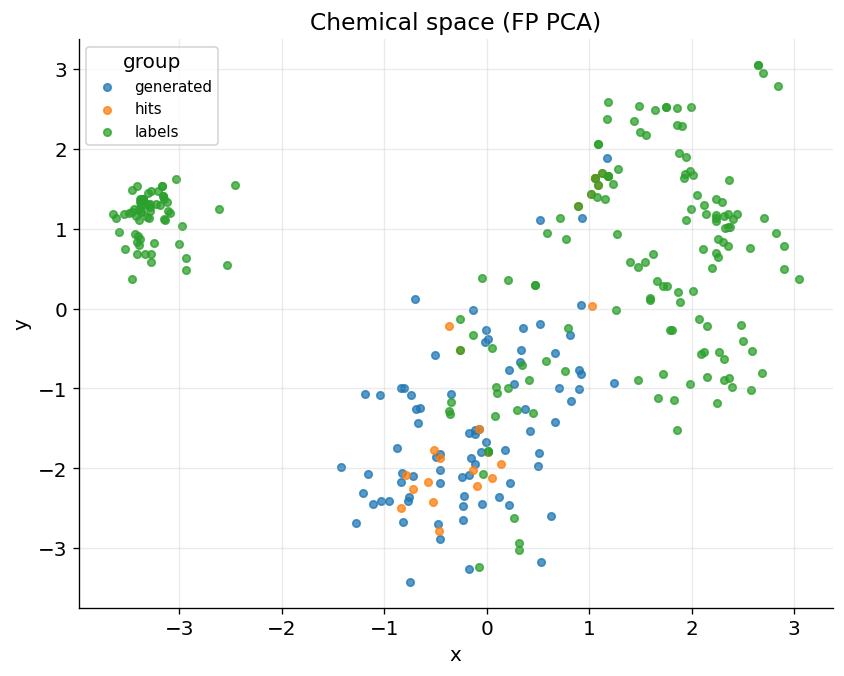

In [24]:
from sklearn.decomposition import PCA

from rdkit import Chem

hits_view = hits2 if "hits2" in globals() else hits


def _fp(smi: str) -> np.ndarray:
    m = Chem.MolFromSmiles(smi)
    if m is None:
        raise ValueError("bad smiles")
    return s2d.morgan_fp_bits(m, n_bits=256)


groups = [
    ("hits", hits_view["smiles"].dropna().astype(str).unique().tolist()[:200]),
    ("generated", gen_df["smiles"].dropna().astype(str).unique().tolist()[:200]),
    ("labels", labels_agg["smiles"].dropna().astype(str).unique().tolist()[:200]),
]

rows = []
fps = []
for g, smis in groups:
    for smi in smis:
        try:
            fp = _fp(smi)
        except Exception:
            continue
        rows.append({"group": g, "smiles": smi})
        fps.append(fp)

X = np.stack(fps, axis=0)
xy = PCA(n_components=2, random_state=0).fit_transform(X)
cs_df = pd.DataFrame(rows)
cs_df["x"] = xy[:, 0]
cs_df["y"] = xy[:, 1]

try:
    fig, ax = plt.subplots(figsize=(7.2, 5.8))
    for i, (g, d) in enumerate(cs_df.groupby("group")):
        ax.scatter(
            d["x"].astype(float),
            d["y"].astype(float),
            s=20,
            alpha=0.75,
            label=str(g),
            color=S2D_COLORWAY[i % len(S2D_COLORWAY)],
        )
    ax.set_title("Chemical space (FP PCA)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(title="group", fontsize=9)
    savefig(fig, FIG_DIR / "chemspace_hits_generated_labels.png")
except Exception:
    pass
plt.show()


### 生成轨迹播放器（逐步帧）

从 `runs/<RUN_ID>/gen_targeted/trajectories/*.sdf`（或 `gen_nontargeted/trajectories/*.sdf`）读取某个分子的中间步骤，并用 slider 逐帧浏览。

如果 ipywidgets 无法显示，仍然可以直接打开对应的 `.sdf`，或在 `generated.csv` 中查看 `trajectory_path`。 


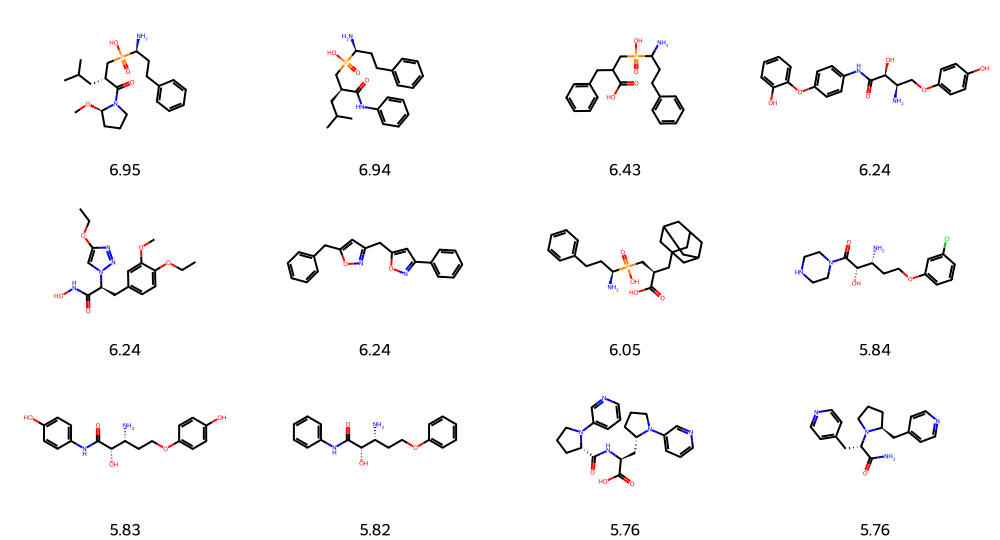

若未显示 ipywidgets 交互控件，请参考第 0 节完成安装与启用；轨迹文件仍会写入磁盘，可直接打开下方给出的 SDF 路径。


Dropdown(description='Traj', options=(('00 | 6.95 | CO[C@@H]1CCCN1C(=O)[C@H](CC(C)C)CP(=O)(O)[C@@H](N)CCc1cccc…

IntSlider(value=0, description='Step', max=0)

Output()

In [25]:
import pandas as pd
from IPython.display import display
from rdkit import Chem
from rdkit.Chem import Draw


def _print_widget_help():
    print(
        "若未显示 ipywidgets 交互控件，请参考第 0 节完成安装与启用；轨迹文件仍会写入磁盘，可直接打开下方给出的 SDF 路径。"
    )


def _load_traj(path: str):
    suppl = Chem.SDMolSupplier(str(path), removeHs=False)
    mols = [m for m in suppl if m is not None]

    def _k(m):
        return int(m.GetProp("step")) if m.HasProp("step") else 0

    mols.sort(key=_k)
    return mols


if "gen_df" not in globals() or gen_df is None or gen_df.empty:
    print("No generated molecules to show.")
else:
    gen_view = gen_df.sort_values("main_score", ascending=False).reset_index(drop=True)

    # 静态概览：前 12 个生成分子
    try:
        top = gen_view.head(12)
        mols = []
        legends = []
        for _, r in top.iterrows():
            m = Chem.MolFromSmiles(str(r["smiles"]))
            if m is None:
                continue
            mols.append(m)
            legends.append(f"{float(r['main_score']):.2f}")
        if mols:
            display(Draw.MolsToGridImage(mols, legends=legends, molsPerRow=4, subImgSize=(250, 180)))
    except Exception as e:
        print("Skip generated grid:", repr(e))

    # 交互控件（可选）
    try:
        import ipywidgets as widgets
    except Exception as e:
        widgets = None
        print("ipywidgets import failed:", repr(e))
        _print_widget_help()

    if widgets is None:
        # 回退策略：展示最佳分子的起始/中间/末端三帧（静态图）
        p = str(gen_view.iloc[0]["trajectory_path"])
        print("trajectory_path=", p)
        mols = _load_traj(p)
        if mols:
            idxs = sorted(set([0, len(mols) // 2, len(mols) - 1]))
            for i in idxs:
                m = Chem.RemoveHs(mols[i])
                display(Draw.MolToImage(m, size=(280, 200)))
                print("step=", i, "smiles=", Chem.MolToSmiles(m))
    else:
        _print_widget_help()

        gen_options = [
            (f"{i:02d} | {row['main_score']:.2f} | {row['smiles']}", row["trajectory_path"]) for i, row in gen_view.iterrows()
        ]
        traj_dd = widgets.Dropdown(options=gen_options, description="Traj")
        step_slider = widgets.IntSlider(min=0, max=0, step=1, value=0, description="Step")
        out = widgets.Output()

        state = {"mols": []}

        def _render(i: int):
            with out:
                out.clear_output(wait=True)
                if not state["mols"]:
                    print("No trajectory loaded")
                    return
                m = state["mols"][i]
                m2 = Chem.RemoveHs(m)
                display(Draw.MolToImage(m2, size=(280, 200)))
                print("step=", i, "smiles=", Chem.MolToSmiles(m2))

        def _on_select(change):
            state["mols"] = _load_traj(change["new"])
            step_slider.max = max(0, len(state["mols"]) - 1)
            step_slider.value = 0
            _render(0)

        traj_dd.observe(_on_select, names="value")
        step_slider.observe(lambda ch: _render(ch["new"]), names="value")

        display(traj_dd, step_slider, out)
        _on_select({"new": traj_dd.value})


## 14. 评估与报表产出（本笔记本已实现的内容）

当前实现的最小生成评估指标（MOSES 风格）：

- 有效性（valid）、唯一性（unique）、新颖性（novel vs training set）

此外本笔记本还会输出：

- 训练集/活性分布、化学空间投影、scaffold 统计
- QSAR 回归/分类的训练效果与解释（parity/residual/applicability domain + 重要 bit 子结构）
- HTVS 命中分布与 state-profile（并可回溯每个 hit 的 evidence JSON）
- 生成分子与训练分子的属性对比图

如需更完整的生成评估（SNN/IntDiv/SA/PAINS 等），可在 `state2drug.eval_generation_metrics()` 基础上扩展实现。


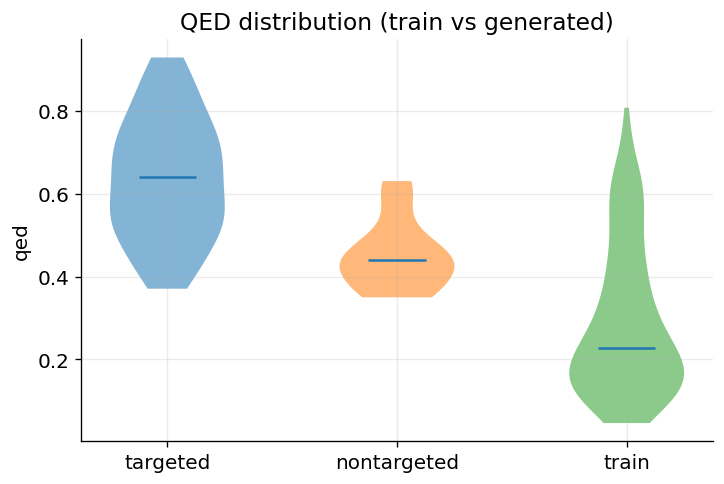

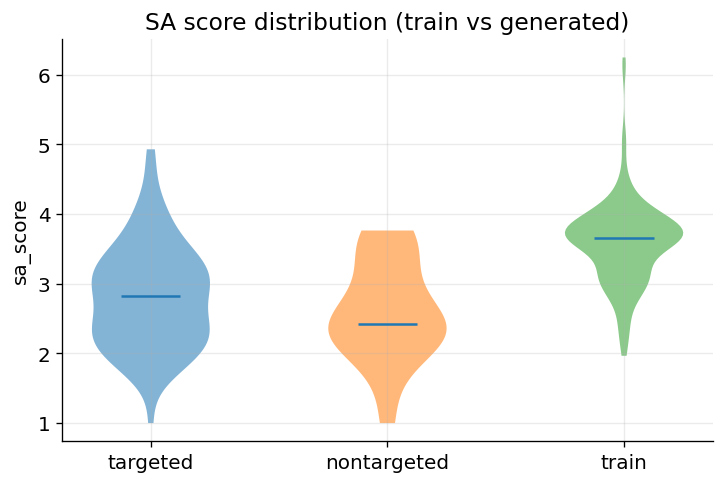

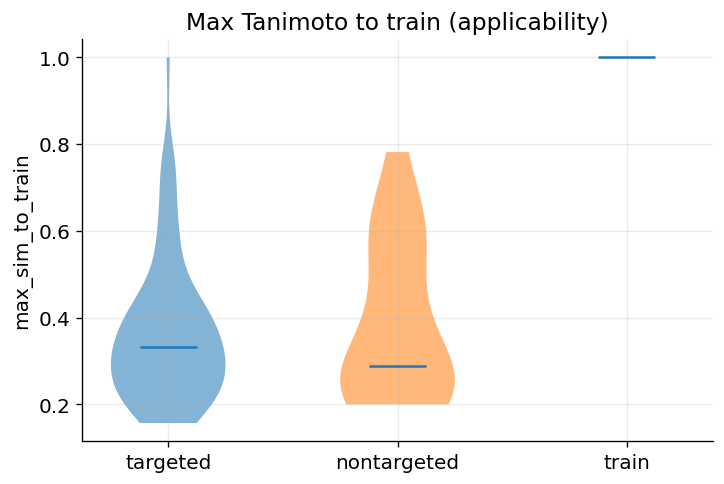

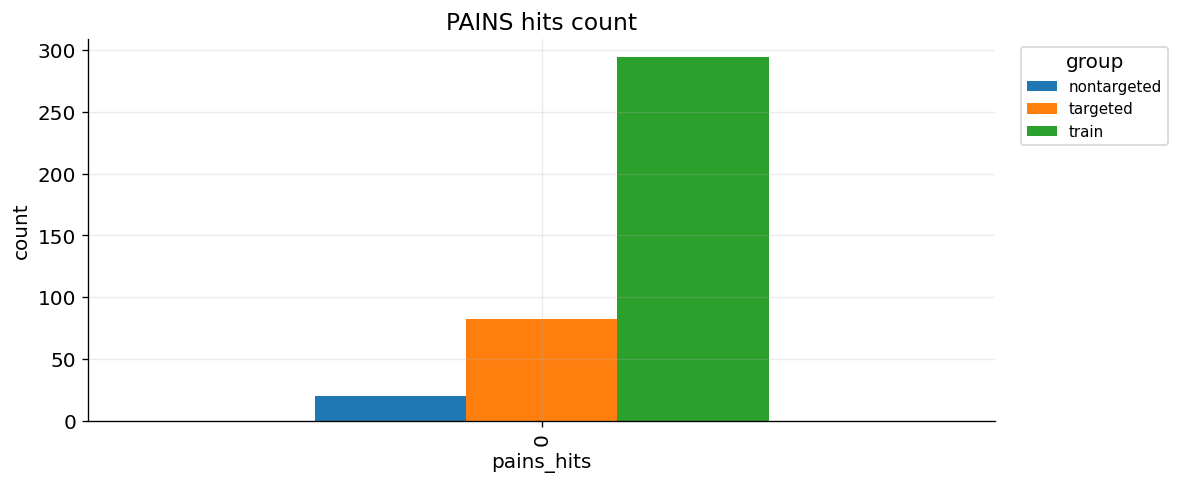

In [26]:
ref_smiles = set(labels_train["smiles"].dropna().astype(str).tolist())
rows = []
if "gen_df" in globals():
    rows.append(
        {
            "mode": "targeted",
            **s2d.eval_generation_metrics(
                gen_df["smiles"].tolist(),
                reference_smiles=ref_smiles,
                filter_config=FILTER_CONFIG,
                fp_bits=2048,
                radius=2,
            ),
        }
    )
if "gen_nt_df" in globals():
    rows.append(
        {
            "mode": "nontargeted",
            **s2d.eval_generation_metrics(
                gen_nt_df["smiles"].tolist(),
                reference_smiles=ref_smiles,
                filter_config=FILTER_CONFIG,
                fp_bits=2048,
                radius=2,
            ),
        }
    )

metrics_df = pd.DataFrame(rows)
metrics_df

# ===== 更完整的生成评估可视化（SA/PAINS/相似度/分布） =====
try:
    from rdkit import Chem, DataStructs
    from rdkit.Chem import AllChem

    ref_mols = []
    ref_fps = []
    for s in list(ref_smiles)[:5000]:
        m = Chem.MolFromSmiles(str(s))
        if m is None:
            continue
        ref_mols.append(m)
        ref_fps.append(AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048))

    def _per_mol(smiles_list, group: str):
        rows = []
        for s in smiles_list:
            m = Chem.MolFromSmiles(str(s))
            if m is None:
                continue
            f = s2d.evaluate_filters(m, config=(FILTER_CONFIG or s2d.FilterConfig(sa_max=None, qed_min=None)))
            fp = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048)
            max_sim = float("nan")
            if ref_fps:
                sims = DataStructs.BulkTanimotoSimilarity(fp, ref_fps)
                max_sim = float(max(sims)) if sims else 0.0
            rows.append(
                {
                    "group": group,
                    "smiles": Chem.MolToSmiles(m),
                    "qed": float(f.get("qed", float("nan"))),
                    "sa_score": float(f.get("sa_score", float("nan"))),
                    "pains_hits": int(f.get("pains_hits", 0)),
                    "reactive_hits": int(f.get("reactive_hits", 0)),
                    "max_sim_to_train": max_sim,
                }
            )
        return pd.DataFrame(rows)

    dist_rows = []
    if "gen_df" in globals() and gen_df is not None and not gen_df.empty:
        dist_rows.append(_per_mol(gen_df["smiles"].dropna().astype(str).tolist(), "targeted"))
    if "gen_nt_df" in globals() and gen_nt_df is not None and not gen_nt_df.empty:
        dist_rows.append(_per_mol(gen_nt_df["smiles"].dropna().astype(str).tolist(), "nontargeted"))

    # 对比训练集分布
    train_smiles = labels_train["smiles"].dropna().astype(str).unique().tolist()
    dist_rows.append(_per_mol(train_smiles[: min(len(train_smiles), 2000)], "train"))

    dist_df = pd.concat(dist_rows, ignore_index=True)

    def _violin_by_group(df: pd.DataFrame, ycol: str, title: str, out_png: str):
        groups = [g for g in df["group"].dropna().astype(str).unique().tolist()]
        data = [df.loc[df["group"] == g, ycol].dropna().astype(float).to_numpy() for g in groups]
        if not any(len(v) for v in data):
            return
        fig_w = max(6.2, 1.6 * len(groups))
        fig, ax = plt.subplots(figsize=(fig_w, 4.2))
        parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=False)
        for i, b in enumerate(parts.get("bodies", [])):
            b.set_facecolor(S2D_COLORWAY[i % len(S2D_COLORWAY)])
            b.set_alpha(0.55)
        ax.set_xticks(list(range(1, len(groups) + 1)))
        ax.set_xticklabels(groups)
        ax.set_title(title)
        ax.set_ylabel(ycol)
        savefig(fig, FIG_DIR / out_png)
        plt.show()

    _violin_by_group(dist_df, "qed", "QED distribution (train vs generated)", "eval_qed_distribution.png")
    _violin_by_group(dist_df, "sa_score", "SA score distribution (train vs generated)", "eval_sa_distribution.png")
    _violin_by_group(dist_df, "max_sim_to_train", "Max Tanimoto to train (applicability)", "eval_maxsim_to_train.png")

    try:
        tab = pd.crosstab(dist_df["pains_hits"].fillna(0).astype(int), dist_df["group"].astype(str))
        fig, ax = plt.subplots(figsize=(10.0, 4.2))
        tab.plot(kind="bar", ax=ax, color=[S2D_COLORWAY[i % len(S2D_COLORWAY)] for i in range(tab.shape[1])])
        ax.set_title("PAINS hits count")
        ax.set_xlabel("pains_hits")
        ax.set_ylabel("count")
        ax.legend(title="group", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)
        savefig(fig, FIG_DIR / "eval_pains_hits.png")
        plt.show()
    except Exception as e:
        print("Skip PAINS hits bar plot:", repr(e))

except Exception as e:
    print("Skip extended generation eval plots:", repr(e))


## 15. 候选化合物枚举与 GPU 亲和力评估（SMILES + ERAP2 序列）

本段新增两个关键能力：

- **候选枚举**：把 HTVS / 生成 / 外部库（`lib_path`）产生的所有 SMILES 合并、规范化、去重，并落盘到 `runs/<RUN_ID>/candidates/`
- **快速亲和力评估（可 GPU）**：基于 `SMILES + ERAP2_HUMAN.fasta` 序列训练/加载一个轻量 DTI 模型，并对全部候选做批量推理（GPU 上非常快）
  - 依赖 `torch`（可使用 CPU 版 PyTorch 运行；安装方法见「0. 环境与快速开始」）
  - 若 `torch.cuda.is_available()` 为 False：表示当前使用 CPU 设备；如需 GPU，请安装与本机 CUDA 版本匹配的 PyTorch CUDA 构建（示例：`conda install pytorch pytorch-cuda=12.1 -c pytorch -c nvidia`）

说明：当前笔记本以单一靶点（ERAP2）为例，序列在训练/推理时为常量；但接口保持为“SMILES + 序列”，便于后续扩展到多靶点/多序列的 GPU 推理。


In [27]:
seq_erap2 = s2d.read_fasta_sequence(ERAP2_FASTA)
print("ERAP2 sequence length:", len(seq_erap2), "aa")

try:
    import torch

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print("Affinity device:", DEVICE)
    if DEVICE == "cuda":
        print("GPU:", torch.cuda.get_device_name(0))
except Exception as e:
    DEVICE = "cpu"
    print("PyTorch not available; set up torch to enable GPU inference:", repr(e))


ERAP2 sequence length: 960 aa
Affinity device: cuda
GPU: NVIDIA GeForce RTX 4080


Unique candidates: 196 | saved: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/runs/ERAP2_20260129_110535/candidates/candidates_all.csv


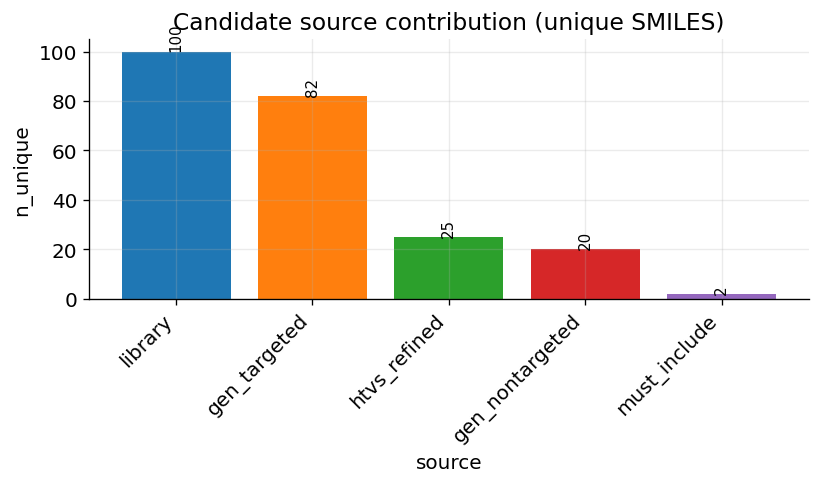

,candidate_id,smiles,sources,score_best,main_best,objective,main_refined,main_score,secondary_prob,combined,n_sources
0,cand_000051,CO[C@@H]1CCCN1C(=O)[C@H](CC(C)C)CP(=O)(O)[C@@H...,gen_targeted,7.427073,6.946079,7.427073,NaN,6.946079,0.885331,NaN,1
1,cand_000017,CC(C)C[C@@H](CP(=O)(O)[C@@H](N)CCc1ccccc1)C(=O...,gen_targeted,7.418570,6.943332,7.418570,NaN,6.943332,0.939297,NaN,1
2,cand_000086,NC(CCc1ccccc1)P(=O)(O)CC(Cc1ccccc1)C(=O)O,"gen_targeted,htvs_refined,library",6.971019,6.434782,6.971019,6.434782,6.434782,0.976543,6.911325,3
3,cand_000018,CC(C)C[C@H](CP(=O)(O)[C@@H](N)CCc1ccccc1)C(=O)...,"htvs_refined,library",6.943332,6.943332,NaN,6.943332,6.943332,0.989583,7.432914,2
4,cand_000082,NC(CCc1ccc(CO)cc1)P(=O)(O)CC(Cc1ccccc1)C(=O)O,"htvs_refined,library",6.802565,6.802565,NaN,6.802565,6.802565,0.926678,7.229243,2
5,cand_000038,CCOc1cn([C@@H](Cc2ccc(OCC)c(OC)c2)C(=O)NO)nn1,gen_targeted,6.669385,6.237181,6.669385,NaN,6.237181,0.845075,NaN,1
6,cand_000114,N[C@H](COc1ccc(O)cc1)[C@H](O)C(=O)Nc1ccc(Oc2cc...,gen_targeted,6.654825,6.237181,6.654825,NaN,6.237181,0.950051,NaN,1
7,cand_000098,N[C@@H](CCc1ccccc1)P(=O)(O)C[C@@H](CC12CC3CC(C...,gen_targeted,6.552979,6.048920,6.552979,NaN,6.048920,0.995665,NaN,1
8,cand_000100,N[C@@H](CCc1ccccc1)P(=O)(O)C[C@@H](Cc1ccccc1)C...,"htvs_refined,library",6.434782,6.434782,NaN,6.434782,6.434782,0.976543,6.911325,2
9,cand_000087,NC(CCc1cccnc1)P(=O)(O)CC(Cc1ccccc1)C(=O)O,"htvs_refined,library",6.434782,6.434782,NaN,6.434782,6.434782,0.981003,6.915786,2


{'force_include_total': 2, 'missing_in_candidates': []}


,candidate_id,smiles,sources,score_best,main_best,objective,main_refined,main_score,secondary_prob,combined,n_sources
49,cand_000138,O=C(NC[C@@H]1Cc2cccc(-c3cccnc3)c2O1)c1ccc2c(c1...,"gen_targeted,htvs_refined,library,must_include",5.877412,5.762473,5.877412,5.762473,5.762473,0.191945,5.454418,4
57,cand_000109,N[C@H](C(=O)Nc1ccc2oc(=O)n(CC(=O)N3CCCCC3)c2c1...,"gen_targeted,htvs_refined,library,must_include",5.767400,5.762473,5.767400,5.762473,5.762473,0.078734,5.341206,4


In [28]:
from pathlib import Path

from rdkit import Chem

cand_tables = []

# 强制输出的参考/基准化合物（确保最终 candidates 表一定包含）
force_list = FORCE_INCLUDE_SMILES_NEUTRAL if "FORCE_INCLUDE_SMILES_NEUTRAL" in globals() else (FORCE_INCLUDE_SMILES if "FORCE_INCLUDE_SMILES" in globals() else [])
if force_list:
    cand_tables.append(pd.DataFrame({"smiles": force_list, "source": "must_include"}))

# 1) 输入库（可选）：把 screening library 也作为“候选集合”输出，便于后续统一做亲和力推理
if "lib_path" in globals():
    lp = Path(lib_path)
    if lp.exists():
        smis = []
        for line in lp.read_text(encoding="utf-8", errors="ignore").splitlines():
            line = line.strip()
            if not line:
                continue
            smis.append(line.split()[0])
        if smis:
            cand_tables.append(pd.DataFrame({"smiles": smis, "source": "library"}))

# 2) HTVS 结果
if "hits" in globals() and hits is not None and not hits.empty:
    t = hits.copy()
    t["source"] = "htvs_stage1"
    cand_tables.append(t)

if "hits2" in globals() and hits2 is not None and not hits2.empty:
    t = hits2.copy()
    t["source"] = "htvs_refined"
    cand_tables.append(t)

if "hits_druggen" in globals() and hits_druggen is not None and not hits_druggen.empty:
    t = hits_druggen.copy()
    t["source"] = "druggen_htvs"
    cand_tables.append(t)

# 3) 生成结果
if "gen_df" in globals() and gen_df is not None and not gen_df.empty:
    t = gen_df.copy()
    t["source"] = "gen_targeted"
    cand_tables.append(t)

if "gen_nt_df" in globals() and gen_nt_df is not None and not gen_nt_df.empty:
    t = gen_nt_df.copy()
    t["source"] = "gen_nontargeted"
    cand_tables.append(t)

if not cand_tables:
    raise RuntimeError("No candidate sources found (run HTVS and/or generation first).")

cand_raw = pd.concat(cand_tables, ignore_index=True, sort=False)
cand_raw["smiles"] = cand_raw["smiles"].astype(str)

def _canon(s: str):
    m = Chem.MolFromSmiles(str(s))
    if m is None:
        return None
    return Chem.MolToSmiles(m)

cand_raw["smiles_canon"] = cand_raw["smiles"].map(_canon)
cand_raw = cand_raw.dropna(subset=["smiles_canon"]).copy()
cand_raw["smiles"] = cand_raw["smiles_canon"].astype(str)
cand_raw = cand_raw.drop(columns=["smiles_canon"])

def _max(series) -> float:
    try:
        return float(pd.to_numeric(series, errors="coerce").max())
    except Exception:
        return float("nan")

candidates = (
    cand_raw.groupby("smiles", as_index=False)
    .agg(
        sources=("source", lambda x: ",".join(sorted(set(x.astype(str).tolist())))),
        n_sources=("source", lambda x: int(pd.Series(x.astype(str)).nunique())),
        main_score=("main_score", _max),
        main_refined=("main_refined", _max),
        objective=("objective", _max),
        secondary_prob=("secondary_prob", _max),
        combined=("combined", _max),
    )
)

candidates.insert(0, "candidate_id", [f"cand_{i:06d}" for i in range(1, len(candidates) + 1)])
num_cols = ["main_score", "main_refined", "objective", "secondary_prob", "combined"]
for c in num_cols:
    if c in candidates.columns:
        candidates[c] = pd.to_numeric(candidates[c], errors="coerce")

# Derived convenience scores (avoid confusing NaNs for unscreened/library-only molecules)
# - main_best: best available pocket-state score
# - score_best: best overall score (objective preferred, otherwise main_best)
candidates["main_best"] = candidates[["main_refined", "main_score"]].max(axis=1, skipna=True)
candidates["score_best"] = candidates[["objective", "main_best"]].max(axis=1, skipna=True)
candidates["has_pocket_score"] = candidates["main_best"].notna().astype(int)
candidates["has_objective"] = candidates["objective"].notna().astype(int)

candidates = candidates.sort_values(["score_best", "main_best", "secondary_prob"], ascending=False, na_position="last").reset_index(drop=True)

cand_dir = RUN_DIR / "candidates"
cand_dir.mkdir(parents=True, exist_ok=True)
cand_csv = cand_dir / "candidates_all.csv"
cand_smi = cand_dir / "candidates_all.smi"
candidates.to_csv(cand_csv, index=False)
cand_smi.write_text("\n".join(candidates["smiles"].astype(str).tolist()) + "\n", encoding="utf-8")

src_stat = (
    cand_raw.groupby("source", as_index=False)
    .agg(n_rows=("smiles", "size"), n_unique=("smiles", lambda x: int(pd.Series(x.astype(str)).nunique())))
    .sort_values("n_unique", ascending=False)
)
print("Unique candidates:", len(candidates), "| saved:", cand_csv)
src_stat

try:
    fig, ax = plt.subplots(figsize=(max(7.0, 0.7 * len(src_stat)), 4.2))
    x = src_stat["source"].astype(str).tolist()
    y = src_stat["n_unique"].astype(int).tolist()
    colors = [S2D_COLORWAY[i % len(S2D_COLORWAY)] for i in range(len(x))]
    bars = ax.bar(x, y, color=colors)
    ax.set_title("Candidate source contribution (unique SMILES)")
    ax.set_xlabel("source")
    ax.set_ylabel("n_unique")
    ax.tick_params(axis="x", rotation=45)
    plt.setp(ax.get_xticklabels(), ha="right")
    for b in bars:
        h = int(b.get_height())
        ax.text(b.get_x() + b.get_width() / 2.0, h, f"{h}", ha="center", va="bottom", fontsize=9, rotation=90)
    savefig(fig, FIG_DIR / "candidates_source_unique.png")
    plt.show()
except Exception as e:
    print("Skip candidate source bar plot:", repr(e))

from IPython.display import display

display(candidates[["candidate_id", "smiles", "sources", "score_best", "main_best", "objective", "main_refined", "main_score", "secondary_prob", "combined", "n_sources"]].head(20))

# 检查：确保 candidates 表包含强制化合物（同时输出其来源/分数）
force_list = FORCE_INCLUDE_SMILES_NEUTRAL if "FORCE_INCLUDE_SMILES_NEUTRAL" in globals() else (FORCE_INCLUDE_SMILES if "FORCE_INCLUDE_SMILES" in globals() else [])
force_canons = []
for _s in force_list:
    cs = _canon(_s)
    if cs is not None:
        force_canons.append(cs)
force_canons = sorted(set(force_canons))
if force_canons:
    hit_tbl = candidates[candidates["smiles"].astype(str).isin(force_canons)].copy()
    missing = [s for s in force_canons if s not in set(hit_tbl["smiles"].astype(str))]
    print({"force_include_total": int(len(force_canons)), "missing_in_candidates": missing})
    if not hit_tbl.empty:
        cols = [
            c
            for c in [
                "candidate_id",
                "smiles",
                "sources",
                "score_best",
                "main_best",
                "objective",
                "main_refined",
                "main_score",
                "secondary_prob",
                "combined",
                "n_sources",
            ]
            if c in hit_tbl.columns
        ]
        display(hit_tbl[cols])
else:
    print("No FORCE_INCLUDE_SMILES configured.")


Saved affinity model: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/runs/ERAP2_20260129_110535/affinity_charcnn.pt


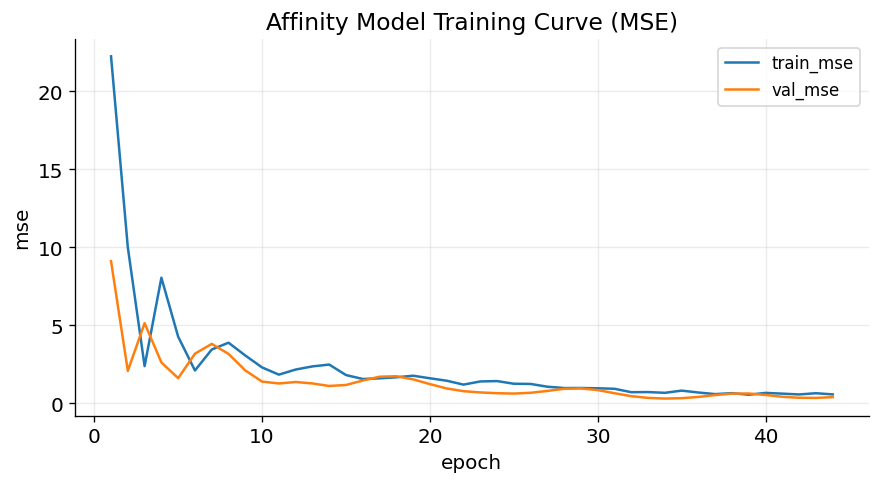

Saved: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/State2Drug/runs/ERAP2_20260129_110535/candidates/candidates_affinity.csv


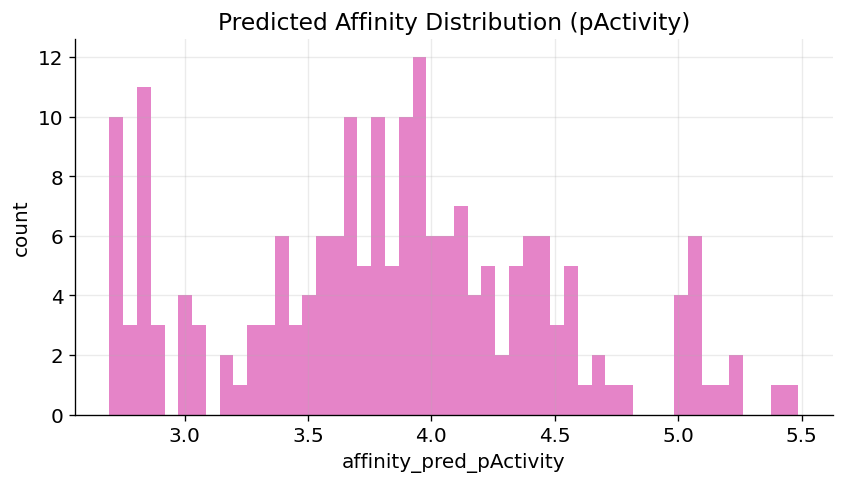

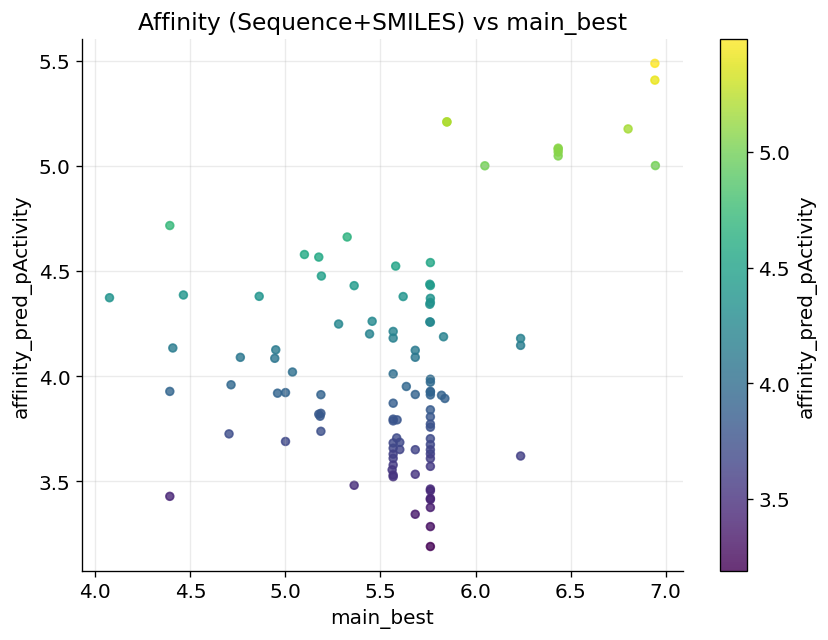

{'candidates': 196, 'with_pocket_score': 104, 'pocket_score_col': 'main_best'}


,candidate_id,smiles,sources,affinity_pred_pActivity,affinity_pred_nM,main_best,score_best,objective,main_refined,main_score
3,cand_000018,CC(C)C[C@H](CP(=O)(O)[C@@H](N)CCc1ccccc1)C(=O)...,"htvs_refined,library",5.486686,3260.721975,6.943332,6.943332,NaN,6.943332,6.943332
1,cand_000017,CC(C)C[C@@H](CP(=O)(O)[C@@H](N)CCc1ccccc1)C(=O...,gen_targeted,5.406963,3917.749390,6.943332,7.418570,7.418570,NaN,6.943332
52,cand_000085,NC(CCc1ccccc1)P(=O)(O)CC(Cc1ccc(O)cc1)C(=O)O,"htvs_refined,library",5.208541,6186.693584,5.849328,5.849328,NaN,5.849328,5.849328
53,cand_000083,NC(CCc1ccc(O)cc1)P(=O)(O)CC(Cc1ccccc1)C(=O)O,"htvs_refined,library",5.208541,6186.693584,5.849328,5.849328,NaN,5.849328,5.849328
4,cand_000082,NC(CCc1ccc(CO)cc1)P(=O)(O)CC(Cc1ccccc1)C(=O)O,"htvs_refined,library",5.175240,6679.753513,6.802565,6.802565,NaN,6.802565,6.802565
8,cand_000100,N[C@@H](CCc1ccccc1)P(=O)(O)C[C@@H](Cc1ccccc1)C...,"htvs_refined,library",5.083720,8246.701398,6.434782,6.434782,NaN,6.434782,6.434782
10,cand_000088,NC(CCc1ccncc1)P(=O)(O)CC(Cc1ccccc1)C(=O)O,"htvs_refined,library",5.078749,8341.637194,6.434782,6.434782,NaN,6.434782,6.434782
9,cand_000087,NC(CCc1cccnc1)P(=O)(O)CC(Cc1ccccc1)C(=O)O,"htvs_refined,library",5.065423,8601.564792,6.434782,6.434782,NaN,6.434782,6.434782
2,cand_000086,NC(CCc1ccccc1)P(=O)(O)CC(Cc1ccccc1)C(=O)O,"gen_targeted,htvs_refined,library",5.046759,8979.266708,6.434782,6.971019,6.971019,6.434782,6.434782
0,cand_000051,CO[C@@H]1CCCN1C(=O)[C@H](CC(C)C)CP(=O)(O)[C@@H...,gen_targeted,5.000939,9978.404556,6.946079,7.427073,7.427073,NaN,6.946079


In [29]:
affinity_model = None
aff_hist = None

try:
    if RUN_AFFINITY_TRAIN or not AFFINITY_MODEL_PATH.exists():
        train_df = (
            labels_affinity
            if "labels_affinity" in globals() and labels_affinity is not None and not labels_affinity.empty
            else labels_train
        )
        train_df = train_df.dropna(subset=["smiles", "pActivity"]).copy()
        train_df = train_df.groupby("smiles", as_index=False).agg(pActivity=("pActivity", "median"))
        affinity_model, aff_hist = s2d.AffinityCharCNNPredictor.fit(
            smiles=train_df["smiles"].astype(str).tolist(),
            y=train_df["pActivity"].astype(float).tolist(),
            protein_sequence=seq_erap2,
            max_smiles_len=AFFINITY_MAX_SMILES_LEN,
            max_protein_len=AFFINITY_MAX_PROTEIN_LEN,
            batch_size=AFFINITY_BATCH_SIZE,
            lr=AFFINITY_LR,
            epochs=AFFINITY_EPOCHS,
            val_frac=0.15,
            seed=0,
            device=DEVICE,
            save_path=AFFINITY_MODEL_PATH,
            verbose=False,
        )
        print("Saved affinity model:", AFFINITY_MODEL_PATH)
    else:
        affinity_model = s2d.AffinityCharCNNPredictor.load(AFFINITY_MODEL_PATH, device=DEVICE)
        print("Loaded affinity model:", AFFINITY_MODEL_PATH)

    if aff_hist is not None and not aff_hist.empty:
        try:
            fig, ax = plt.subplots(figsize=(7.5, 4.2))
            x = aff_hist["epoch"].astype(float).to_numpy() if "epoch" in aff_hist.columns else np.arange(len(aff_hist), dtype=float)
            for i, col in enumerate([c for c in ["train_mse", "val_mse"] if c in aff_hist.columns]):
                ax.plot(x, aff_hist[col].astype(float).to_numpy(), label=col, color=S2D_COLORWAY[i % len(S2D_COLORWAY)])
            ax.set_title("Affinity Model Training Curve (MSE)")
            ax.set_xlabel("epoch")
            ax.set_ylabel("mse")
            ax.legend()
            savefig(fig, FIG_DIR / "affinity_training_curve.png")
            plt.show()
        except Exception as e:
            print("Skip affinity training curve plot:", repr(e))

except Exception as e:
    print("Skip affinity model setup:", repr(e))
    affinity_model = None

if affinity_model is None:
    print("Affinity model unavailable (install torch / check CUDA) — skip prediction.")
else:
    if RUN_AFFINITY_PRED:
        candidates_aff = candidates.copy()
        candidates_aff["affinity_pred_pActivity"] = affinity_model.predict(
            candidates_aff["smiles"].astype(str).tolist(),
            protein_sequence=seq_erap2,
            batch_size=AFFINITY_BATCH_SIZE,
        )
        candidates_aff["affinity_pred_nM"] = np.power(10.0, 9.0 - candidates_aff["affinity_pred_pActivity"].astype(float))
        out_path = cand_dir / "candidates_affinity.csv"
        candidates_aff.to_csv(out_path, index=False)
        print("Saved:", out_path)

        try:
            vals = candidates_aff["affinity_pred_pActivity"].dropna().astype(float).to_numpy()
            if len(vals):
                fig, ax = plt.subplots(figsize=(7.2, 4.2))
                ax.hist(vals, bins=50, color=S2D_COLORWAY[6], alpha=0.9)
                ax.set_title("Predicted Affinity Distribution (pActivity)")
                ax.set_xlabel("affinity_pred_pActivity")
                ax.set_ylabel("count")
                savefig(fig, FIG_DIR / "affinity_pred_distribution.png")
                plt.show()
        except Exception as e:
            print("Skip affinity pred distribution plot:", repr(e))

        pocket_col = "main_best" if "main_best" in candidates_aff.columns else ("main_refined" if "main_refined" in candidates_aff.columns else None)
        if pocket_col is not None:
            try:
                dfp = candidates_aff.dropna(subset=[pocket_col, "affinity_pred_pActivity"]).copy()
                if not dfp.empty:
                    fig, ax = plt.subplots(figsize=(7.2, 5.5))
                    sc = ax.scatter(
                        dfp[pocket_col].astype(float),
                        dfp["affinity_pred_pActivity"].astype(float),
                        c=dfp["affinity_pred_pActivity"].astype(float),
                        cmap="viridis",
                        s=22,
                        alpha=0.8,
                    )
                    ax.set_title(f"Affinity (Sequence+SMILES) vs {pocket_col}")
                    ax.set_xlabel(str(pocket_col))
                    ax.set_ylabel("affinity_pred_pActivity")
                    fig.colorbar(sc, ax=ax, label="affinity_pred_pActivity")
                    savefig(fig, FIG_DIR / f"affinity_vs_{pocket_col}.png")
                    plt.show()
            except Exception as e:
                print("Skip affinity vs main scatter:", repr(e))

        pocket_col = None
        for _c in ["main_best", "main_refined", "main_score"]:
            if _c in candidates_aff.columns:
                pocket_col = _c
                break

        with_pocket = candidates_aff[pocket_col].notna() if pocket_col else pd.Series([False] * len(candidates_aff))
        print({"candidates": int(len(candidates_aff)), "with_pocket_score": int(with_pocket.sum()), "pocket_score_col": pocket_col})

        view_cols = ["candidate_id", "smiles", "sources", "affinity_pred_pActivity", "affinity_pred_nM"]
        if pocket_col and pocket_col not in view_cols:
            view_cols.append(pocket_col)
        for _c in ["score_best", "objective", "main_refined", "main_score"]:
            if _c in candidates_aff.columns and _c not in view_cols:
                view_cols.append(_c)

        if bool(with_pocket.any()):
            top_aff = candidates_aff[with_pocket].sort_values("affinity_pred_pActivity", ascending=False).head(30)
            display(top_aff[view_cols].head(20))
        else:
            top_aff = candidates_aff.sort_values("affinity_pred_pActivity", ascending=False).head(30)
            display(top_aff[view_cols].head(20))
    else:
        print("Skip affinity prediction (RUN_AFFINITY_PRED=False)")
